# Plot Kinematical distribution of tagged and untagged events 
$x_B, Q^2, W, z_{\pi}...$

If possible, apply background subtraction of tagged events, based on ToF

last edit Nov-16, 2022

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;
# from event_selection_tools        import *;

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

# (1) Load data and apply selection cuts not previously imposed
All runs of $(e,e'\pi)$ data and all runs of $(e,e'\pi n)$ - as with a small number of runs normalization is off

In [4]:
[e_e_pi, e_e_pi_n,_] = load_SIDIS_data( Nruns = -1,
                                       subdirname = "sidisdvcs_27Oct2022_commit_2fe215f",
                do_e_e_pi=True, 
                do_e_e_pi_n=True, 
                do_e_e_pi_FreeP=True,
                fdebug=1, do_all_vars=True)
e_e_pi_pass_cuts,e_e_pi_n_pass_cuts,e_e_pi_FreeP_pass_cuts,_ = apply_further_selection_cuts_to_data(fdebug=0);

Done loading files.

Total statistics:
26562112  d(e,e'π+)  events
3820  d(e,e'π+n) events
384081  p(e,e'π+)  events
11055256  d(e,e'π-)  events
1231  d(e,e'π-n) events
117392  p(e,e'π-)  events
Applying selection cuts not previously imposed
Apply a π+/π- acceptance matching cut on the in p-theta plane
Apply a cut on the missing mass of a (e,e'π) reaction: 1.3<Mx<5.0 GeV/c2
(e,e π+ )
26562112 events after original cut (100.0 %)
18073707 events after p-theta cut (68.0 %)
17106417 events after Mx cut (64.4 %)
17106417 events after Kinematical cut (64.4 %)
(e,e π- )
11055256 events after original cut (100.0 %)
10709556 events after p-theta cut (96.9 %)
10293710 events after Mx cut (93.1 %)
10293710 events after Kinematical cut (93.1 %)
 
Apply a cut on the minimal neutron momentum p > 0.275 GeV/c
Apply a π+/π- acceptance matching cut on the in p-theta plane
Apply a cut on the missing mass of a (e,e'π) reaction: 1.3<Mx<5.0 GeV/c2
(e,e π+ )
3820 events after original cut (100.0 %)
1733 even

# (2) Count event statistics

In [6]:
Stats = dict()
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    Stats["$d(e,e'"+pi_label+")$"]  = float(len(e_e_pi_pass_cuts[pi_ch]))
    Stats["$d(e,e'"+pi_label+"n)$"] = float(len(e_e_pi_n_pass_cuts[pi_ch]))
    Stats["$p(e,e'"+pi_label+")$"] = float(len(e_e_pi_FreeP_pass_cuts[pi_ch]))

Stats["$d(e,e'\\pi^{+})/d(e,e'\\pi^{-})$"] = Stats["$d(e,e'\\pi^{+})$"]/Stats["$d(e,e'\\pi^{-})$"]
Stats["$d(e,e'\\pi^{+}n)/d(e,e'\\pi^{-}n)$"] = Stats["$d(e,e'\\pi^{+}n)$"]/Stats["$d(e,e'\\pi^{-}n)$"]
Stats["$p(e,e'\\pi^{+})/p(e,e'\\pi^{-})$"] = Stats["$p(e,e'\\pi^{+})$"]/Stats["$p(e,e'\\pi^{-})$"]

display(Stats)

{"$d(e,e'\\pi^{+})$": 17106417.0,
 "$d(e,e'\\pi^{+}n)$": 1680.0,
 "$p(e,e'\\pi^{+})$": 218022.0,
 "$d(e,e'\\pi^{-})$": 10293710.0,
 "$d(e,e'\\pi^{-}n)$": 793.0,
 "$p(e,e'\\pi^{-})$": 99305.0,
 "$d(e,e'\\pi^{+})/d(e,e'\\pi^{-})$": 1.6618320314055866,
 "$d(e,e'\\pi^{+}n)/d(e,e'\\pi^{-}n)$": 2.1185372005044134,
 "$p(e,e'\\pi^{+})/p(e,e'\\pi^{-})$": 2.1954785761039224}

# (3) Plot kinematical distributions
$ x_B = Q^2/2m_p\omega$

### auxiliary

In [48]:
def plot_SIDIS_variable(var  = 'Q2', 
                        var_tagged = None, # None = same as (untagged) var
                        bins = np.linspace(1.8,7.8,31),
                        xScaling=1,
                        varlabel = '$Q^2$',
                        varlabel_tagged = '',
                        varunits = '[(GeV/c)$^2$]',
                        xticks = None, 
                        fdebug=1, 
                        ylim_ratio=(0,10),ylim_hists=None,
                        add_published_pips2pims_ratio=[],
                        do_only_top_2=False, 
                        do_add_legends=True):#{
    
    if fdebug>2: print(bins)
    ax = dict()
    
    if do_only_top_2==True: fig = plt.figure(figsize=(16,8),tight_layout=True)
    else:                   fig = plt.figure(figsize=(16,10),tight_layout=True)
    
    if var_tagged is None: #{
        var_tagged = var;
    #}
    
    h,NeventsTot = dict(),dict()
    # compare untagged to tagged seperately for π+ and π-
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,
                                                       pi_labels,pi_colors,[1,2]):
        ax[pi_idx] = fig.add_subplot(2,2,pi_idx)

        # d(e,e'π)
        df = e_e_pi_pass_cuts[pi_ch]
        NeventsTot['untagged'] = len(df)
        x,h['untagged'+pi_ch],x_err,h_err['untagged'+pi_ch] = plot_step_squares( df[var], ax=ax[pi_idx],
                                                                                bins=bins, xScaling=xScaling,
                                                                                density=True, color='k', alpha=0.5, label='Untagged' )
        ax[pi_idx].step(x,h['untagged'+pi_ch],'-k',where='mid')
        
        # d(e,e'πn)
        df = e_e_pi_n_pass_cuts[pi_ch]
        NeventsTot['tagged'] = len(df)
        
        tagged_label = 'Tagged ' + varlabel_tagged
        x,h['tagged'+pi_ch],x_err,h_err['tagged'+pi_ch] = plot_step_hist( df[var_tagged], bins=bins, xScaling=xScaling,
                                                                         marker='s', markersize=1, color=pi_color,
                                                                         label=tagged_label, 
                                                                         alpha=1, density=True)
        # p(e,e'π)
        df = e_e_pi_FreeP_pass_cuts[pi_ch]
        NeventsTot['Free-p'] = len(df)
        x,h['Free-p'+pi_ch],x_err,h_err['Free-p'+pi_ch] = plot_step_squares( df[var], ax=ax[pi_idx],                                                                            
                                                                            bins=bins, xScaling=xScaling,                                                                                
                                                                            density=True, color='m', 
                                                                            alpha=0.5, label='Free-p' )
        ax[pi_idx].step(x,h['Free-p'+pi_ch],'-m',where='mid')
        

        set_axes(ax[pi_idx],
                 varlabel+varunits if do_only_top_2==True else '',
                 'Frequency [a.u.]' if pi_idx==1 else '', 
                 title="$(e,e'"+pi_label+")$ events as a function of "+varlabel,
                 do_add_grid=True,
                 remove_ticks_x=False if do_only_top_2==True else True,
                 do_add_legend=do_add_legends,
                 xticks=xticks,
                 ylim=ylim_hists)
        
    
    if do_only_top_2==True: return ax

    # compare tagged π+ to π-
    ax[3] = fig.add_subplot(2,2,3)
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        df = e_e_pi_n_pass_cuts[pi_ch]
        plot_step_hist( df[var_tagged]*xScaling, bins=bins, marker='s', markersize=1, 
                       color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)
        
    set_axes(ax[3],varlabel+varunits,
             'Frequency [a.u.]', 
             title="Tagged events: $\pi^\pm$ comparison",
             do_add_grid=True, do_add_legend=True,xticks=xticks)

    # Take the ratio of π+/π-
    ax[4] = fig.add_subplot(2,2,4)
    # add existing data
    do_add_legend = True
    if add_published_pips2pims_ratio is not []:
        do_add_legend = False
        for dataset in add_published_pips2pims_ratio:
            plot_pT_published_pips2pims_ratio( dataset, ax=ax[4])


    R, R_err = dict(), dict()
    for datalabel,color,scaleFactor in zip(['untagged','tagged','Free-p'],
                                           ['blue','red','magenta'],
                                           [Stats["$d(e,e'\\pi^{+})/d(e,e'\\pi^{-})$"],
                                            Stats["$d(e,e'\\pi^{+}n)/d(e,e'\\pi^{-}n)$"],
                                                  Stats["$p(e,e'\\pi^{+})/p(e,e'\\pi^{-})$"]]):#{
        R[datalabel]      = np.zeros(len(x))
        R_err[datalabel]  = np.zeros(len(x))
        cutoff = 1./NeventsTot[datalabel]
        
        Npts = len(h_err[datalabel+'piminus'])
        for i in range(Npts):
            R[datalabel][i] = (h[datalabel+'piplus'][i]/np.max([cutoff,h[datalabel+'piminus'][i]])) * scaleFactor
            R_err[datalabel][i] = R[datalabel][i] * np.sqrt(  np.square(h_err[datalabel+'piplus'][i]
                                                                        /np.max([cutoff,h[datalabel+'piplus'][i]]) )                                       
                                                            + np.square(h_err[datalabel+'piminus'][i]
                                                                        /np.max([cutoff,h[datalabel+'piminus'][i]])) )    
            
        # plt.step ( x, R, color=color, where='mid', label=None )
        plt.errorbar ( x=x, xerr=x_err, 
                      y=R[datalabel], yerr=R_err[datalabel], 
                      markersize=8,
                      color=color, marker='o', markeredgecolor='k',
                      linestyle='None',label='This work-'+datalabel,                      
                      capsize=4, capthick=1, alpha=1 )
    #}
    # super-ratio
    SuperR      = np.zeros(len(x))
    SuperR_err  = np.zeros(len(x))
    for i in range(Npts):
        SuperR[i] = R['tagged'][i]/np.max([cutoff,R['untagged'][i]])
        SuperR_err[i] = SuperR[i] * np.sqrt(  np.square(R_err['untagged'][i] /np.max([cutoff,R['untagged'][i]])) 
                                            + np.square(R_err['tagged'][i]  /np.max([cutoff,R['tagged'][i]])   )  )
    plt.errorbar (x=x + 0.01*(x[1]-x[0]), xerr=x_err, 
                  y=SuperR, yerr=SuperR_err, 
                  markersize=6,
                  color='forestgreen', marker='^', markeredgecolor='k',
                  linestyle='None',label='tagged/untagged',
                  capsize=4, capthick=1, alpha=1 );

    # cosmetics
    set_axes(ax[4],varlabel+varunits,
             "$N(e,e' \pi^+) / N(e,e' \pi^-)$", 
             title="Cross-section ratio $\pi^+/\pi^-$",
             do_add_grid=True, do_add_legend=do_add_legend,
             xticks=xticks, 
             ylim=ylim_ratio);
    
    if do_add_legend is False:
        ax[4].legend(bbox_to_anchor=(0.63,0.55),fontsize=18);
    
    return ax
#}

### (3.1) $Q^2$

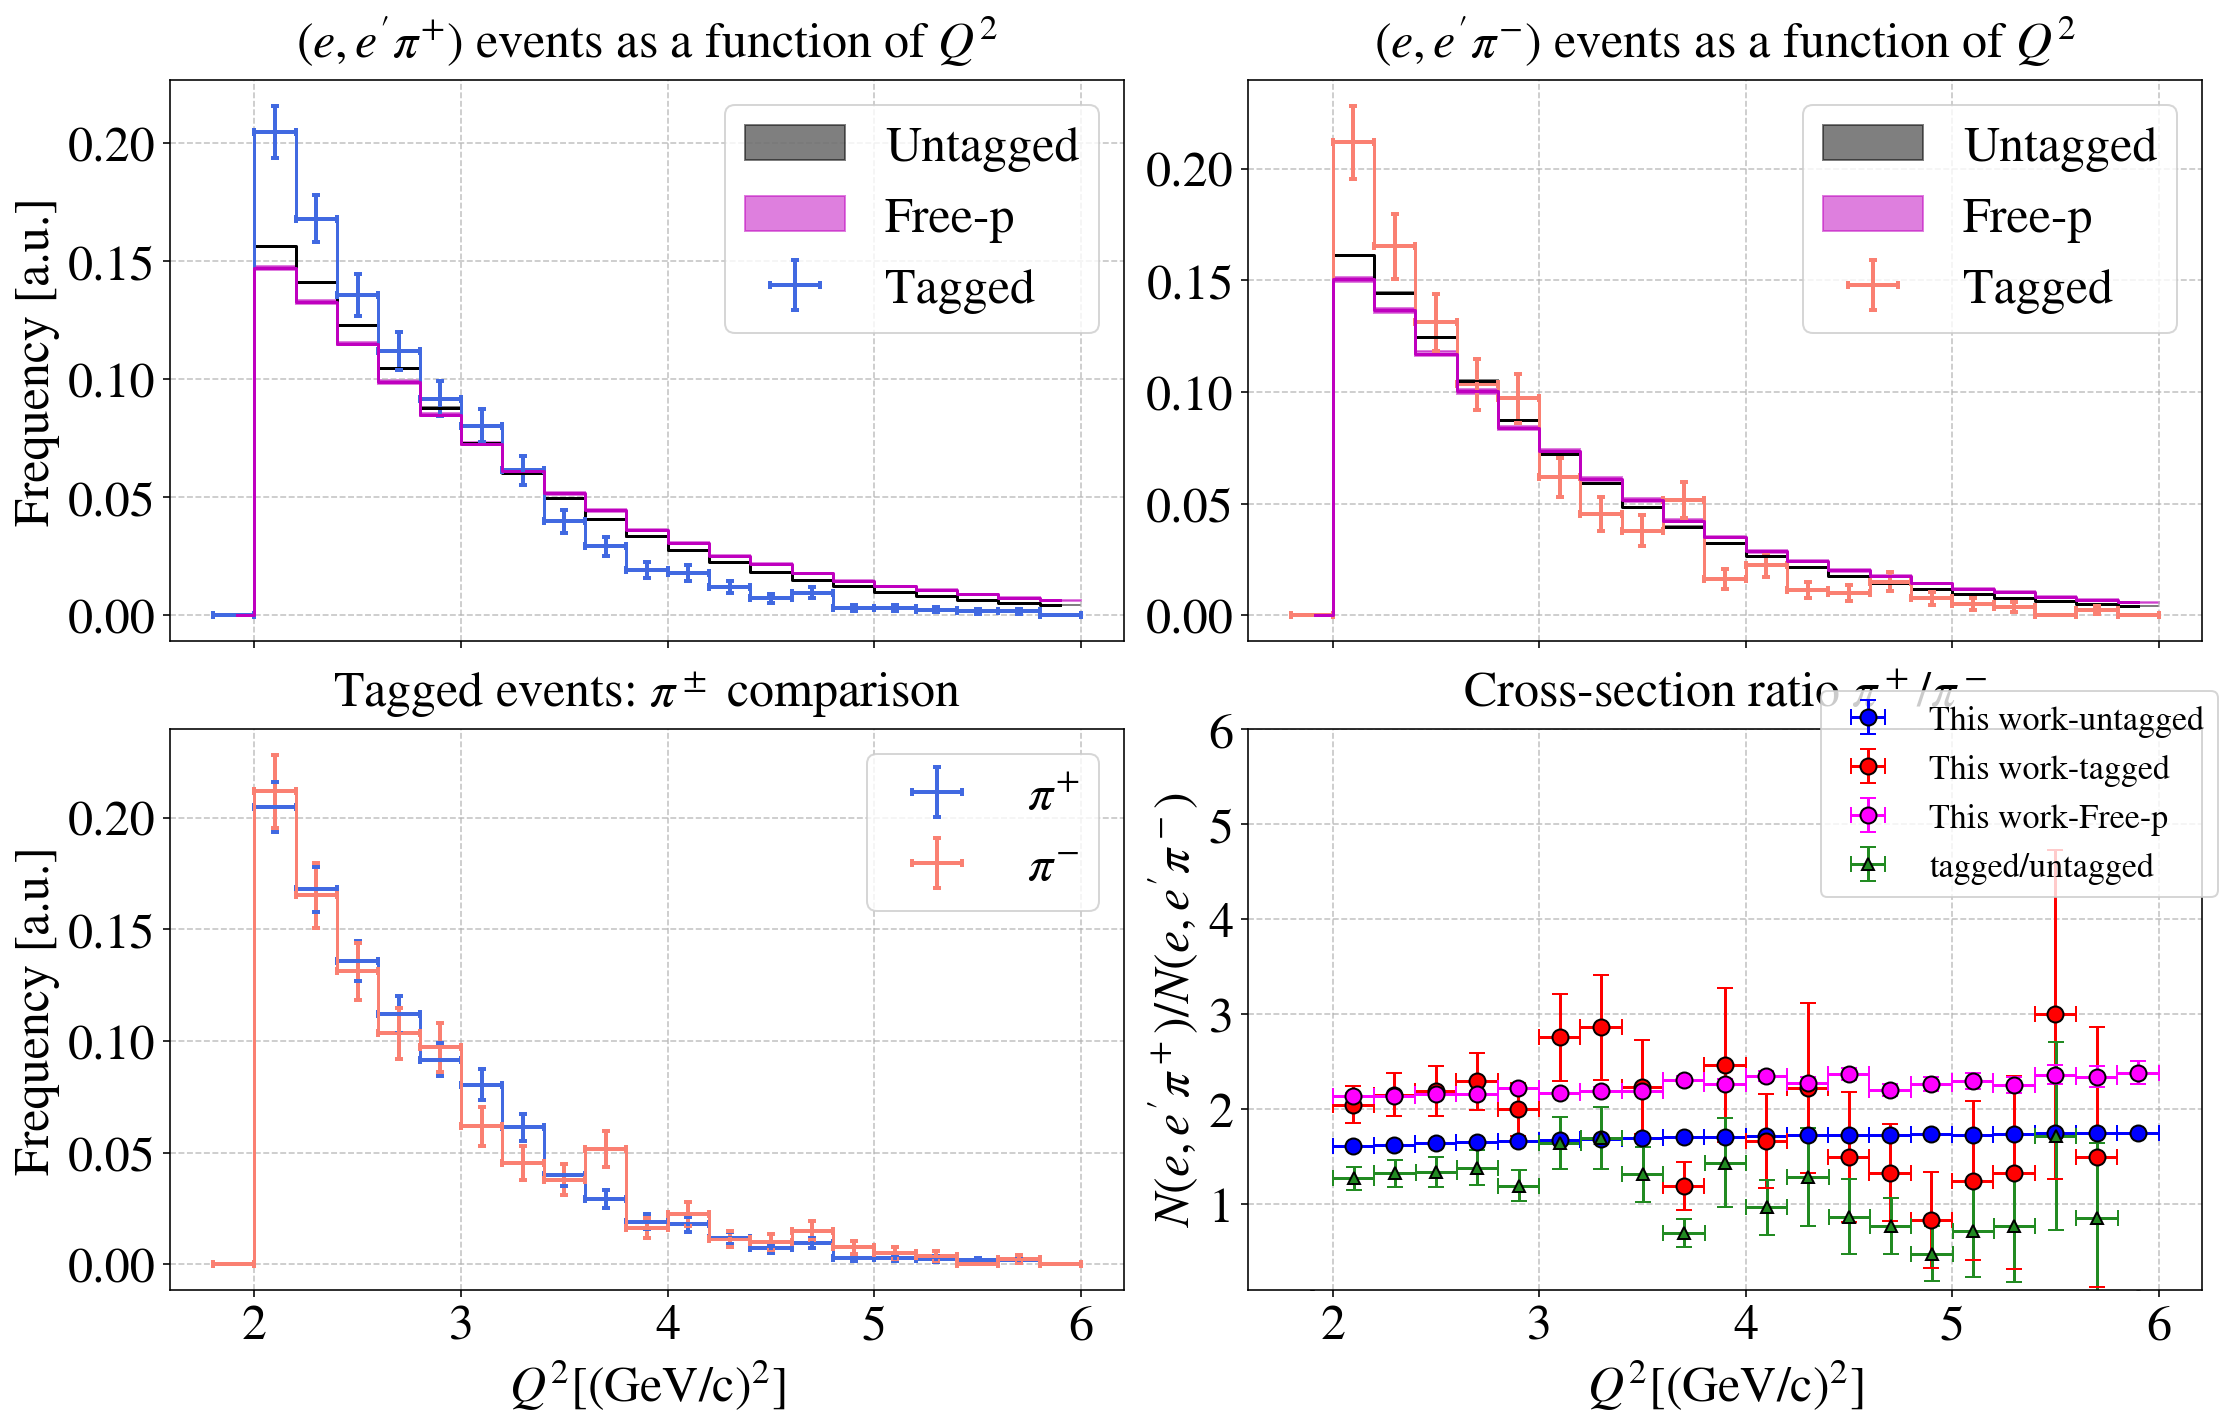

In [50]:
ax=plot_SIDIS_variable(var  = 'Q2',
                        bins = np.linspace(1.8,6,22),
                        varlabel = '$Q^2$',
                        varunits = '[(GeV/c)$^2$]',ylim_ratio=(0.1,6));
ax[4].legend(loc=(0.6,0.7),fontsize=17);

### (3.2) $x_B$ and $x_B'$

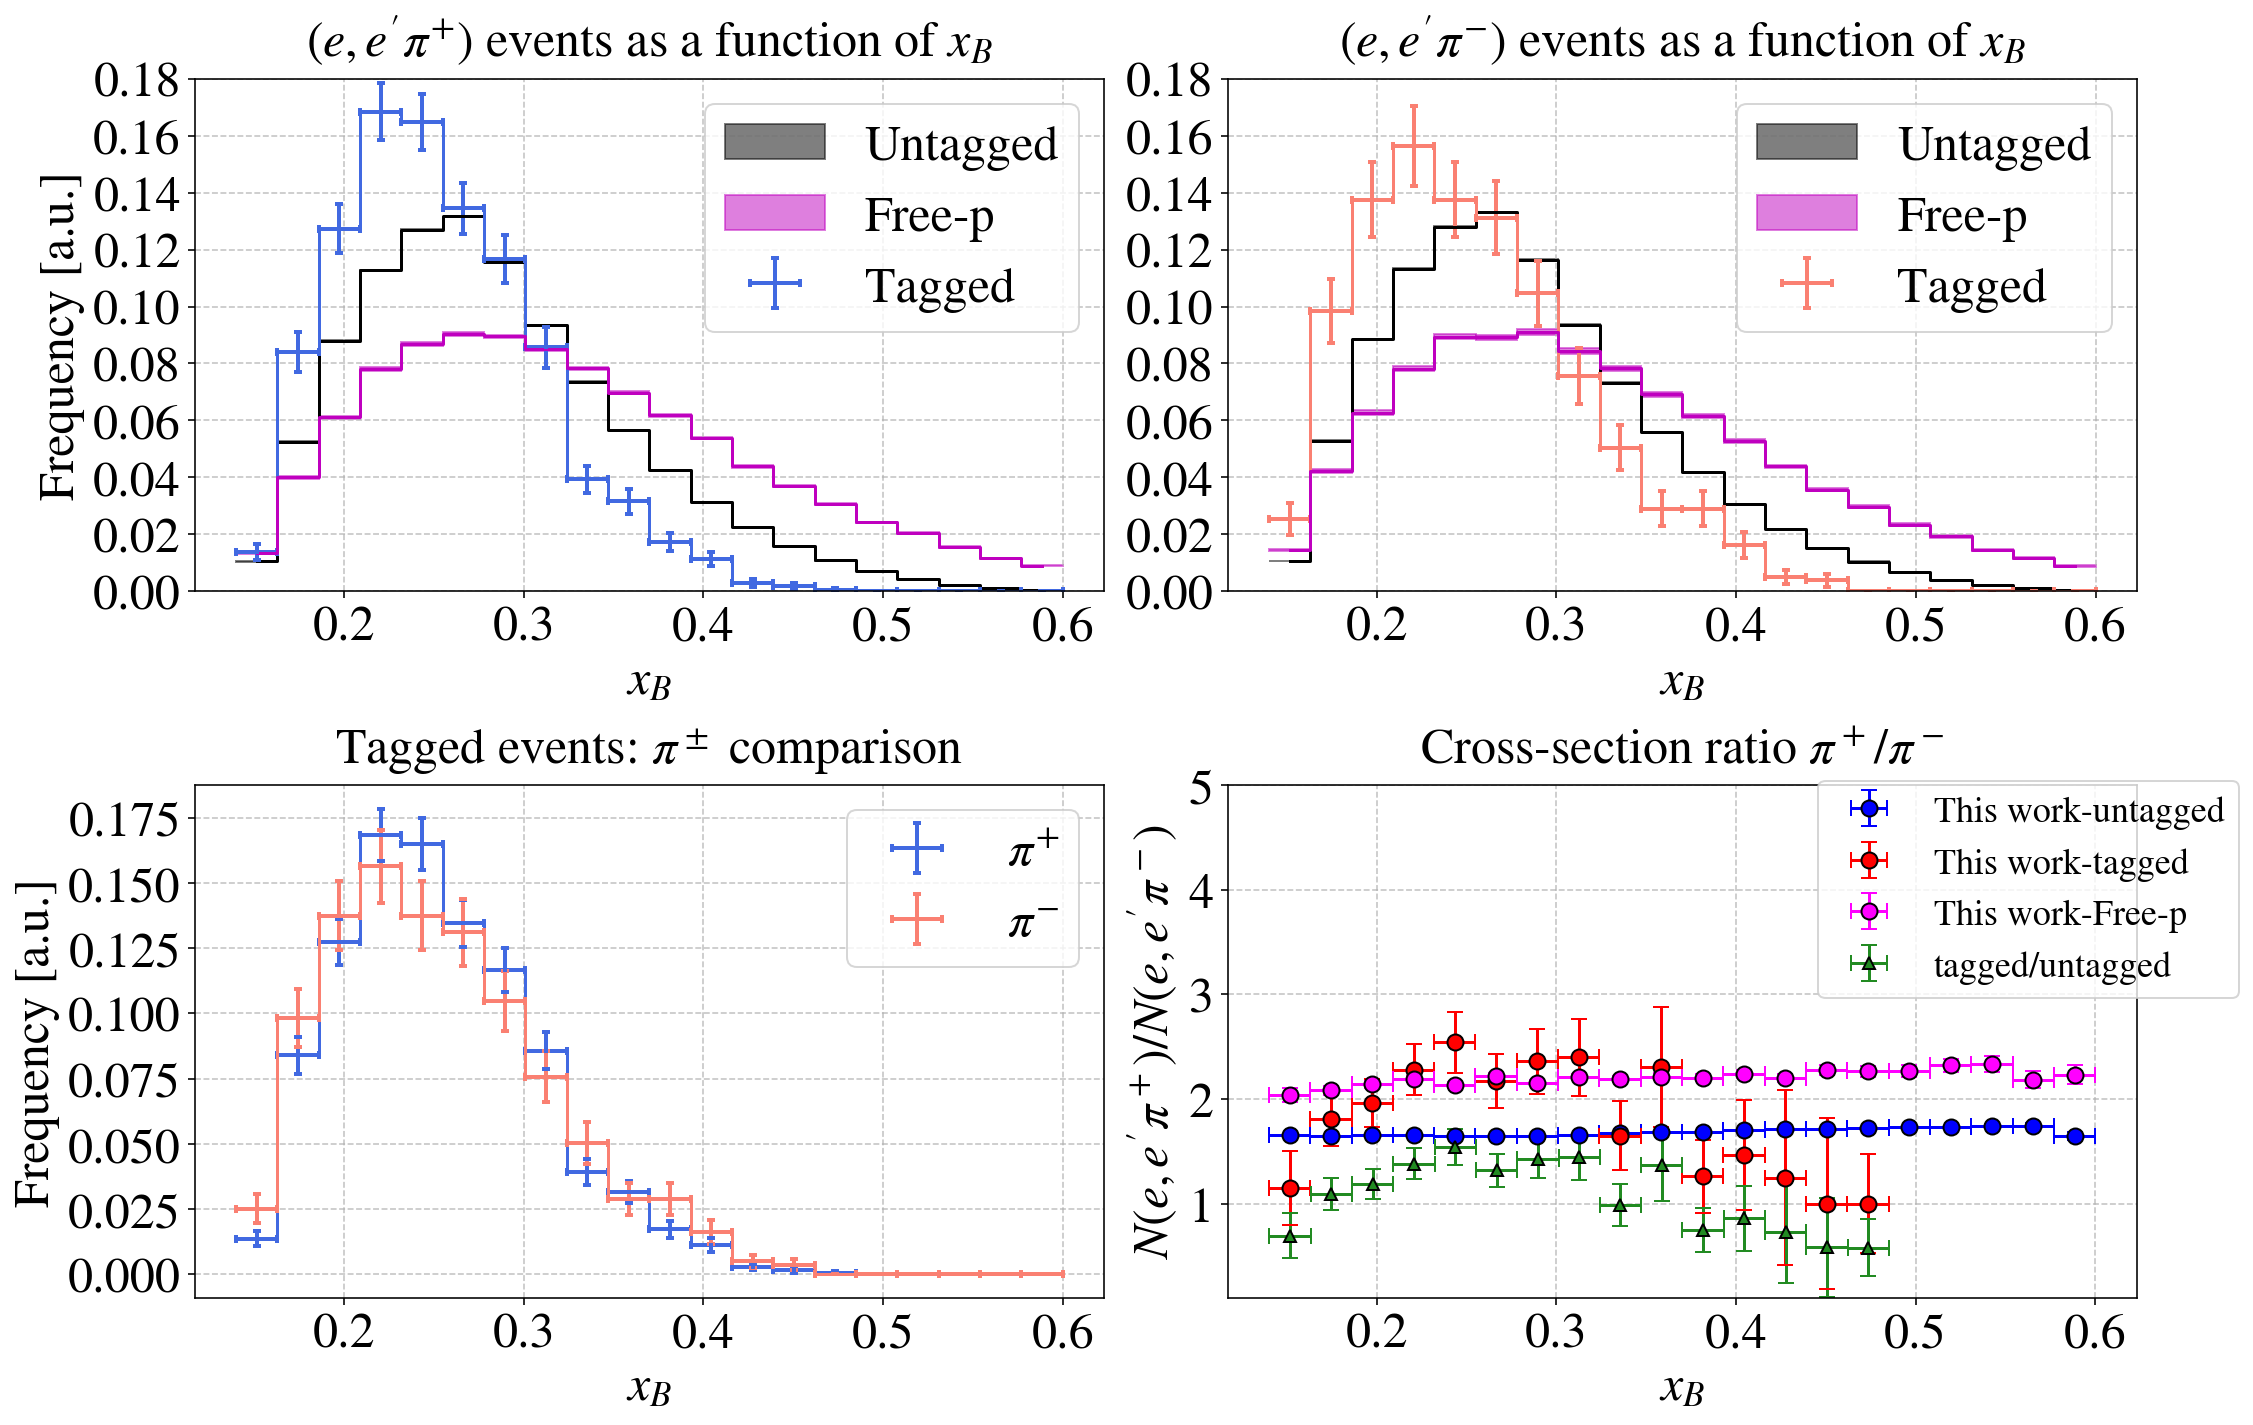

In [9]:
plot_SIDIS_variable(var  = 'xB',
                        bins = np.linspace(0.14,0.6,21),
                        varlabel = '$x_B$',
                        varunits = '',ylim_ratio=(0.1,5),ylim_hists=(0,0.18));

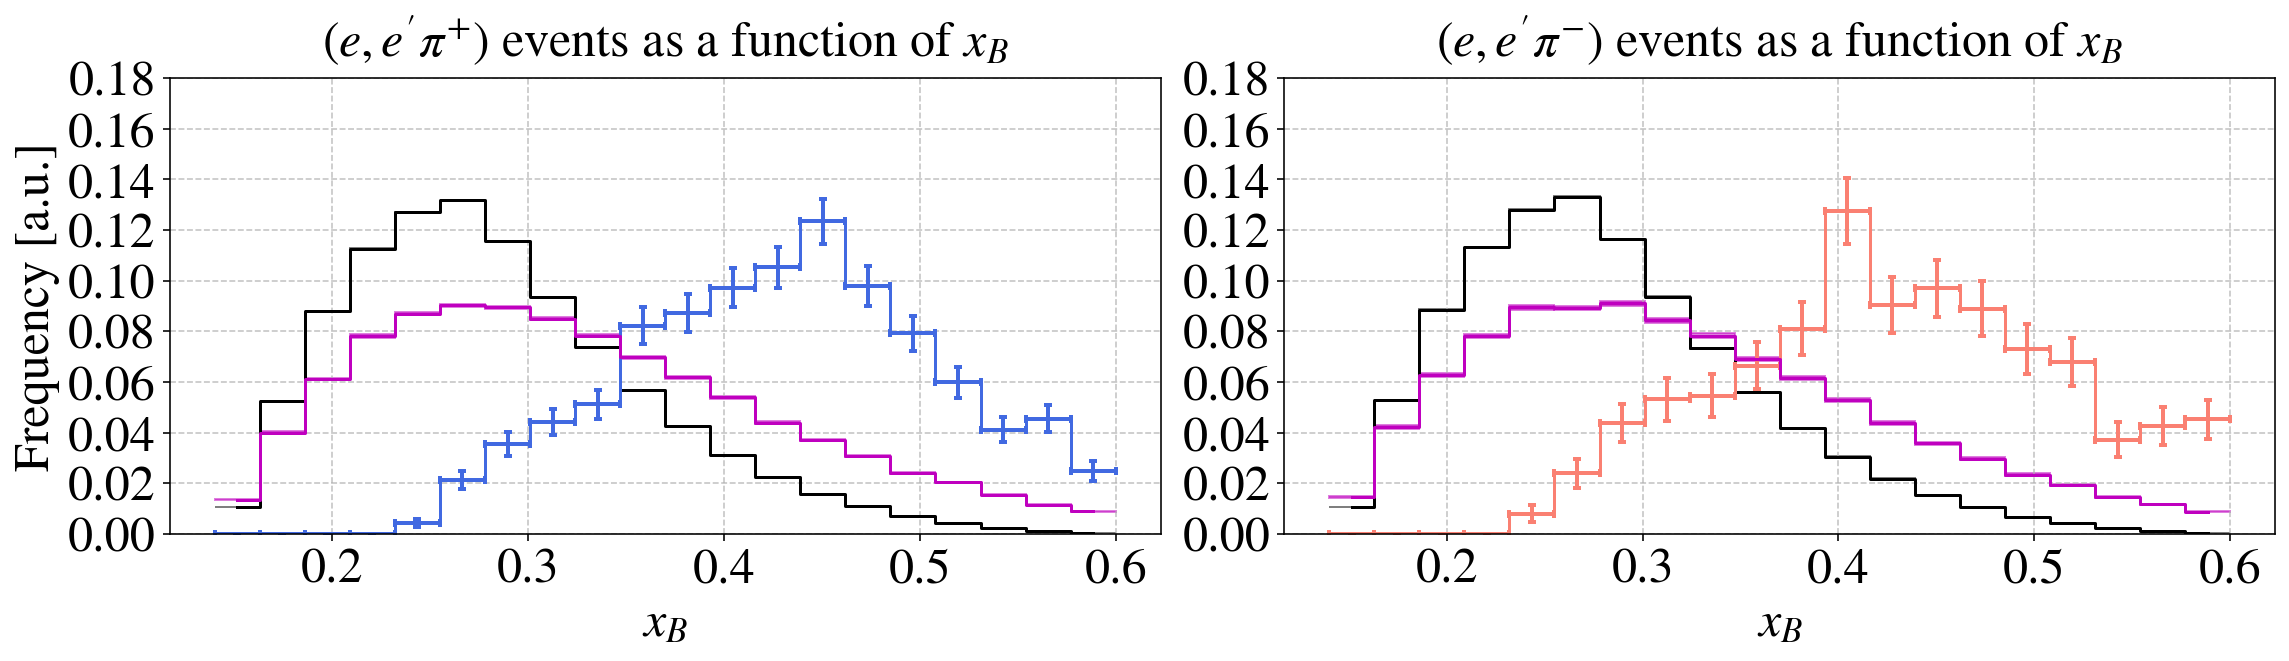

In [10]:
plot_SIDIS_variable(var  = 'xB',
                    var_tagged = 'xB_Prime',
                    bins = np.linspace(0.14,0.6,21),                    
                    varlabel = '$x_B$',
                    varlabel_tagged="$x_B'$",
                    varunits='',
                    do_only_top_2=True,
                    do_add_legends=False,
                    ylim_hists=(0,0.18));

### (3.3) $W$ and $W'$

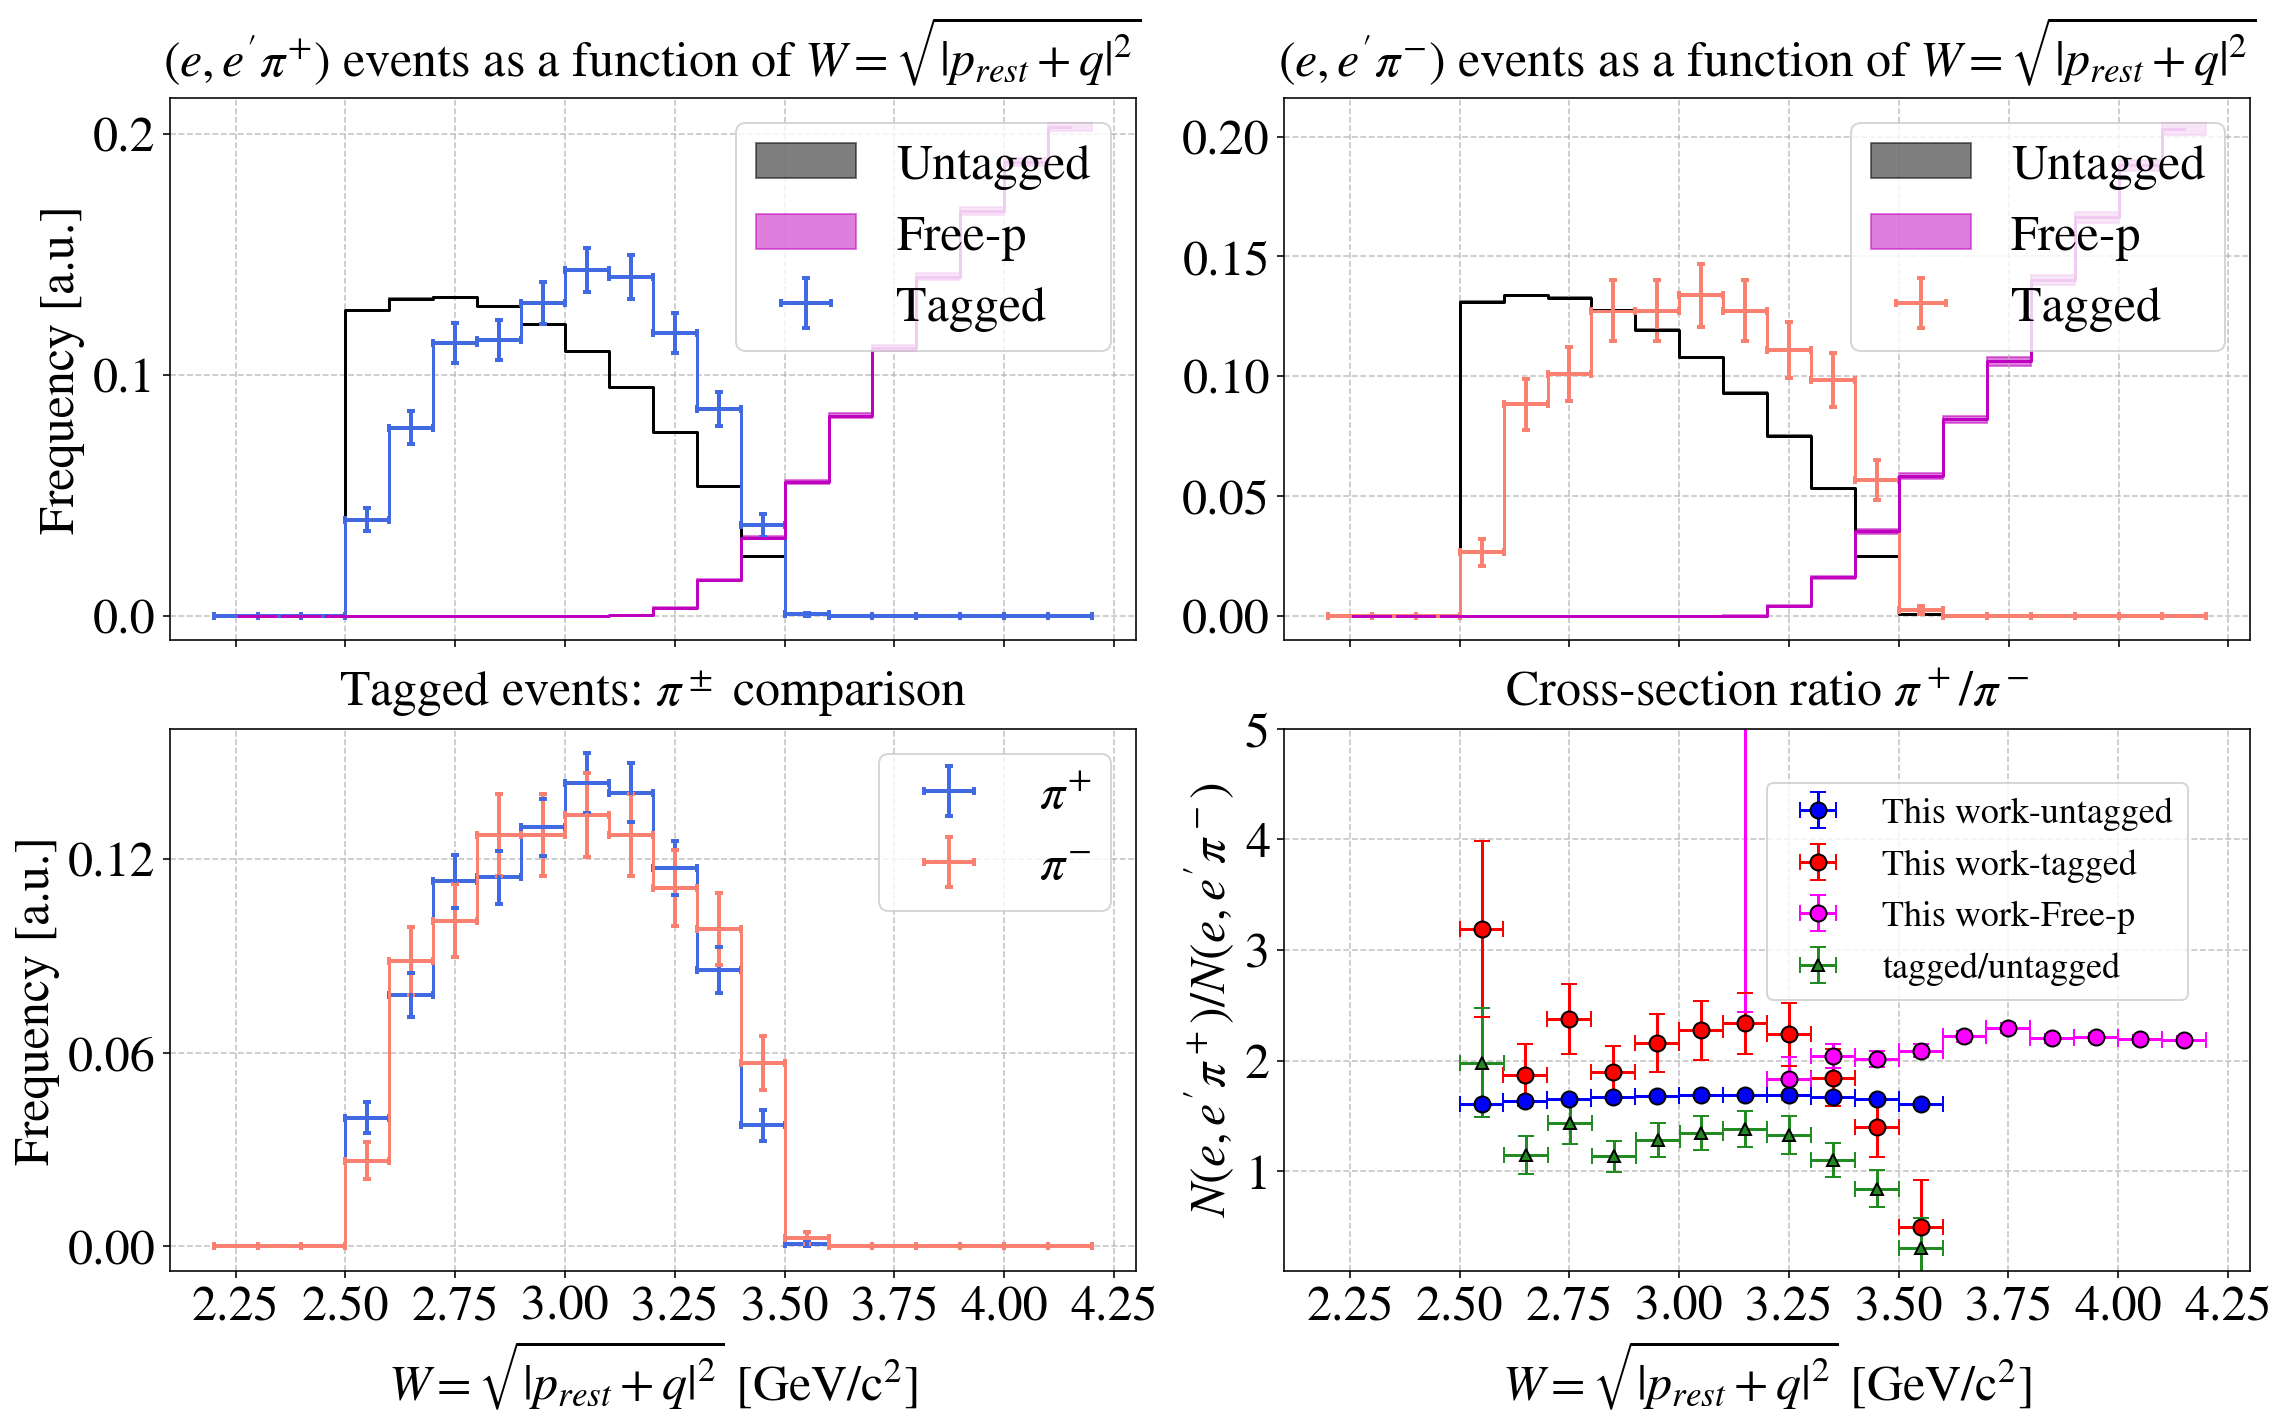

In [49]:
ax=plot_SIDIS_variable(var  = 'W',
                       bins = np.linspace(2.2,4.2,21),
                       varlabel = '$W = \sqrt{|p_{rest} + q|^2}$',
                       varunits = ' [GeV/c$^2$]', ylim_ratio=(0.1,5)
                      );
ax[1].set_yticks([0,0.1,0.2]);
ax[3].set_yticks([0,0.06,0.12]);
ax[4].legend(loc=(0.5,0.5),fontsize=18);

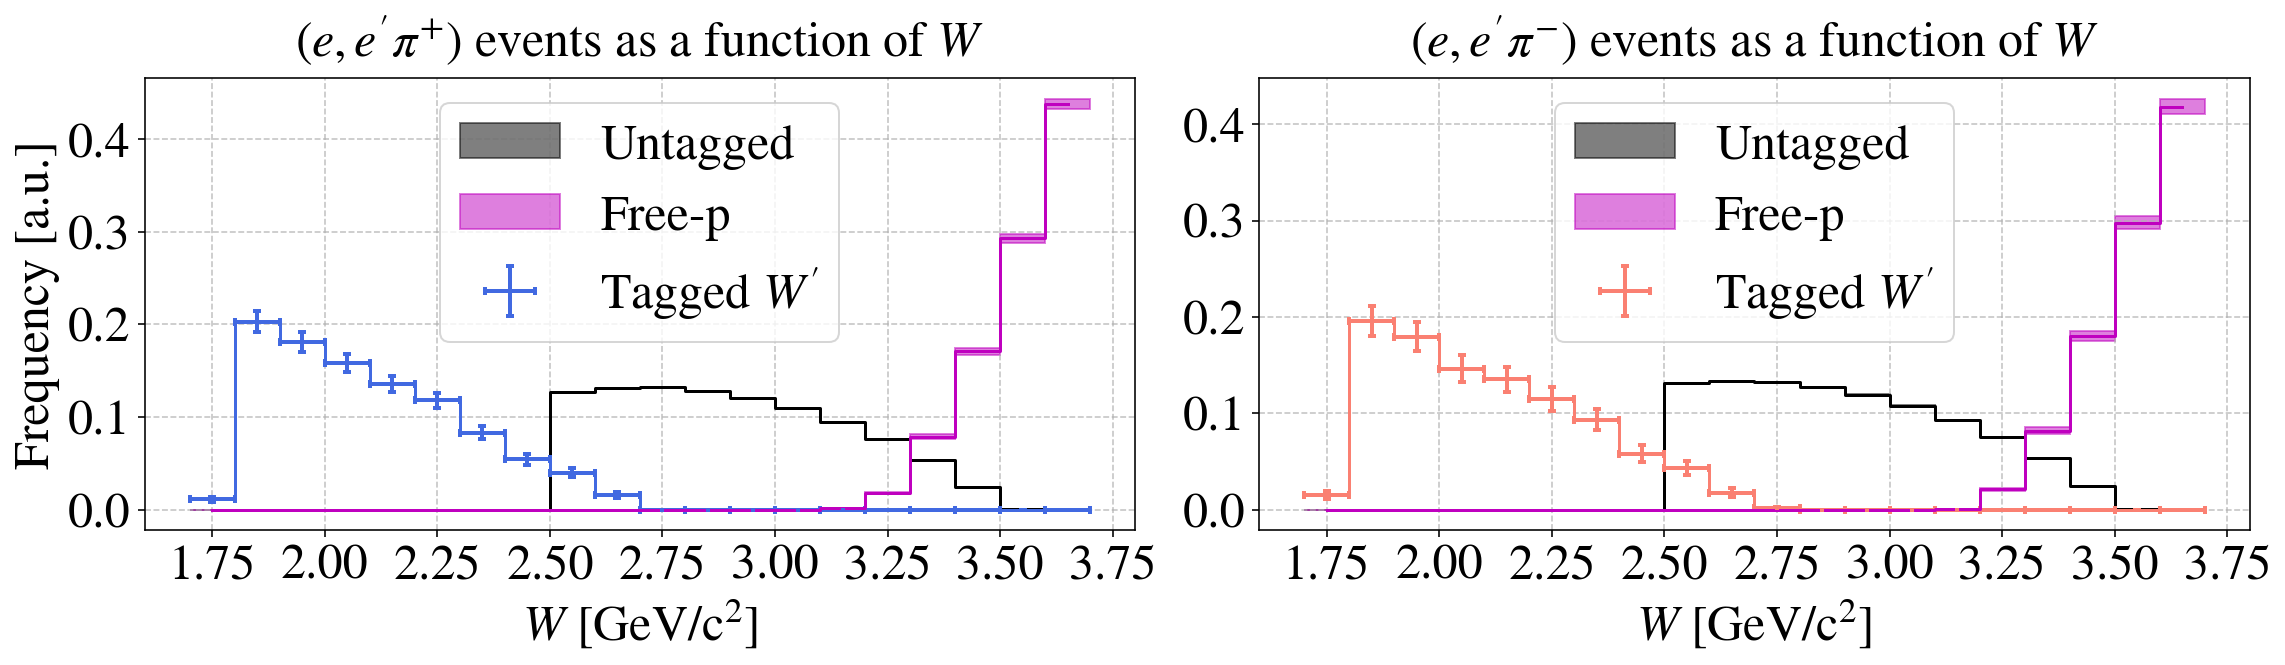

In [12]:
plot_SIDIS_variable(var  = 'W',                      
                    bins = np.linspace(1.7,3.7,21),                    
                    varlabel = '$W$',
                    varunits = ' [GeV/c$^2$]', 
                    var_tagged = 'W_Prime',
                    varlabel_tagged="$W'$",
                    ylim_ratio=(0.1,5), 
                    do_only_top_2=True);

### (3.4) $z_{\pi}$ and $z_{\pi}^{LC}$

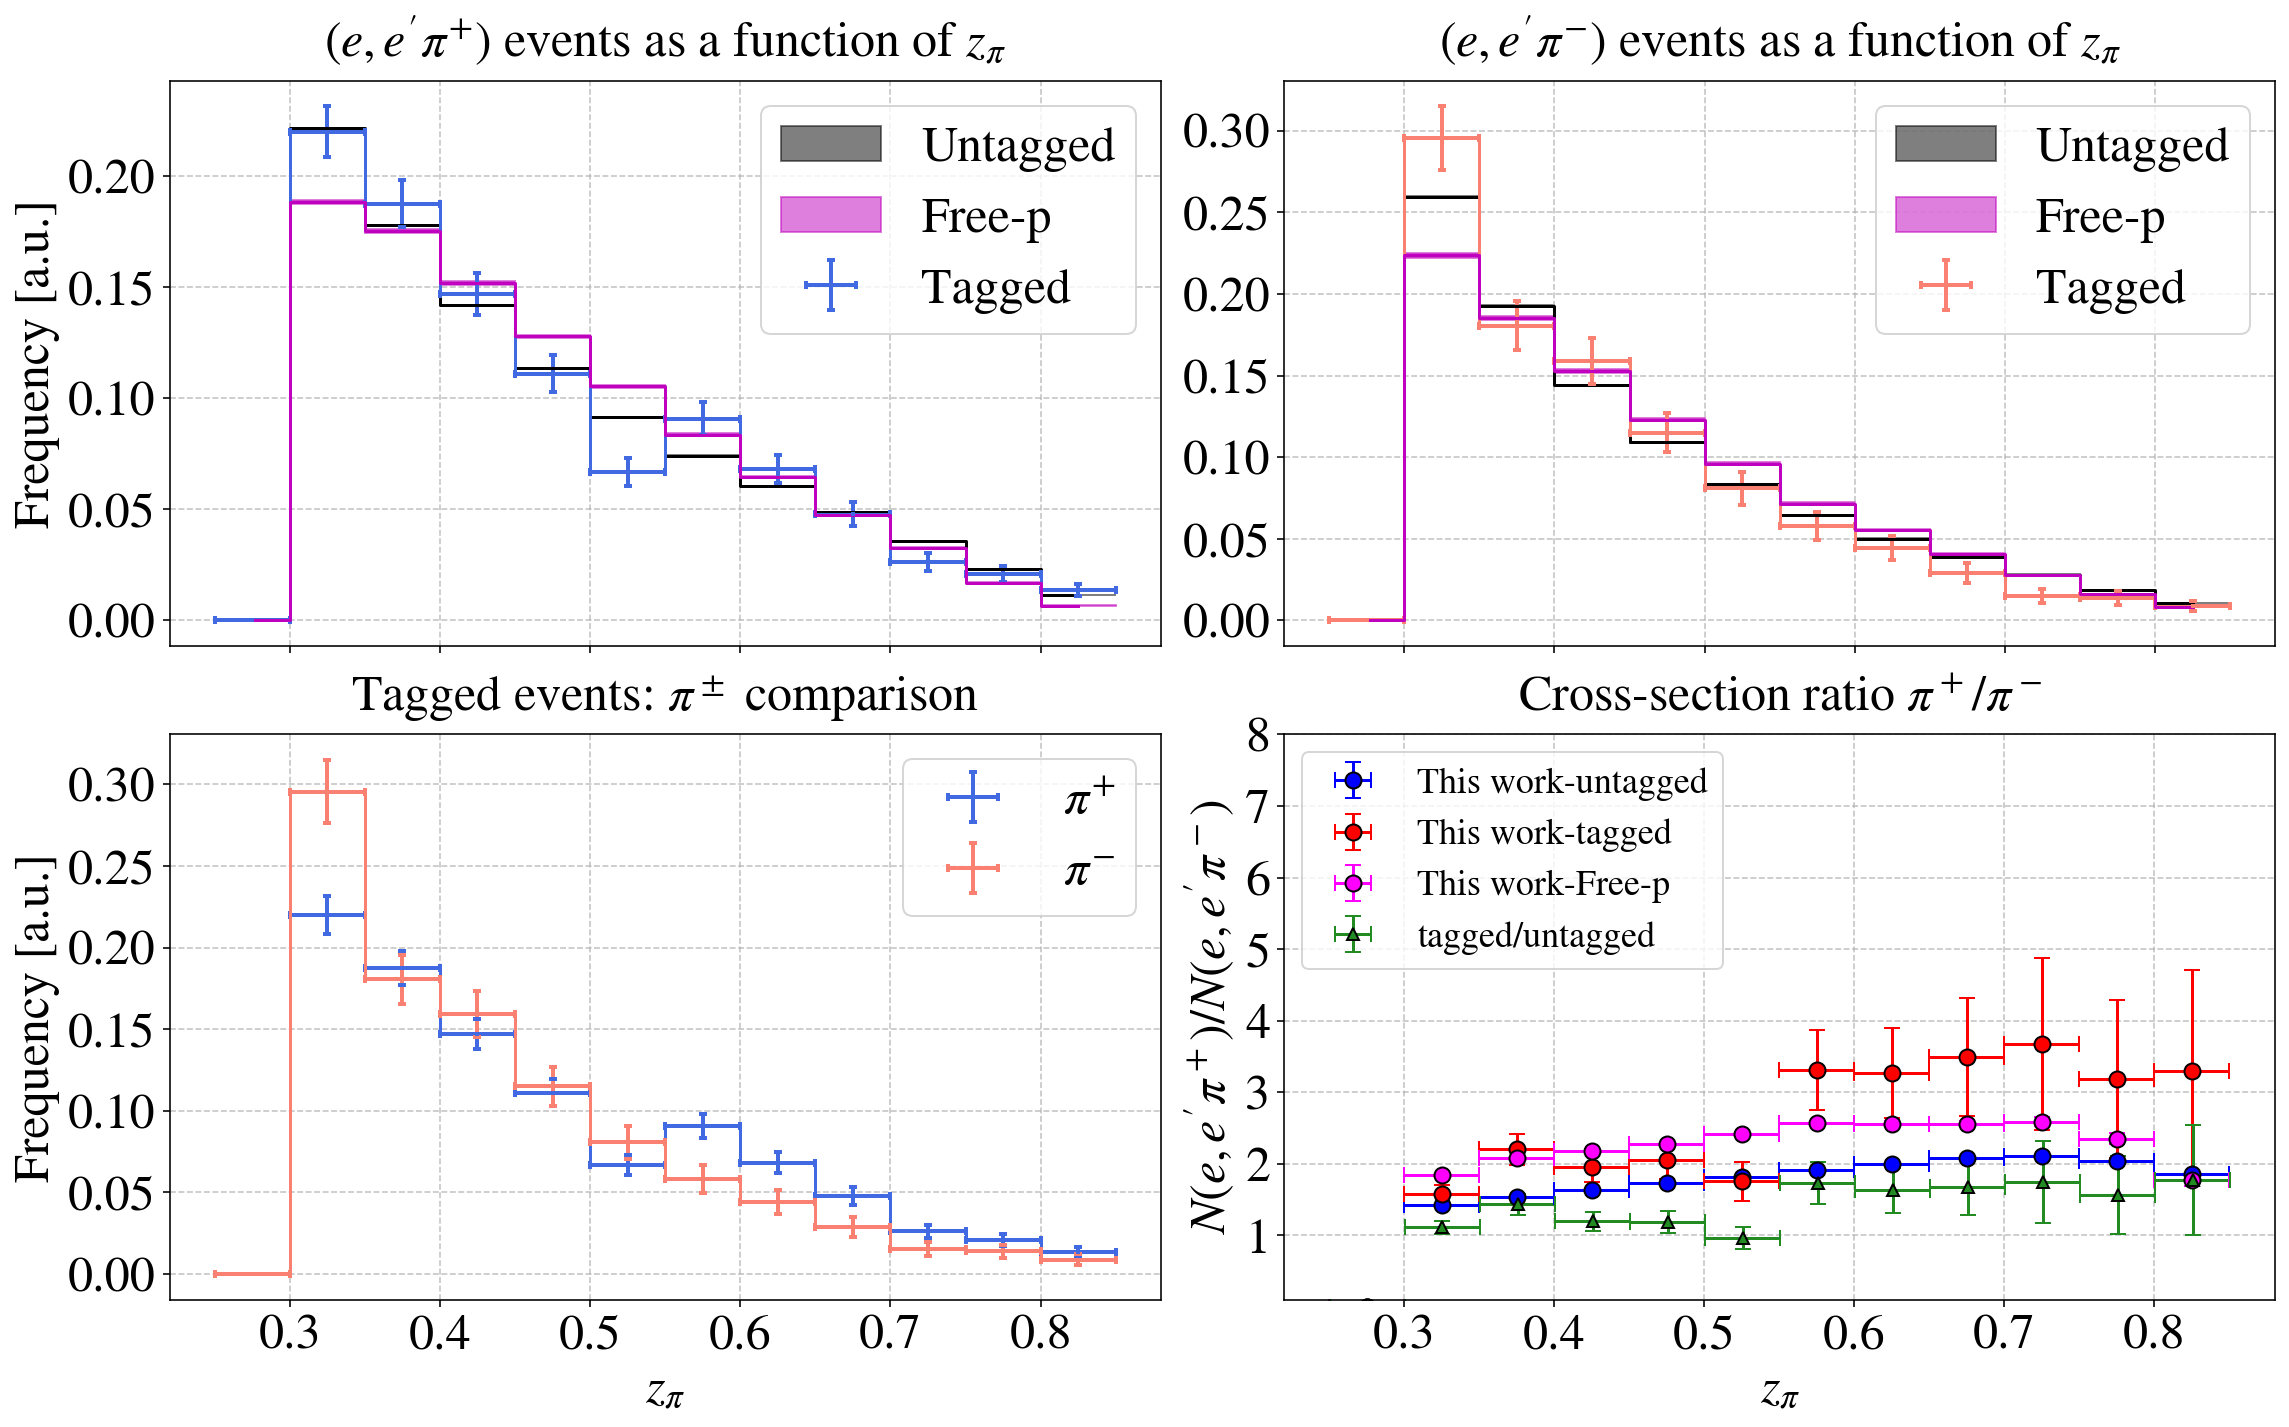

In [51]:
ax=plot_SIDIS_variable(var  = 'Zpi',                    
                    bins = np.linspace(0.25,0.85,13),  
                    varlabel = '$z_{\pi}$',                    
                    varunits = '',ylim_ratio=(0.1,8));
ax[4].legend(loc='best',fontsize=18);

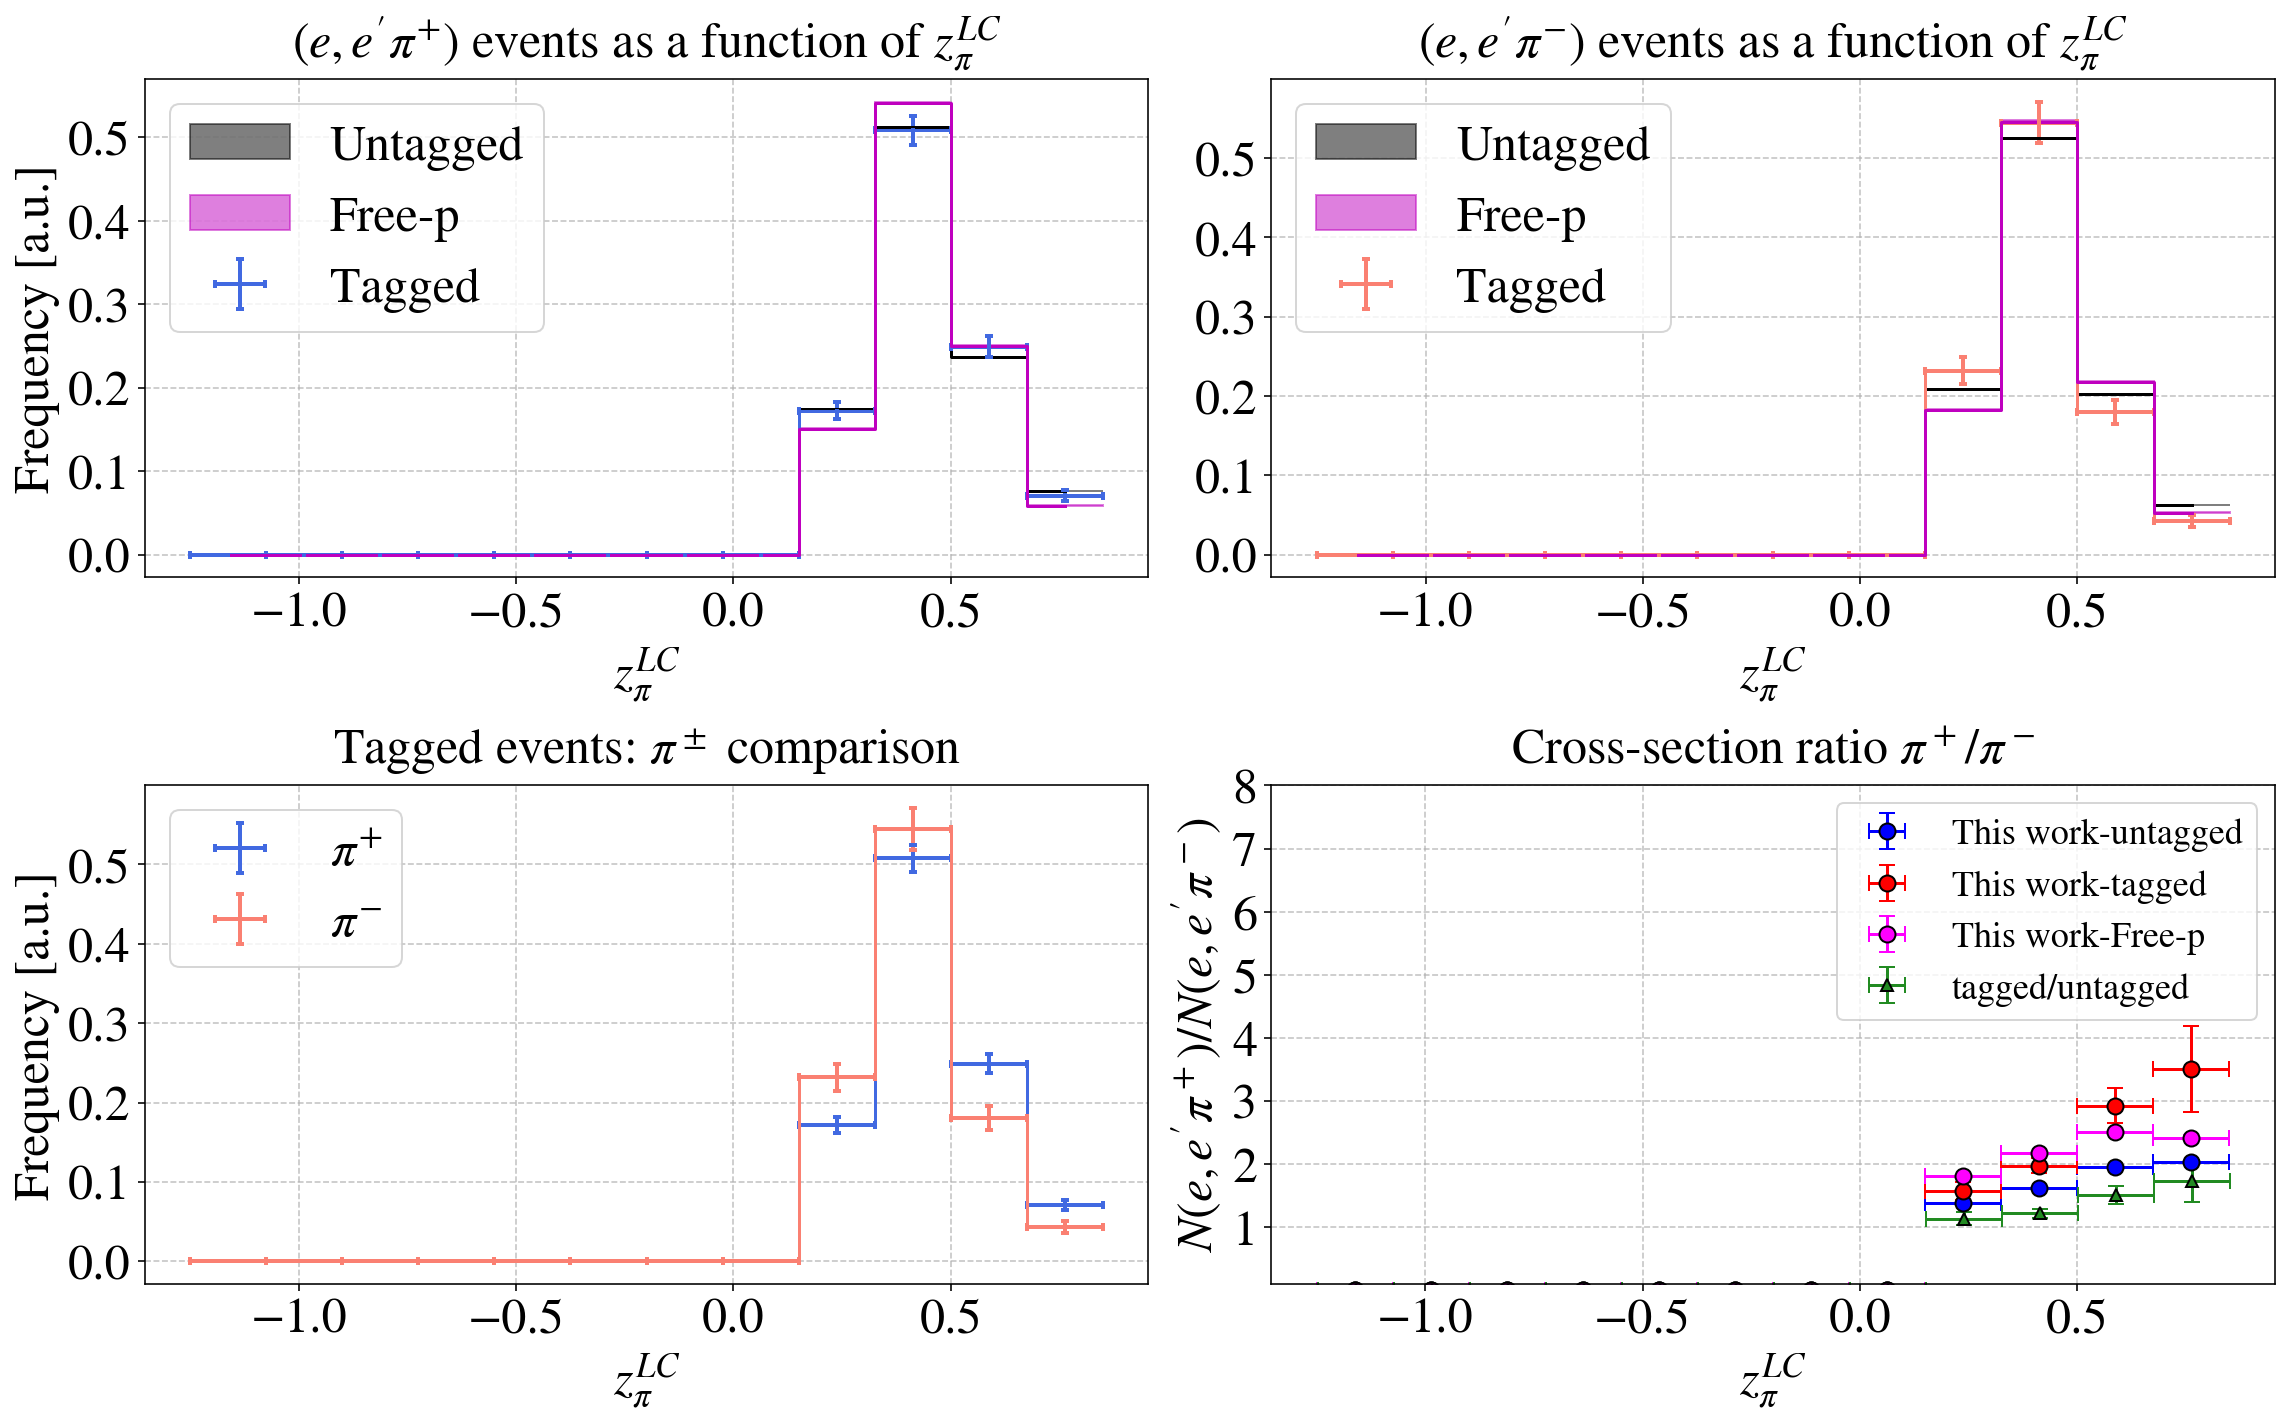

In [14]:
ax=plot_SIDIS_variable(var  = 'Zpi_LC',                    
                    bins = np.linspace(-1.25,0.85,13),  
                    varlabel = '$z_{\pi}^{LC}$',                    
                    varunits = '',ylim_ratio=(0.1,8));
ax[4].legend(loc='best',fontsize=18);

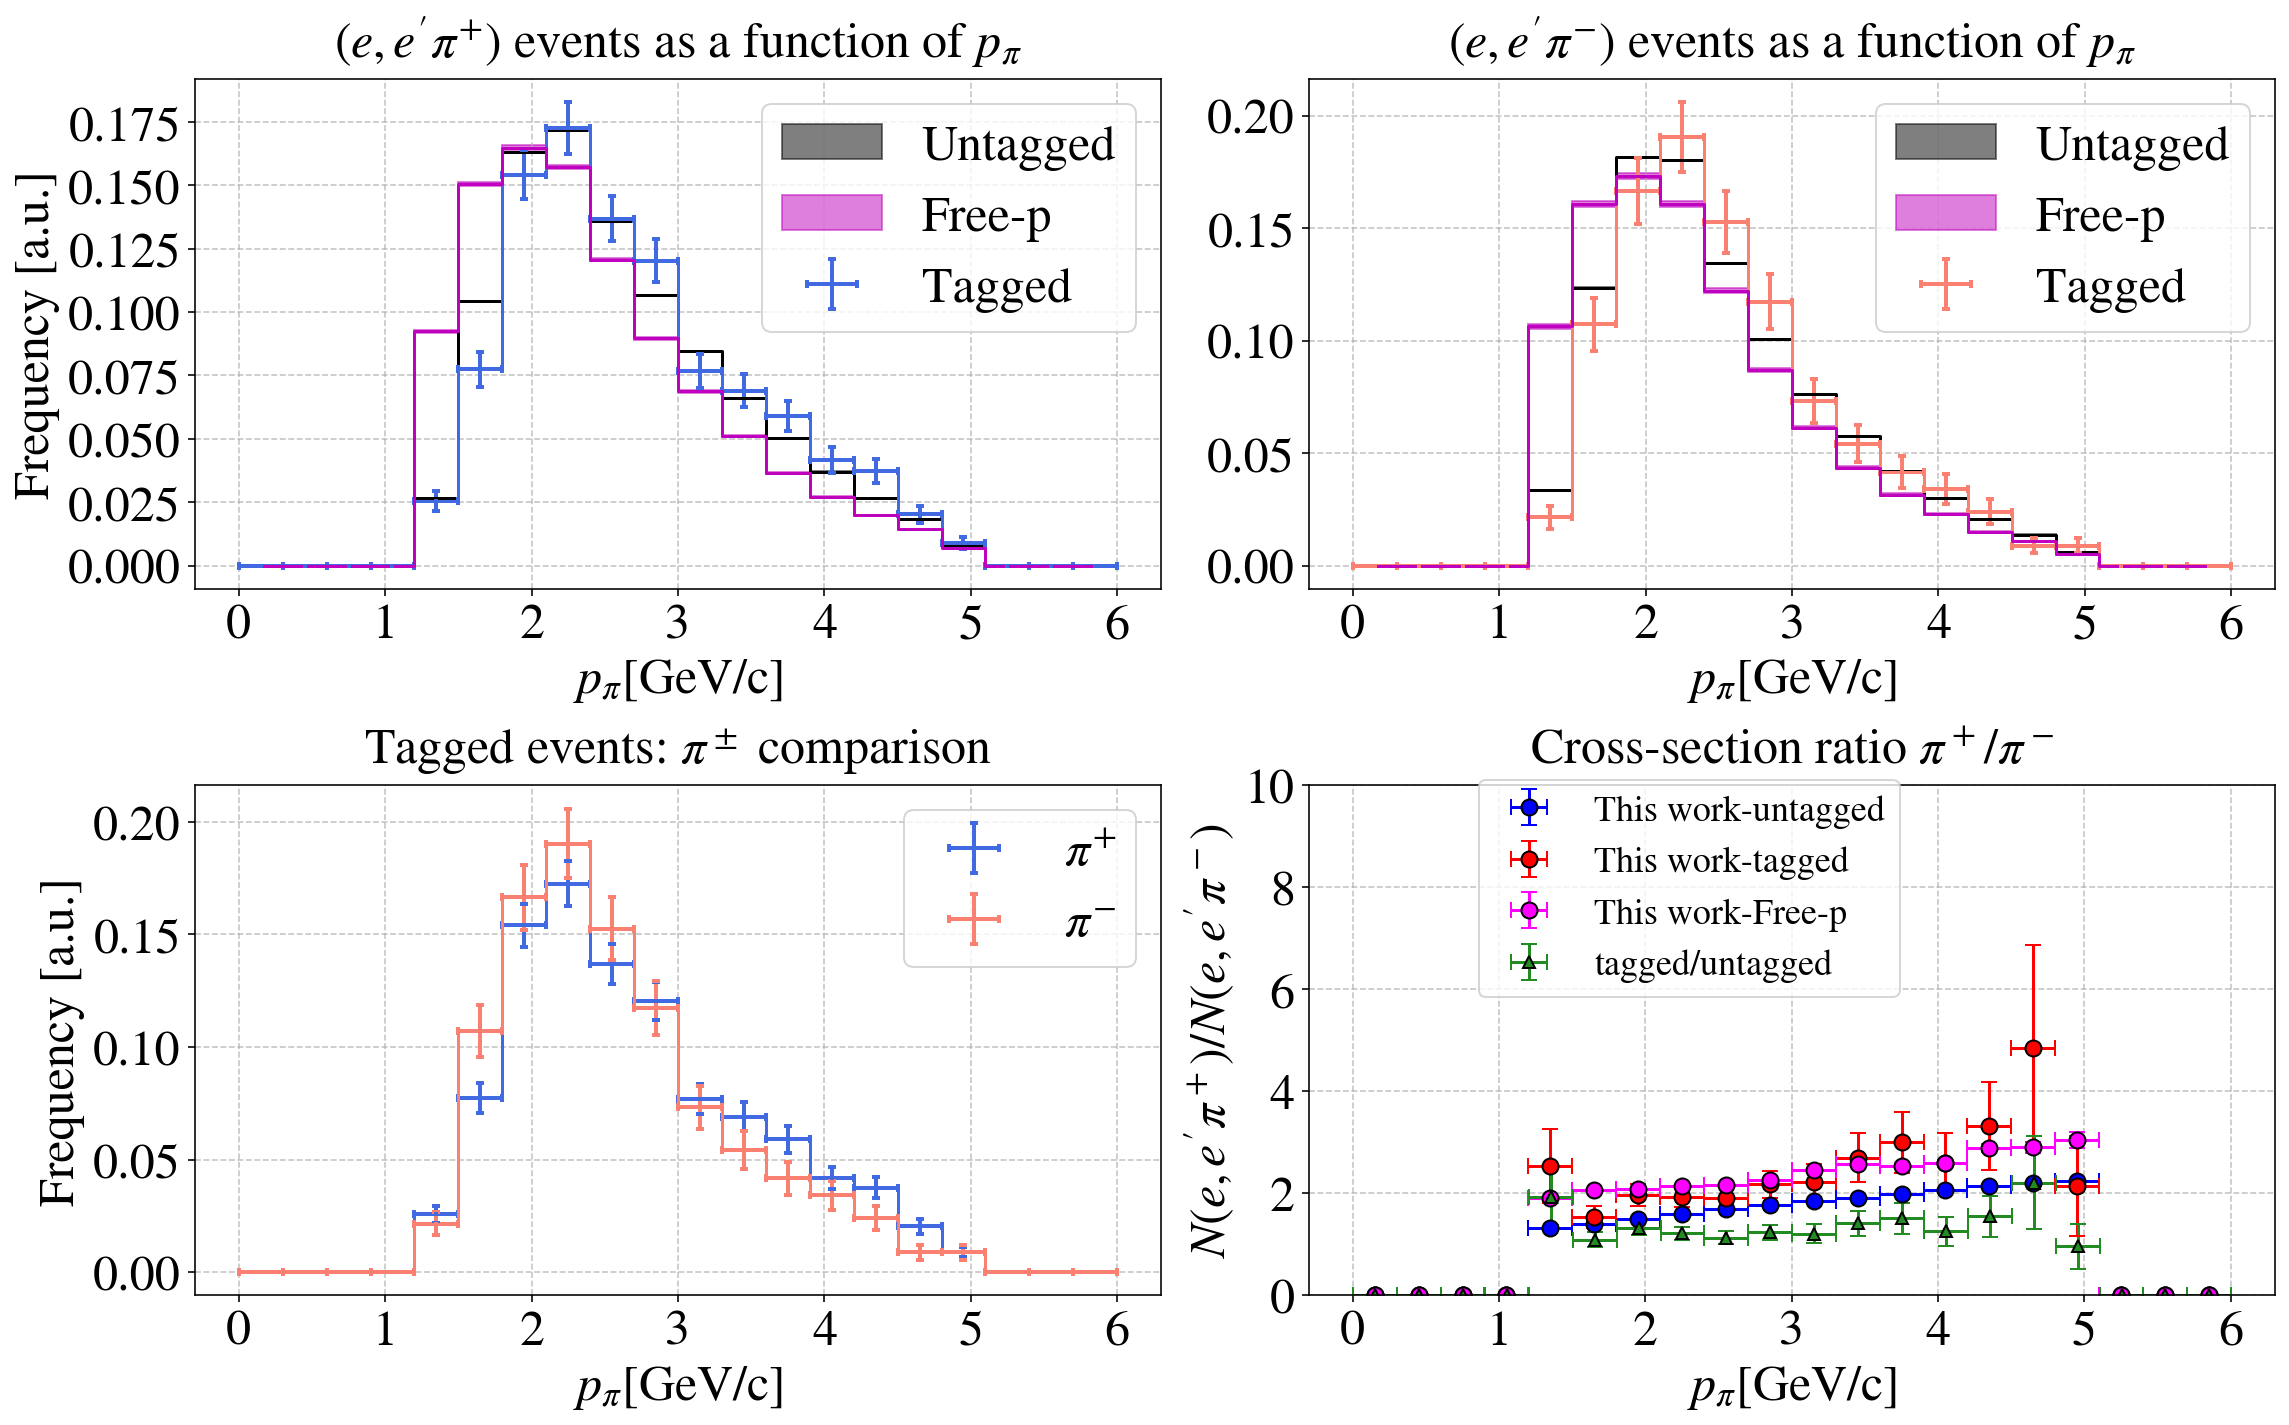

In [15]:
plot_SIDIS_variable(var  = 'pi_P',                    
                    bins = np.linspace(0,6,21),                    
                    varlabel = '$p_{\pi}$', 
                    varunits = '[GeV/c]');

### (3.5) rapidity 
$$\eta_\pi = 
\frac{1}{2}\ln{\frac{p^+}{p^-}}
=
\frac{1}{2}
\ln{\frac{E_\pi + \vec{p}_\pi \cdot \vec{q}}
{E_\pi - \vec{p}_\pi \cdot \vec{q}}
}$$

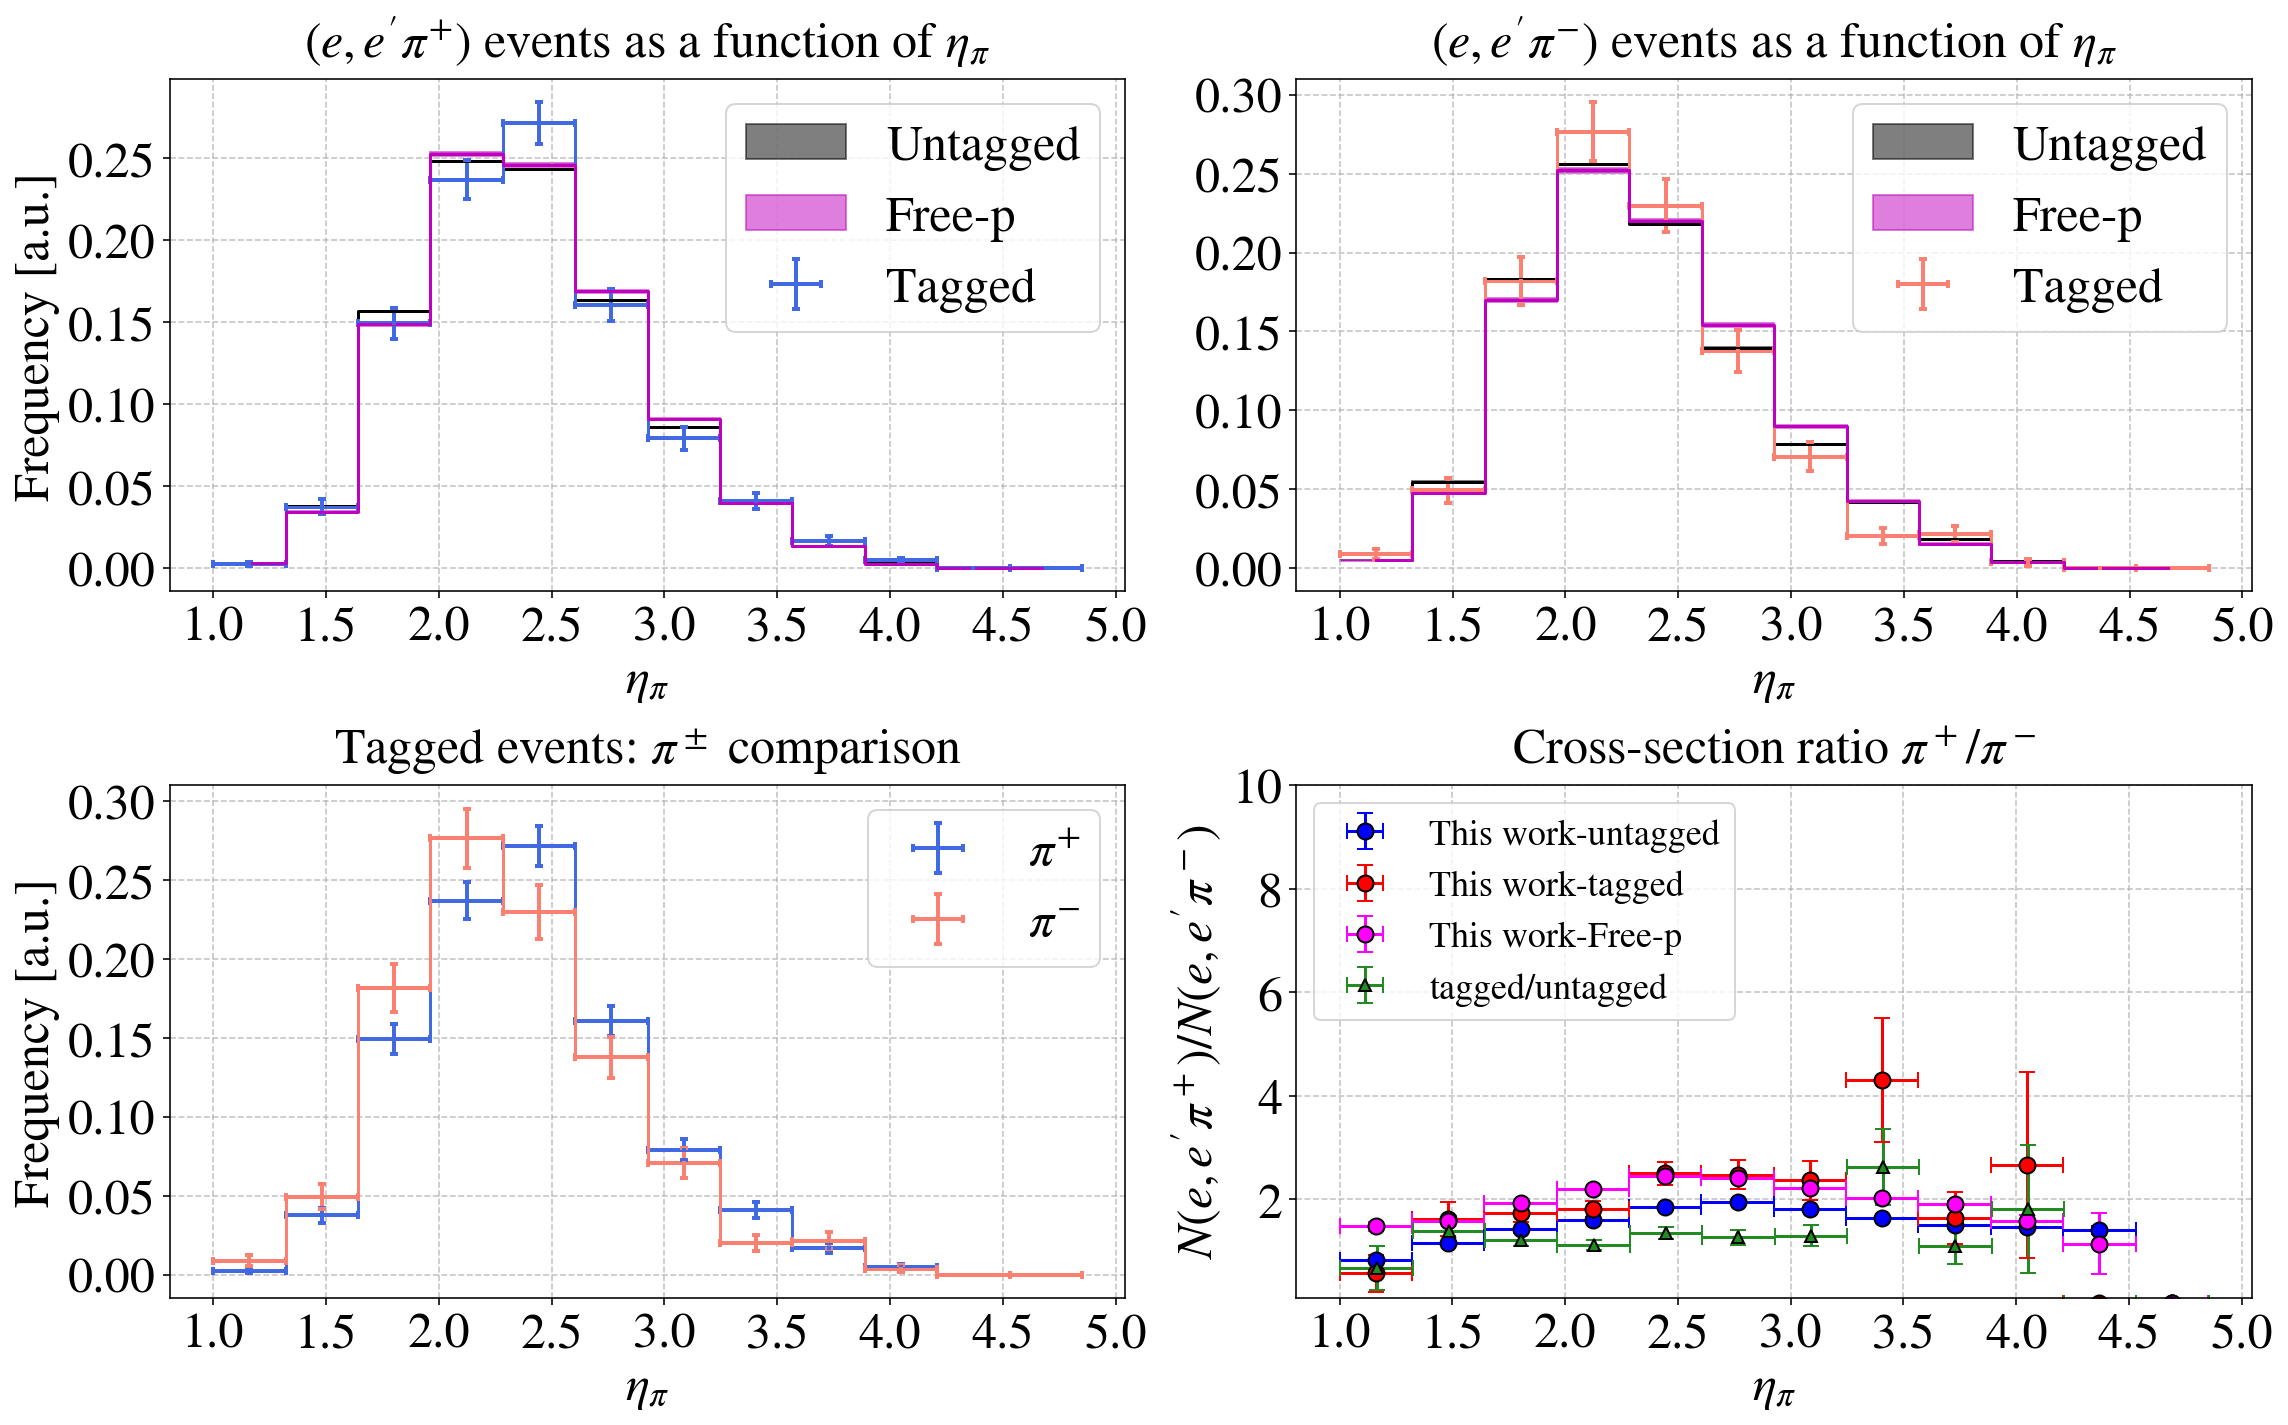

In [16]:
ax=plot_SIDIS_variable(var  = 'eta_pi',                    
                    bins = np.linspace(1.0,4.85,13),  
                    varlabel = '$\eta_{\pi}$',
                    varunits = '',ylim_ratio=(0.1,10));
ax[4].legend(loc='best',fontsize=18);

### (3.6) Feynman $x$

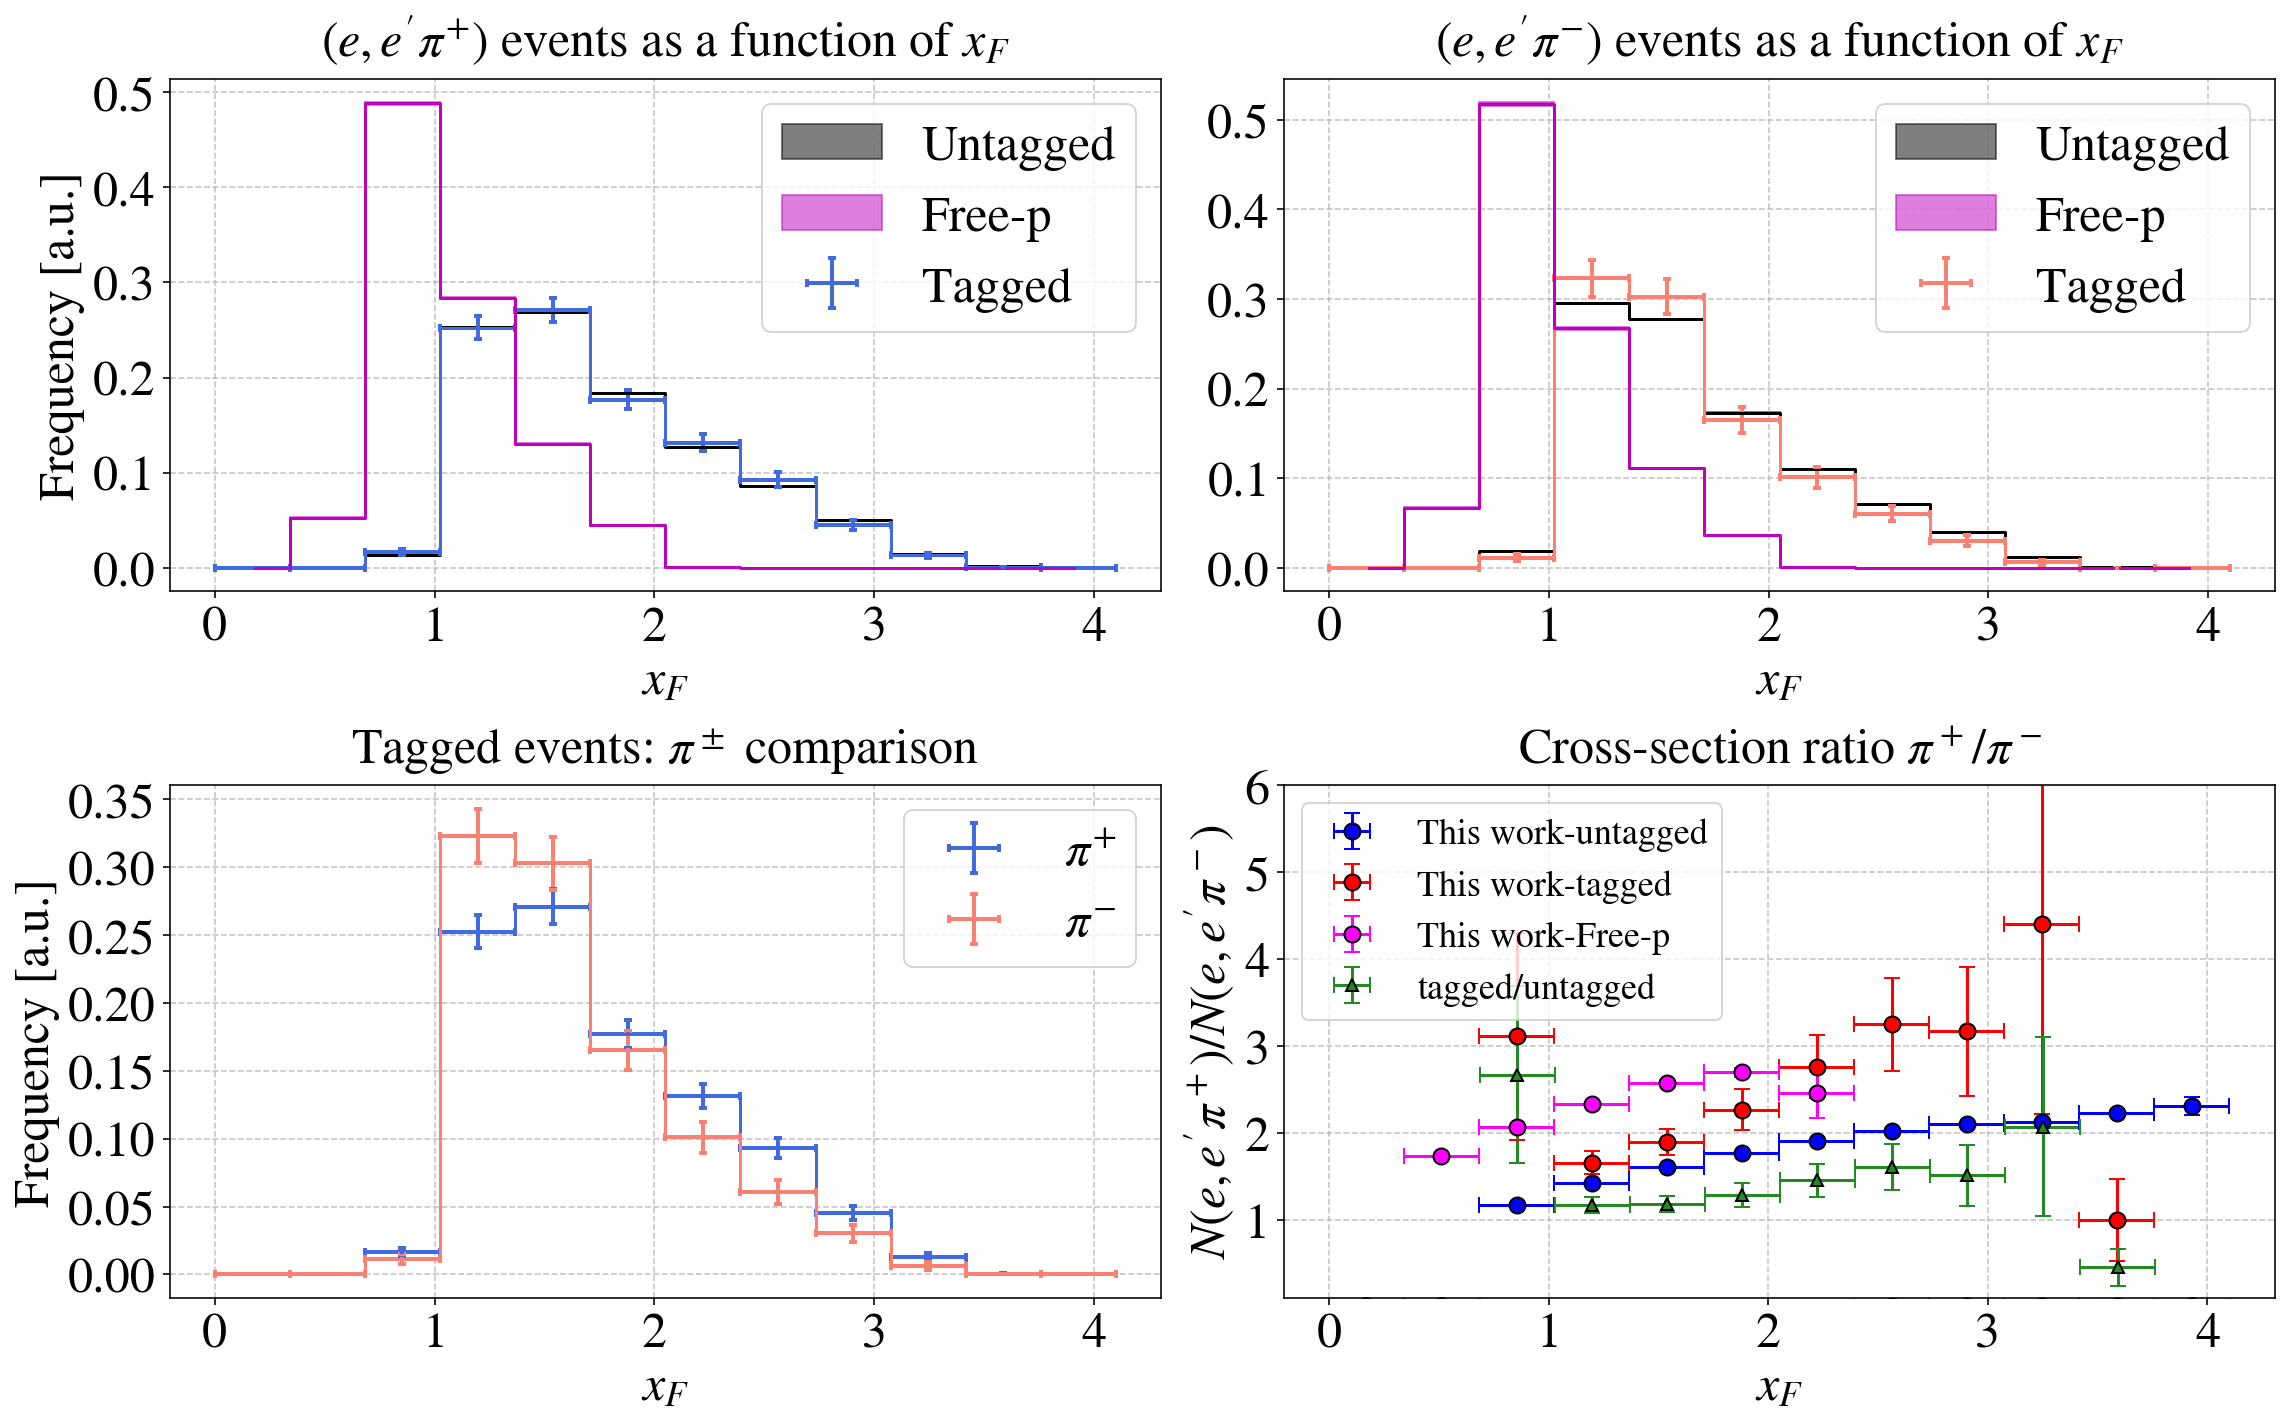

In [17]:
ax=plot_SIDIS_variable(var  = 'xF',                    
                    bins = np.linspace(.0,4.1,13),  
                    varlabel = '$x_{F}$',
                    varunits = '',ylim_ratio=(0.1,6.0));
ax[4].legend(loc='best',fontsize=18);

### (3.6) $p_T$ in the $q$-frame

In [52]:
def plot_pT_published_pips2pims_ratio( dataset = 'JLAB2012', 
                                      ax=None, 
                                      vars_2_plot=['R_H','R_D'],
                                      labels_2_plot=['Free-p','Deuteron'],
                                      colors=['red','blue'],
                                      markers=['s','s'] ):
    '''
    plot pT published pips2pims ratio
    
    
    input
    ---------
    vars_2_plot    'R_H'  / 'R_D' / [...]
    dataset        'JLAB2012' - Phys. Rev. C. 85 015202 (2012)
    
    '''
    
    if dataset == 'JLAB2012':
        dataset_label = 'JLAB2012'
    
    pT_data = pd.read_csv('/Users/erezcohen/Desktop/data/BAND/ExistingData/'+dataset+'/pT_data.csv')
    pT_data['p_T'] = np.sqrt(pT_data['P_t^2 (GeVc^2)'])
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(8,5))
        set_axes(ax,'$p_T$','$R_H$',do_add_grid=True)
    
    for var_2_plot,label_2_plot,color,marker in zip(vars_2_plot,labels_2_plot,colors,markers):
        ax.errorbar( pT_data['p_T'], 
                    pT_data[var_2_plot], pT_data['d '+var_2_plot], 
                    linestyle='None',
                    marker=marker,color=color,
                    capthick=1,capsize=4,
                    markerfacecolor='w',
                    label = label_2_plot+' '+dataset_label
                   )
    
    

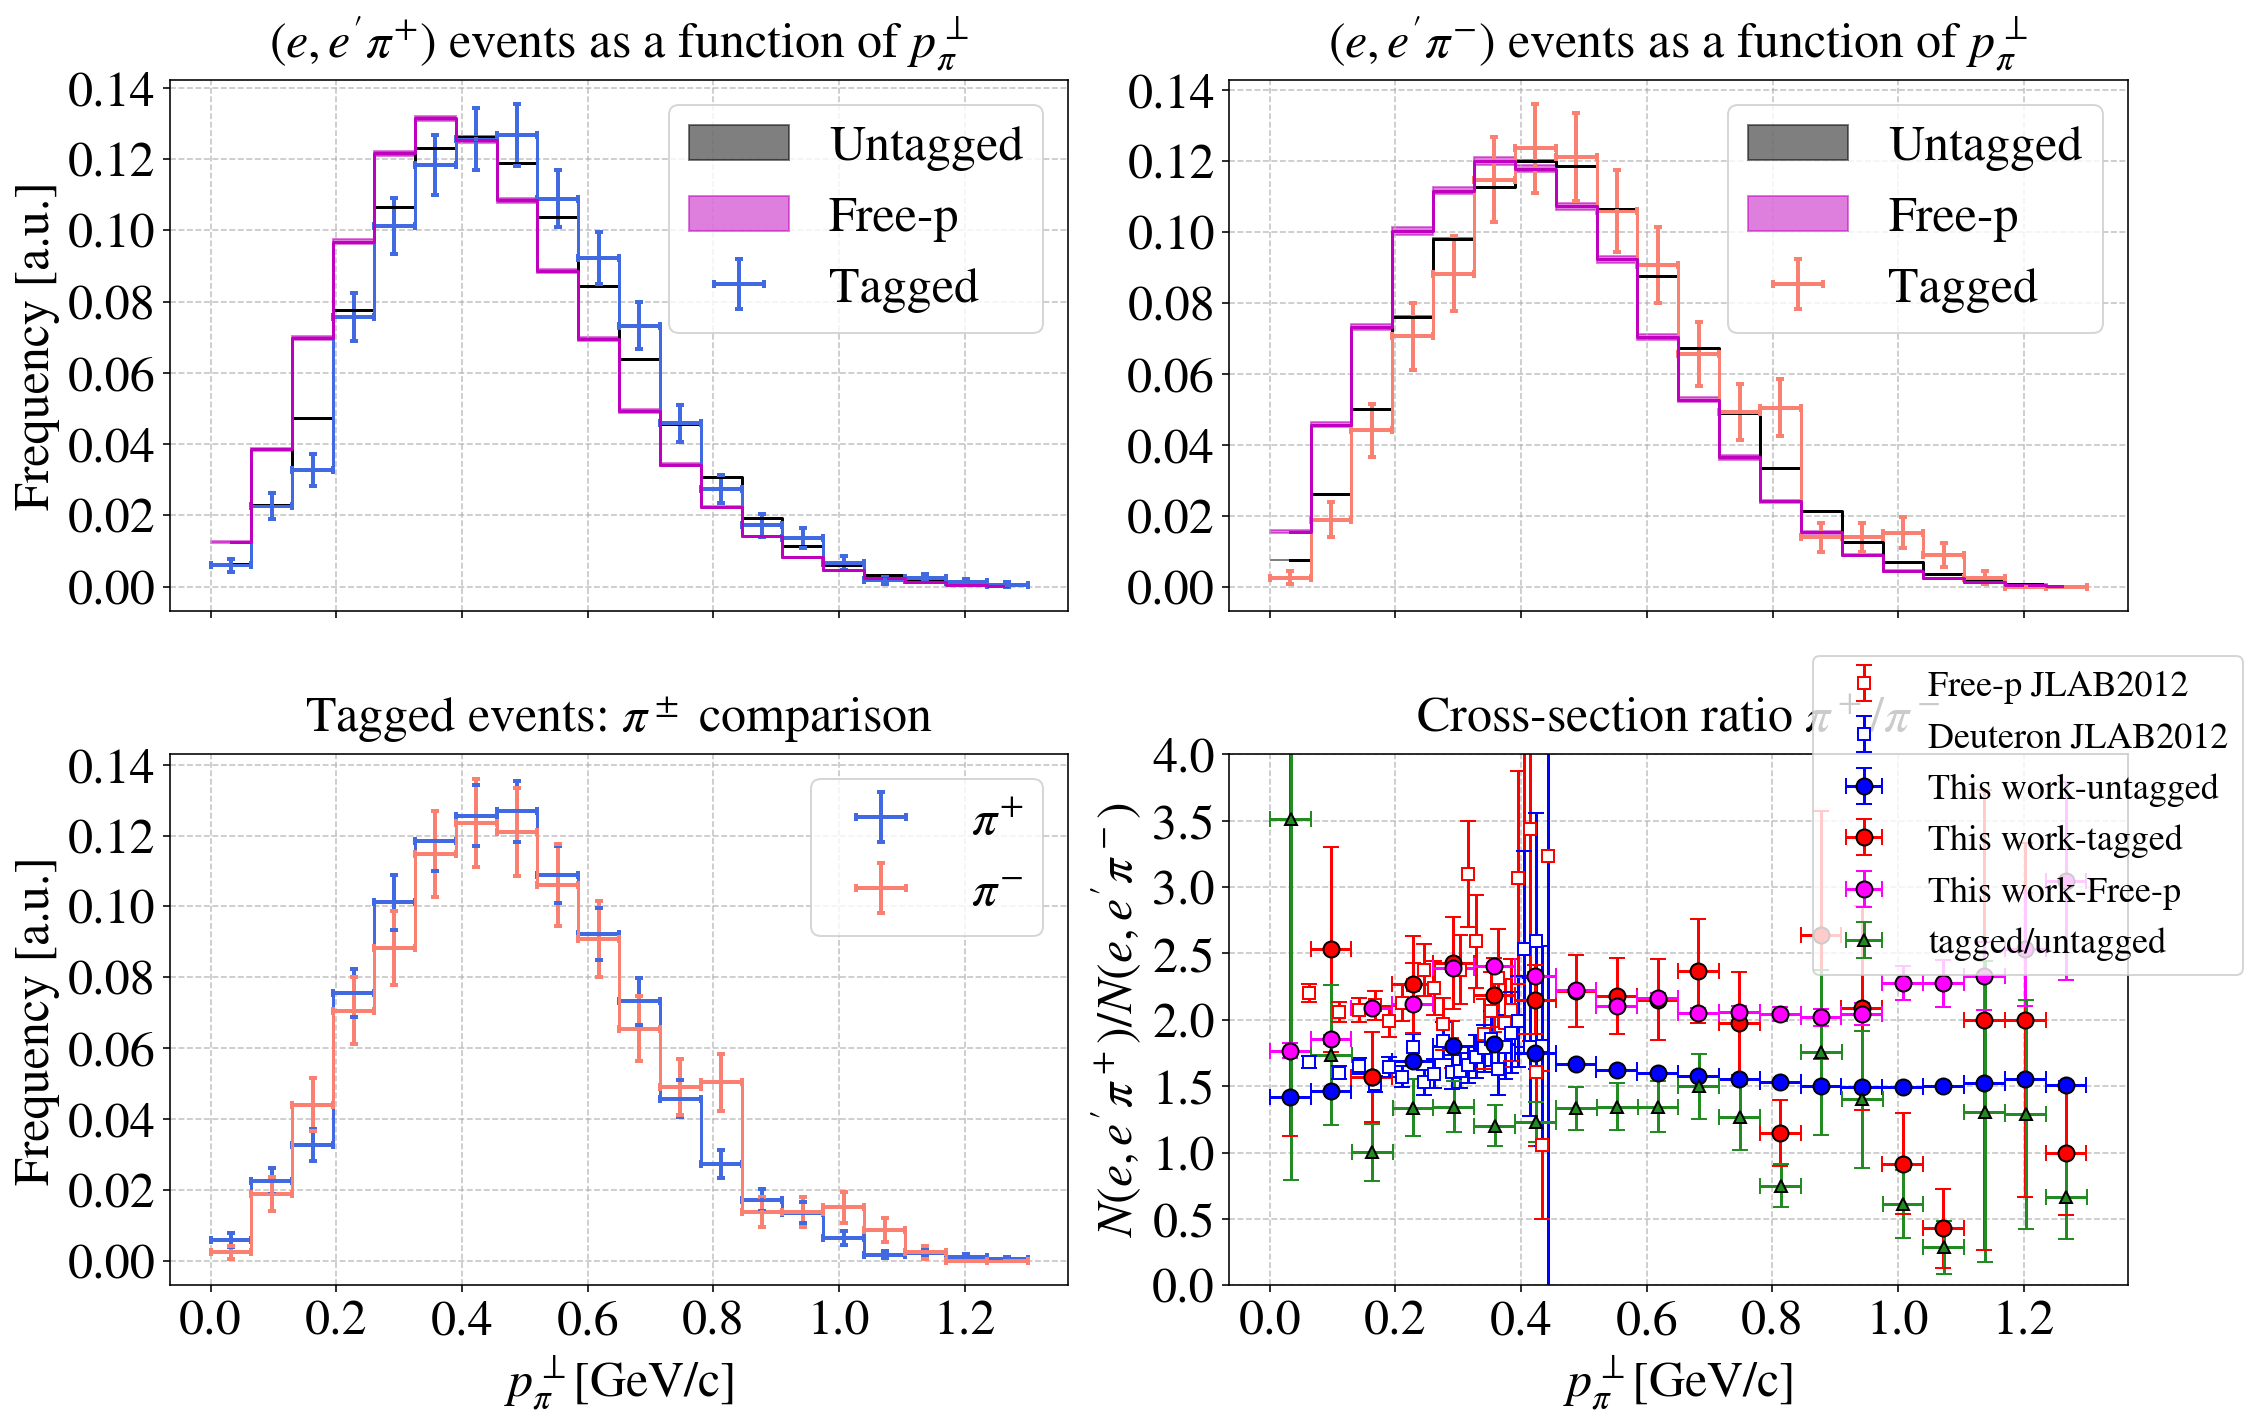

In [55]:
ax = plot_SIDIS_variable(var  = 'pi_qFrame_pT',                    
                    bins = np.linspace(0,1.3,21),                    
                    varlabel = '$p_{\pi}^{\perp}$', 
                    varunits = '[GeV/c]', 
                         add_published_pips2pims_ratio = ['JLAB2012'], ylim_ratio=(0,4) )
# ax[4].legend(loc=(0.4,0.45),fontsize=17);


### (3.6.1) $\phi$ in the virtual photon frame

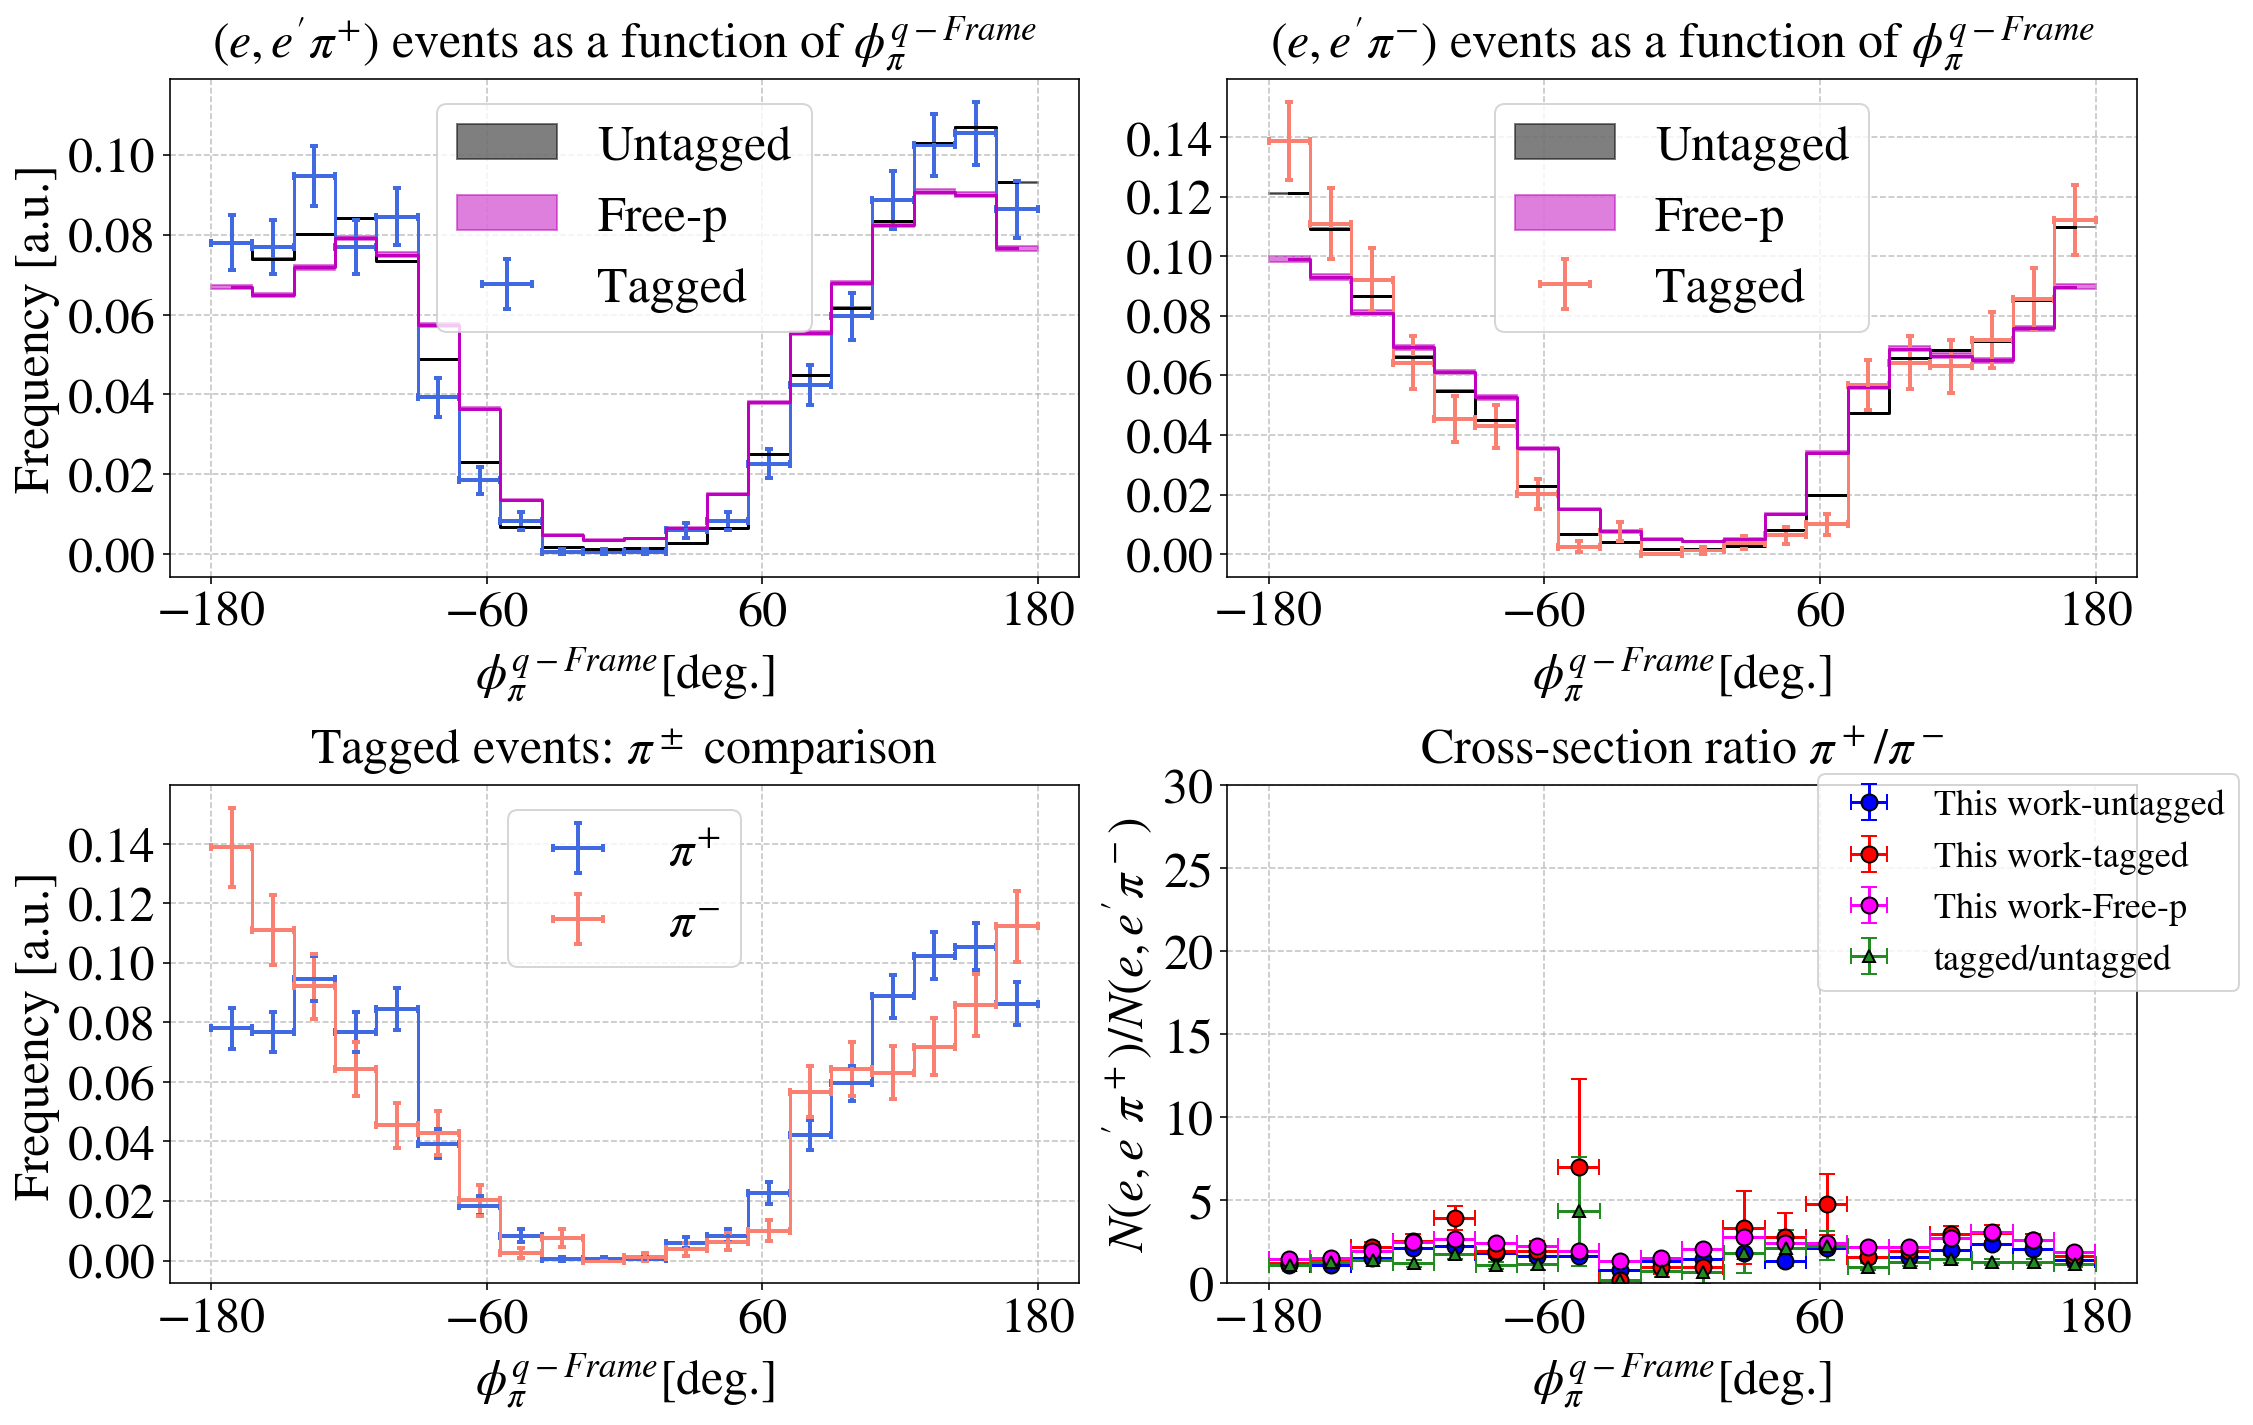

In [20]:
plot_SIDIS_variable(var  = 'pi_qFrame_Phi',       
                    xScaling=r2d,
                    bins = np.linspace(-180,180,21),
                    varlabel = "$\phi_{\pi}^{q-Frame}$", 
                    varunits = '[deg.]',ylim_ratio=(0,30),
                    xticks=[-180,-60,60,180]);

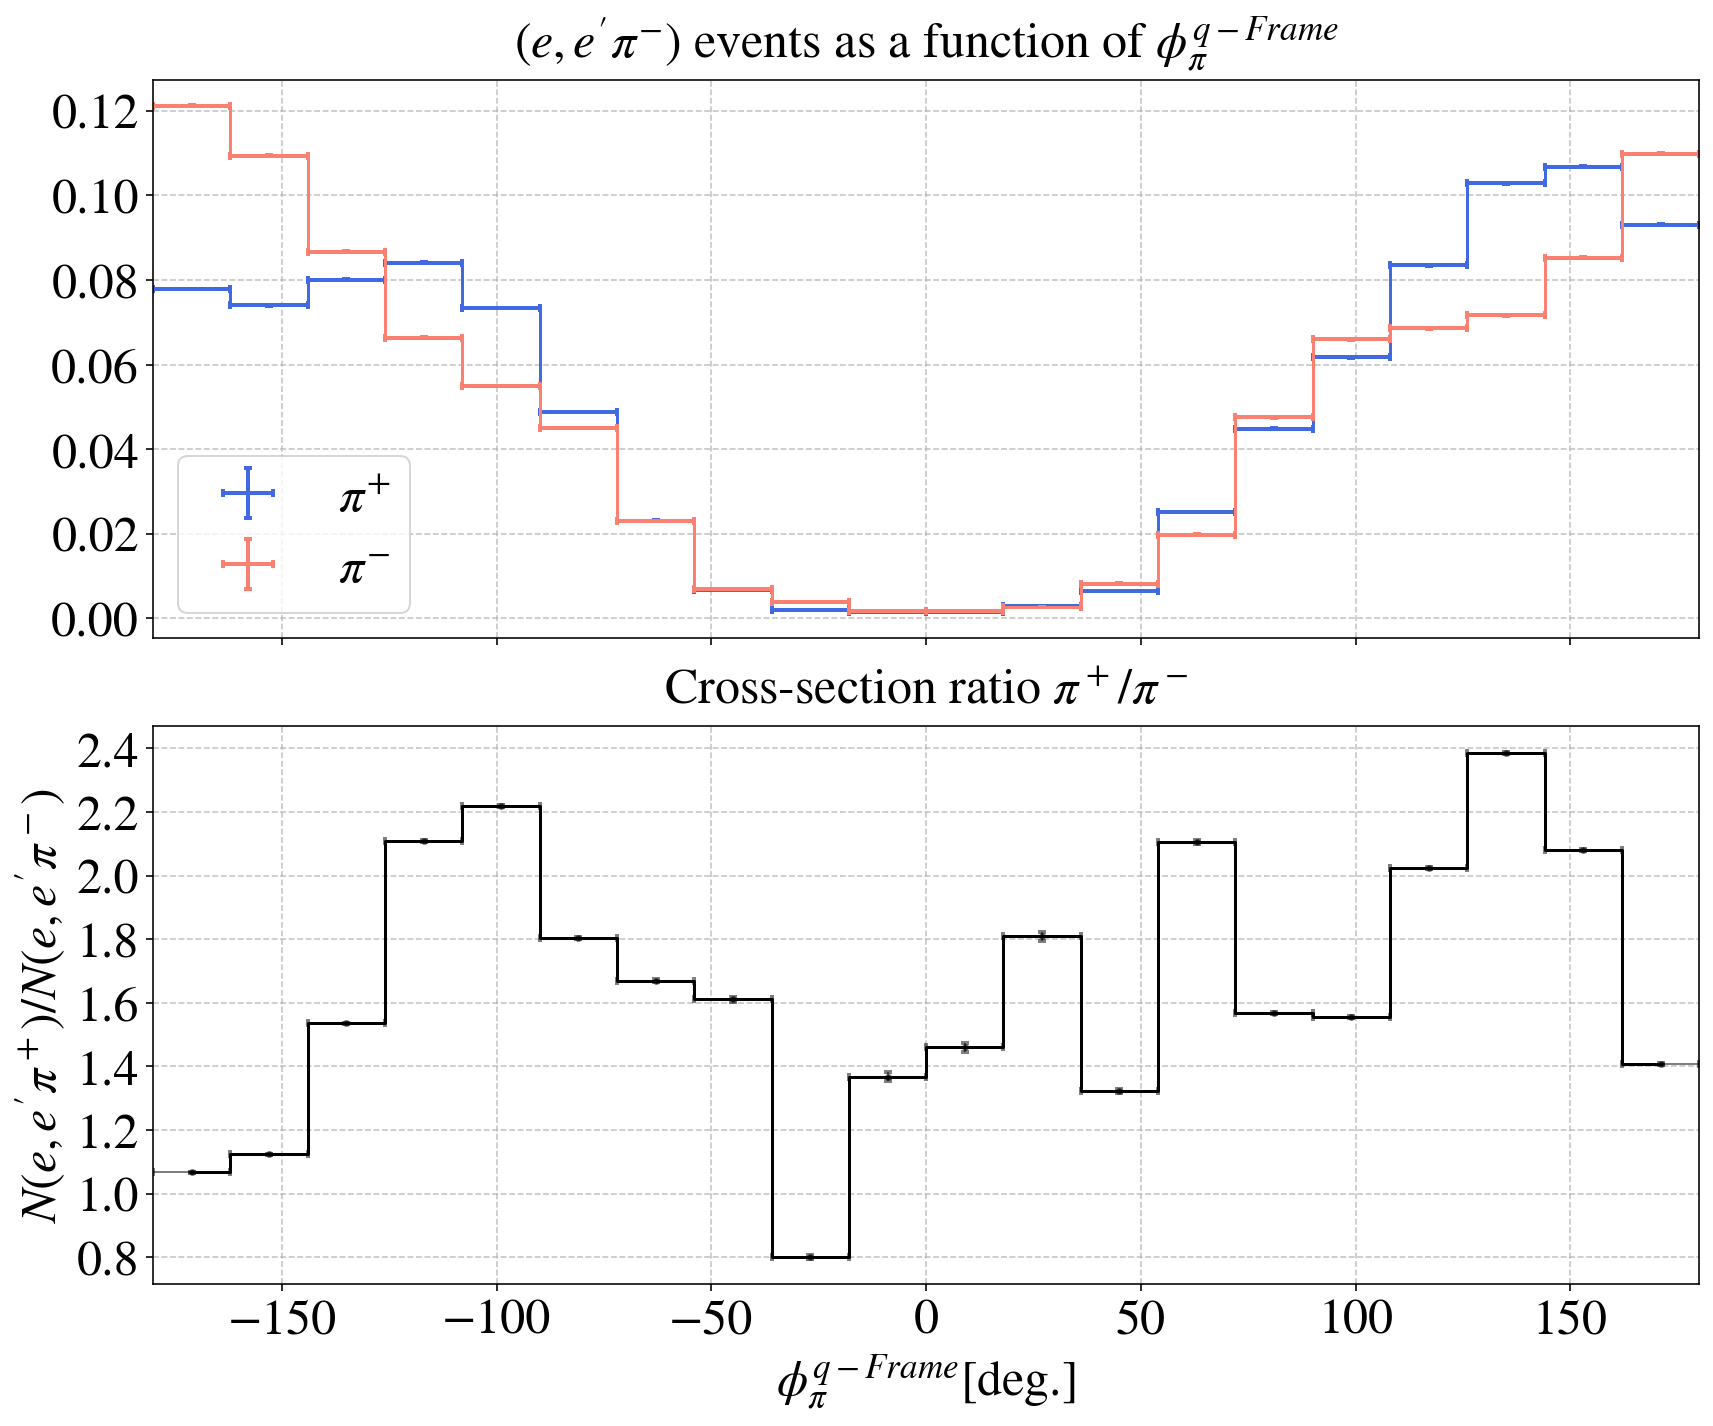

In [21]:
var      = 'pi_qFrame_Phi'
varlabel = "$\phi_{\pi}^{q-Frame}$"
varunits = "[deg.]"

bins = np.linspace(-180,180,21)
xlim = (-180,180)
xticks = None

fig = plt.figure(figsize=(12,10),tight_layout=True)
h,NeventsTot = dict(),dict()
# compare untagged to tagged seperately for π+ and π-
ax = fig.add_subplot(2,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    
    df = e_e_pi_pass_cuts[pi_ch]
    NeventsTot['untagged'] = len(df)
    x,h['untagged'+pi_ch],x_err,h_err['untagged'+pi_ch] = plot_step_hist( df[var], xScaling=r2d,
                                                                         bins=bins, 
                                                                         marker='s', 
                                                                         markersize=1, 
                                                                         color=pi_color,
                                                                         label='$'+pi_label+'$', 
                                                                         alpha=1, density=True)
    
set_axes(ax,'', 'Frequency [a.u.]' if pi_idx==1 else '', 
         remove_ticks_x=True,
             title="$(e,e'"+pi_label+")$ events as a function of "+varlabel,
             do_add_grid=True, do_add_legend=True,xticks=xticks, xlim=xlim)

# Take the ratio of π+/π-
ax = fig.add_subplot(2,1,2)
datalabel='untagged'
color='k'
scaleFactor = Stats["$d(e,e'\\pi^{+})/d(e,e'\\pi^{-})$"]
R = np.zeros(len(x))
R_err = np.zeros(len(x))
cutoff = 1./NeventsTot[datalabel]
for i in range(len(h_err[datalabel+'piminus'])):
    R[i] = (h[datalabel+'piplus'][i]/np.max([cutoff,h[datalabel+'piminus'][i]])) * scaleFactor
    R_err[i] = R[i] * np.sqrt(  np.square(h_err[datalabel+'piplus'][i]/np.max([cutoff,h[datalabel+'piplus'][i]]) ) 
                              + np.square(h_err[datalabel+'piminus'][i]/np.max([cutoff,h[datalabel+'piminus'][i]])) )    
plt.step ( x, R, color=color, where='mid', label=None )
plt.errorbar ( x=x, xerr=x_err, y=R, yerr=R_err, markersize=5,
              color=color, marker='.', linestyle='None',label=datalabel,
              capsize=2, capthick=2, linewidth=1, alpha=0.5 )
#}
set_axes(ax,varlabel+varunits,
         "$N(e,e' \pi^+) / N(e,e' \pi^-)$", 
         title="Cross-section ratio $\pi^+/\pi^-$",
         do_add_grid=True, do_add_legend=False,xticks=xticks, xlim=xlim);   

### (3.7) $p_T$  in bins of $x_B$ and $z$
For untagged data in bins of x and z
For tagged data in 2-3 large bins

In [22]:
import scipy as sp
from scipy.stats import chi

def fit_function_pT( x, mu_Px=0, sigma_Px=0.2 ):
    '''
    The Chi distribution is the positive square root of the sum of squares of independent random variables,
    each following a standard normal distribution:
    
        Z = sqrt(X_1^2 + X_2^2 + X_3^2 + X_4^2 + .....)
    
    For k=2, this is the function that represents the distribution of 
    
        p_T = \sqrt(Px^2 + Py^2)
        
    where Px and Py are Gaussians,
    assuming mu_Py = mu_Px, and sigma_Py = sigma_Px.
    
    '''
    rv = chi(2, mu_Px, sigma_Px)    
    y_fit = rv.pdf(x)
    y_fit_normed = y_fit/np.sum(y_fit)
    return y_fit_normed


def fit_pT( x, y, y_err, fdebug=0, do_plot_fit=False, color='k' ):
    '''
    return 
    -------
    fit_results     dict
    '''
    
    fit_results = dict()
    if np.max(y)>0:
        popt,pcov=sp.optimize.curve_fit(fit_function_pT, xdata=x, ydata=y, p0=[np.mean(x[x<0.5]),np.std(x)], ) # sigma=y_err, 
        mu_fit  = popt[0]
        mu_err  = np.sqrt(pcov[0,0])
        if mu_err ==np.inf: mu_err  = np.max([mu_fit ,0.01])
        sig_fit = popt[1]
        sig_err = np.sqrt(pcov[1,1])
        if sig_err==np.inf: sig_err = np.max([sig_fit ,0.01])
    else:
        mu_fit,mu_err,sig_fit,sig_err = 0,0,0,0

    fit_results['mu_fit'] = mu_fit
    fit_results['mu_err'] = mu_err
    fit_results['sig_fit'] = sig_fit
    fit_results['sig_err'] = sig_err
    
    if fdebug>1:
        print(mu_fit , mu_err)
        print(sig_fit, sig_err)
        
    if do_plot_fit:
        x_fit = np.linspace(np.min(x),np.max(x),100)
        plt.plot( x_fit, fit_function_pT( x_fit, mu_fit , sig_fit )*len(x_fit)/len(x), '--', color=color );
    return fit_results

#### Untagged data

In [23]:
z_bins   = np.linspace(0.35,0.80,4)
z_widths = 0.01*np.ones(len(z_bins))
x_bins   = np.linspace(0.2,0.5,4)
x_widths = (x_bins[1] - x_bins[0])/2*np.ones(len(z_bins))
for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(len(z_bins))):
    z_min,z_max = z_bin-z_width, z_bin+z_width
    print('%d, %.3f < z < %.3f'%(z_idx,z_min,z_max))
print('')    
for x_bin,x_width,x_idx in zip(x_bins,x_widths,range(len(x_bins))):
    x_min,x_max = x_bin-x_width, x_bin+x_width
    print('%d, %.3f < x < %.3f'%(x_idx,x_min,x_max))    
N_x = len(x_bins)
N_z = len(z_bins)    
# print('x bins:',x_bins)
# print('x_err:',x_err)
# print('x_widths:',x_widths)
# print('z bins:',z_bins)
# print('z width:',z_widths)

0, 0.340 < z < 0.360
1, 0.490 < z < 0.510
2, 0.640 < z < 0.660
3, 0.790 < z < 0.810

0, 0.150 < x < 0.250
1, 0.250 < x < 0.350
2, 0.350 < x < 0.450
3, 0.450 < x < 0.550


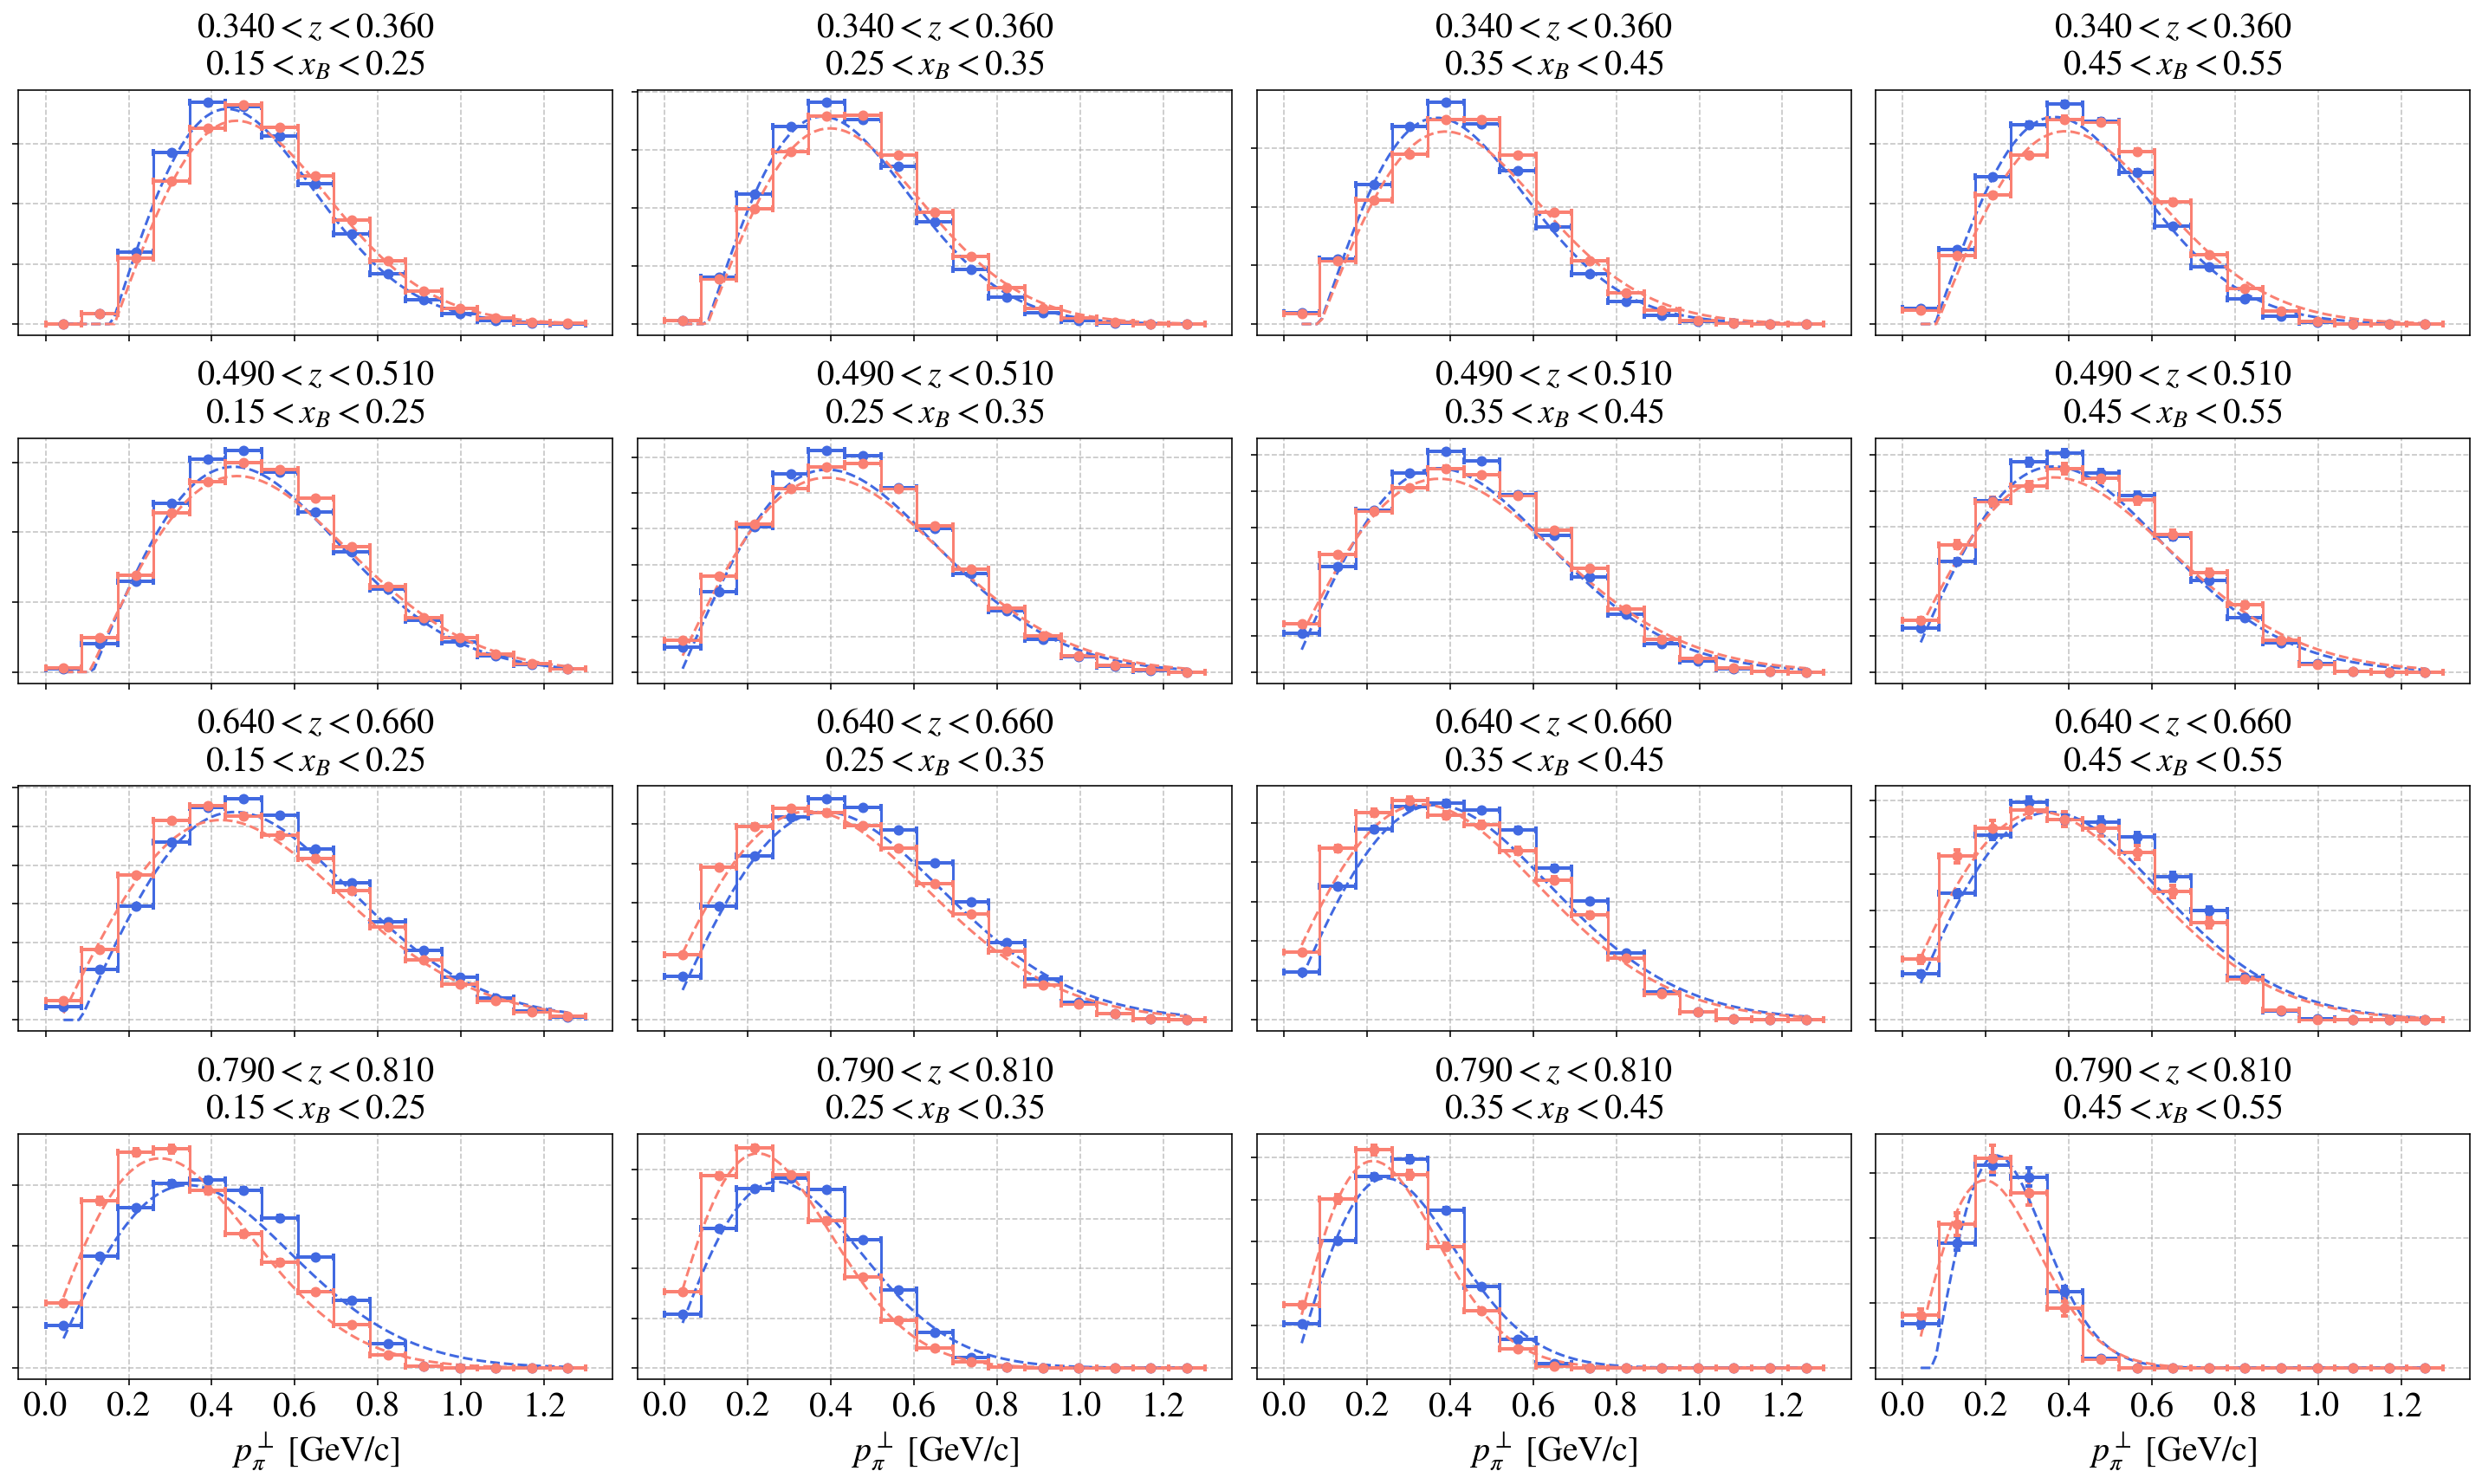

In [24]:
bins = np.linspace(0,1.3,16)
Nsubplots = 16
i = 0
mu_in_bin,sig_in_bin,sig_err_in_bin = np.zeros((N_z,N_x,2)),np.zeros((N_z,N_x,2)),np.zeros((N_z,N_x,2))

for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(N_z)):#{
    z_min,z_max = z_bin-z_width, z_bin+z_width

    # if i>25: break
    for x_bin,x_width,x_idx in zip(x_bins,x_widths,range(N_x)):
        x_min,x_max = x_bin-x_width, x_bin+x_width
        bin_label = "$%.3f < z < %.3f$"%(z_min,z_max) + "\n" + "$%.2f < x_B < %.2f$"%(x_min,x_max)
        
        if i%Nsubplots==0: fig = plt.figure(figsize=(20,12),tight_layout=True)
        # ax = fig.add_subplot( N_x,  N_z, z_idx + N_z*x_idx + 1 )
        ax = fig.add_subplot( int(np.sqrt(Nsubplots)), int(np.sqrt(Nsubplots)), np.mod(i,Nsubplots)+1 )
        for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

            df = e_e_pi_pass_cuts[pi_ch]
            # cut on xB and z
            df = df[  (z_min < df.Zpi) & (df.Zpi < z_max) 
                    & (x_min < df.xB ) & (df.xB  < x_max) ]
            # plot
            x,y,x_err,y_err = plot_step_hist( df["pi_qFrame_pT"], bins = bins, color=pi_color, density=True )
            
            # fit to a chi distribution function
            fit_results = fit_pT( x, y, y_err, 0, do_plot_fit=True,color=pi_color )
            mu_in_bin[z_idx,x_idx,pi_idx-1]     = fit_results['mu_fit']
            sig_in_bin[z_idx,x_idx,pi_idx-1]    = fit_results['sig_fit']
            sig_err_in_bin[z_idx,x_idx,pi_idx-1]= fit_results['sig_err']
                
        set_axes(ax,'$p_{\pi}^{\perp}$ [GeV/c]' if np.mod(i,Nsubplots)>=Nsubplots-np.sqrt(Nsubplots) else '',
                 '', # 'Frequency [a.u.]' if z_idx==0 else '', 
                 title= bin_label ,
                 fontsize=20,
                 remove_ticks_x = False if np.mod(i,Nsubplots)>=Nsubplots-np.sqrt(Nsubplots) else True,
                 remove_ticks_y = True,
                 do_add_grid=True, 
                 do_add_legend=False)
        i = i+1        
    #}    
#}

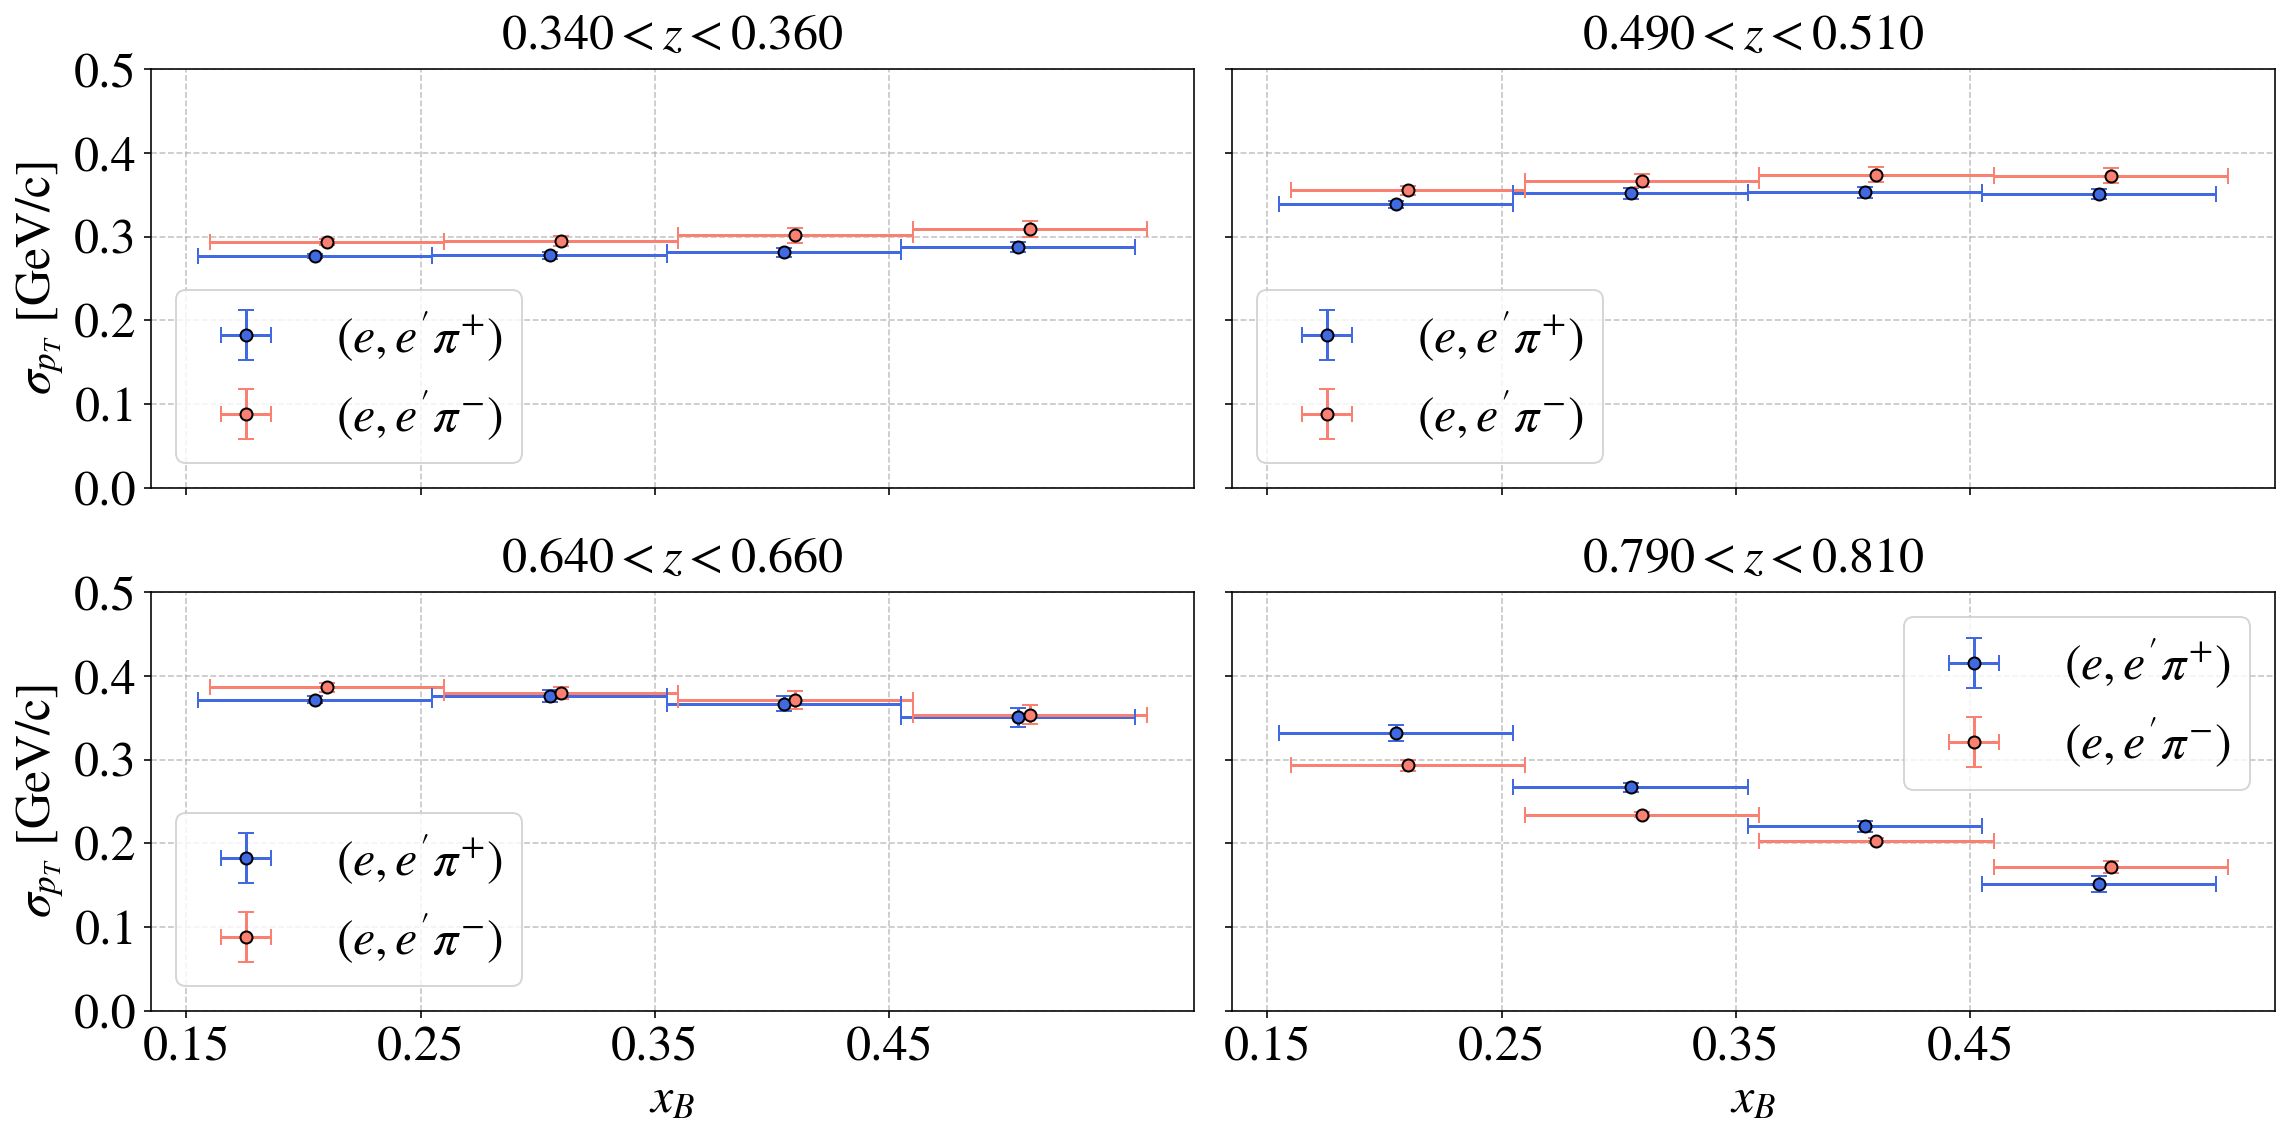

In [25]:
fig = plt.figure(figsize=(16,8),tight_layout=True)
for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(N_z)):#{
    z_min,z_max = z_bin-z_width, z_bin+z_width

    ax = fig.add_subplot( 2, 2, z_idx+1 )
    
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        sig_vs_x     = sig_in_bin[z_idx,:,pi_idx-1]
        sig_err_vs_x = sig_err_in_bin[z_idx,:,pi_idx-1]


        ax.errorbar(x=x_bins + 0.005*pi_idx*np.ones(len(x_bins)), 
                    xerr=x_widths,
                    y=sig_vs_x, 
                    yerr=sig_err_vs_x, 
                    color=pi_color,
                    capsize=4, marker='o', markeredgecolor='k', linestyle='None', 
                    label="$(e,e'"+pi_label+")$" )
        
    set_axes(ax,'$x_B$' if z_idx>=2 else '',
             '$\\sigma_{p_T}$ [GeV/c]' if np.mod(z_idx,2)==0 else '',
             remove_ticks_x=False if z_idx>=2 else True,
             remove_ticks_y=False if np.mod(z_idx,2)==0 else True,
             title="$%.3f < z < %.3f$"%(z_min,z_max) ,
             do_add_grid=True,do_add_legend=True, 
             xticks=np.arange(0.15,0.55,0.1),
             ylim=(0,0.5))


#### Tagged data

In [26]:
z_bins   = np.array([0.35,0.45,0.65])
z_widths = np.array([0.05,0.05,0.15])
x_bins   = np.array([0.2, 0.32, 0.44 ])
x_widths = (x_bins[1] - x_bins[0])/2*np.ones(len(z_bins))
for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(len(z_bins))):
    z_min,z_max = z_bin-z_width, z_bin+z_width
    print('%d, %.3f < z < %.3f'%(z_idx,z_min,z_max))
print('')    
for x_bin,x_width,x_idx in zip(x_bins,x_widths,range(len(x_bins))):
    x_min,x_max = x_bin-x_width, x_bin+x_width
    print('%d, %.3f < x < %.3f'%(x_idx,x_min,x_max))    
N_x = len(x_bins)
N_z = len(z_bins)    

0, 0.300 < z < 0.400
1, 0.400 < z < 0.500
2, 0.500 < z < 0.800

0, 0.140 < x < 0.260
1, 0.260 < x < 0.380
2, 0.380 < x < 0.500


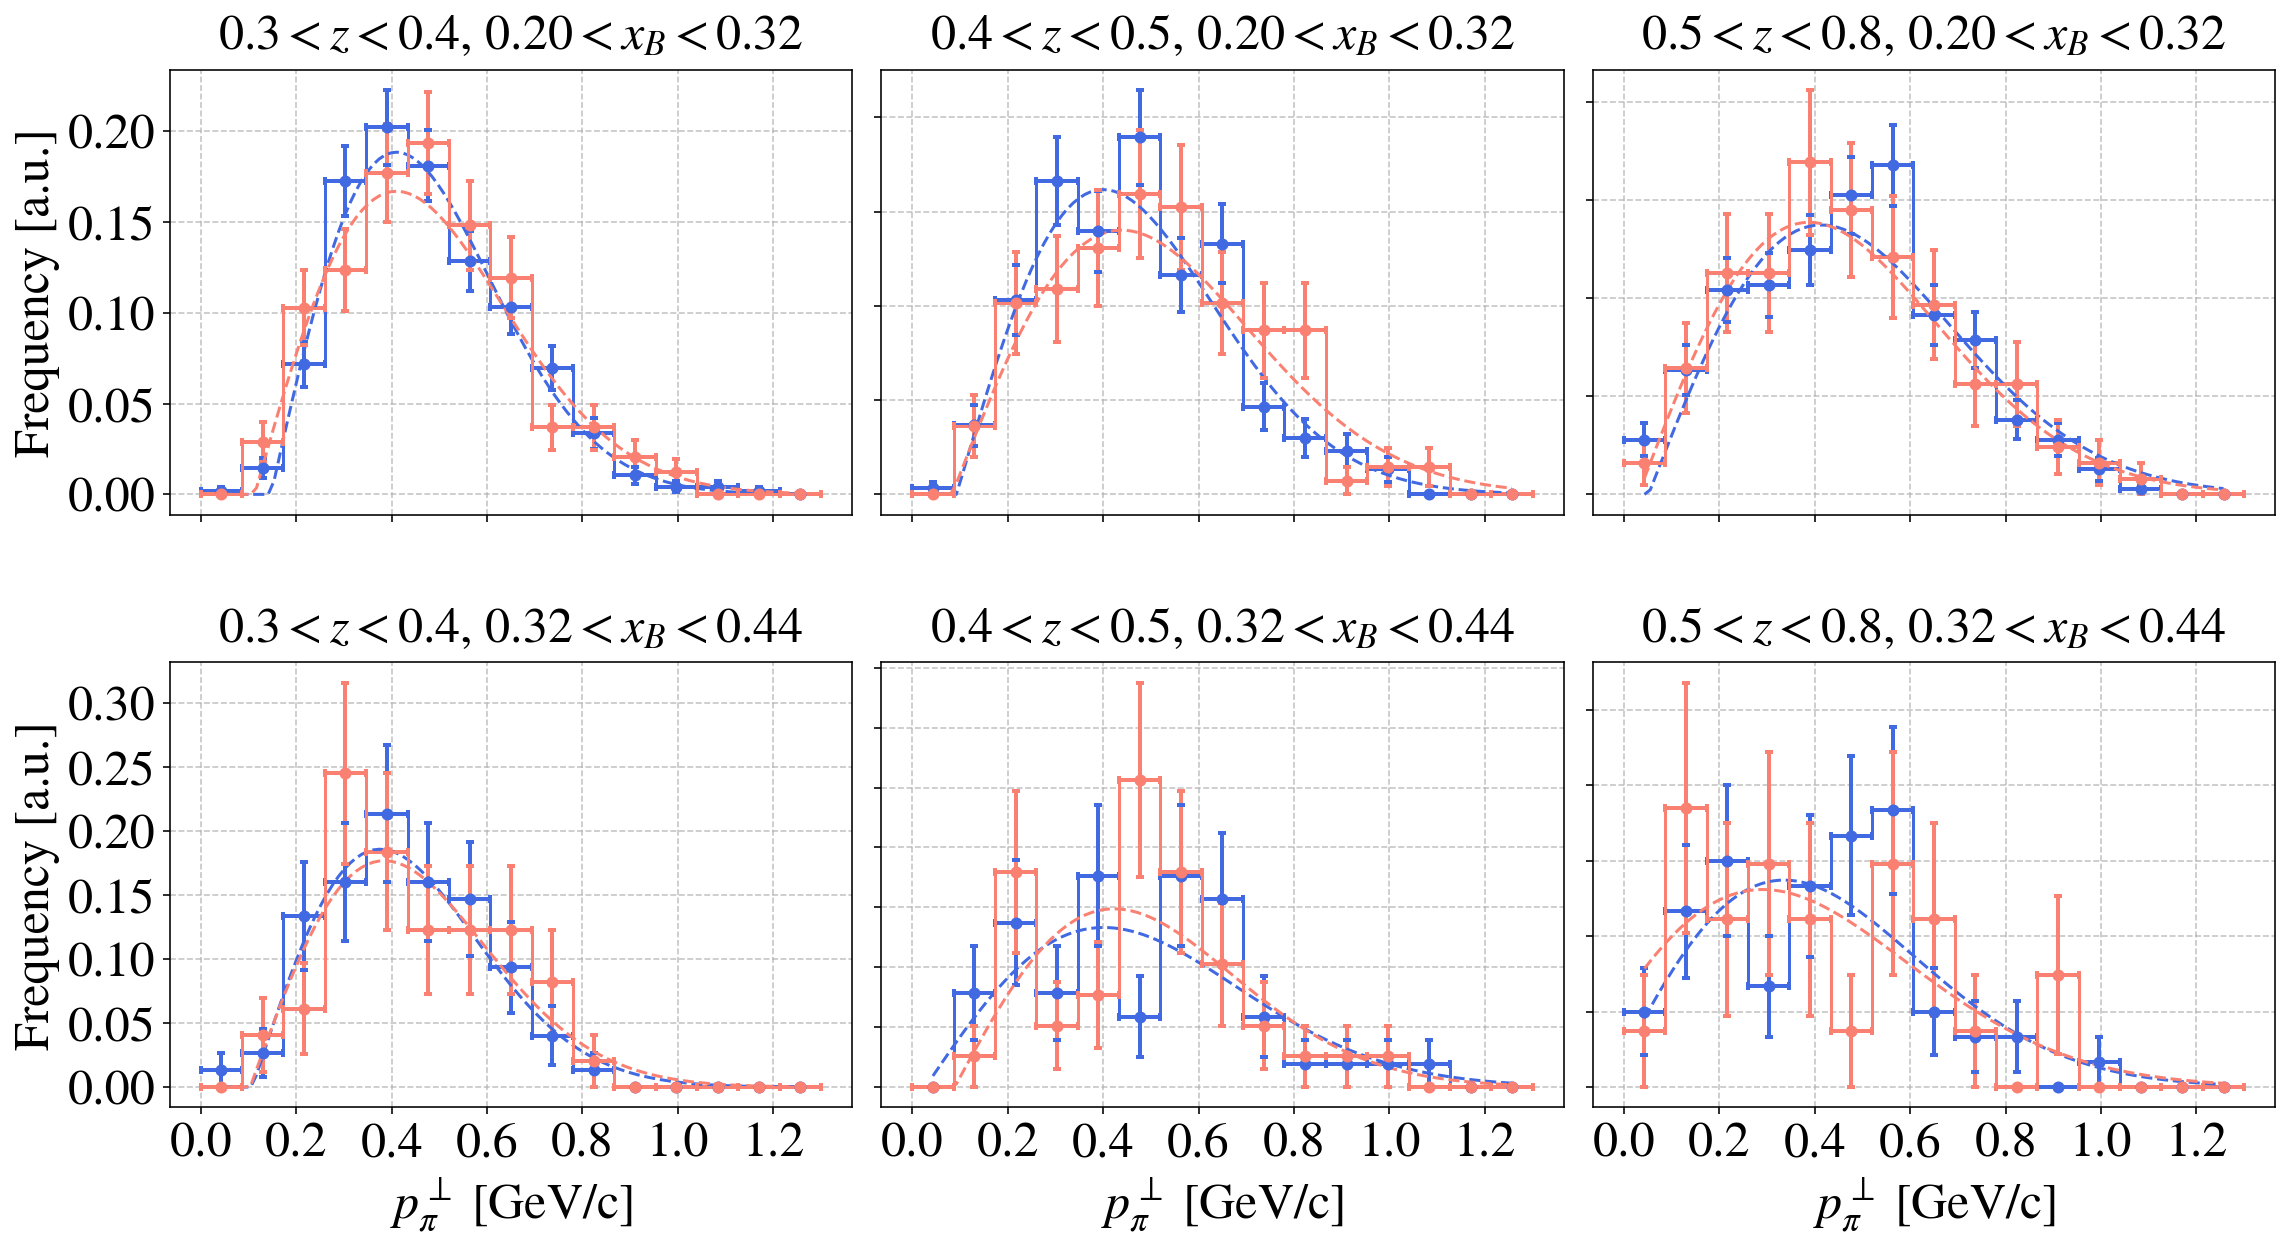

In [27]:
bins = np.linspace(0,1.3,16)

fig = plt.figure(figsize=(16,12),tight_layout=True)

mu_in_bin,sig_in_bin,sig_err_in_bin = np.zeros((N_z,N_x,2)),np.zeros((N_z,N_x,2)),np.zeros((N_z,N_x,2))
for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(N_z)):#{
    z_min,z_max = z_bin-z_width, z_bin+z_width

    for x_min,x_max,x_idx in zip(x_bins[:-1],x_bins[1:],range(N_x)):#{
        ax = fig.add_subplot( N_x,  N_z, z_idx + N_z*x_idx + 1 )
        for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

            df = e_e_pi_n_pass_cuts[pi_ch]
            # cut on xB and z
            df = df[  (z_min < df.Zpi) & (df.Zpi < z_max) 
                    & (x_min < df.xB ) & (df.xB  < x_max) ]
            # plot
            x,y,x_err,y_err = plot_step_hist( df["pi_qFrame_pT"], bins = bins, color=pi_color, density=True )
            
            # fit to a chi distribution function
            fit_results = fit_pT( x, y, y_err, 0, do_plot_fit=True,color=pi_color )
            mu_in_bin[z_idx,x_idx,pi_idx-1]     = fit_results['mu_fit']
            sig_in_bin[z_idx,x_idx,pi_idx-1]    = fit_results['sig_fit']
            sig_err_in_bin[z_idx,x_idx,pi_idx-1]= fit_results['sig_err']

            
        set_axes(ax,'$p_{\pi}^{\perp}$ [GeV/c]' if x_idx >= 1 else '',
                 'Frequency [a.u.]' if z_idx==0 else '', 
                 title= "$%.1f < z < %.1f$"%(z_min,z_max) + ", " + "$%.2f < x_B < %.2f$"%(x_min,x_max) ,
                 remove_ticks_x = False if x_idx >= 1 else True,
                 remove_ticks_y = False if z_idx%N_z==0 else  True,
                 do_add_grid=True, 
                 do_add_legend=False if z_idx==0 and x_idx==1 else False)
    #}    
#}

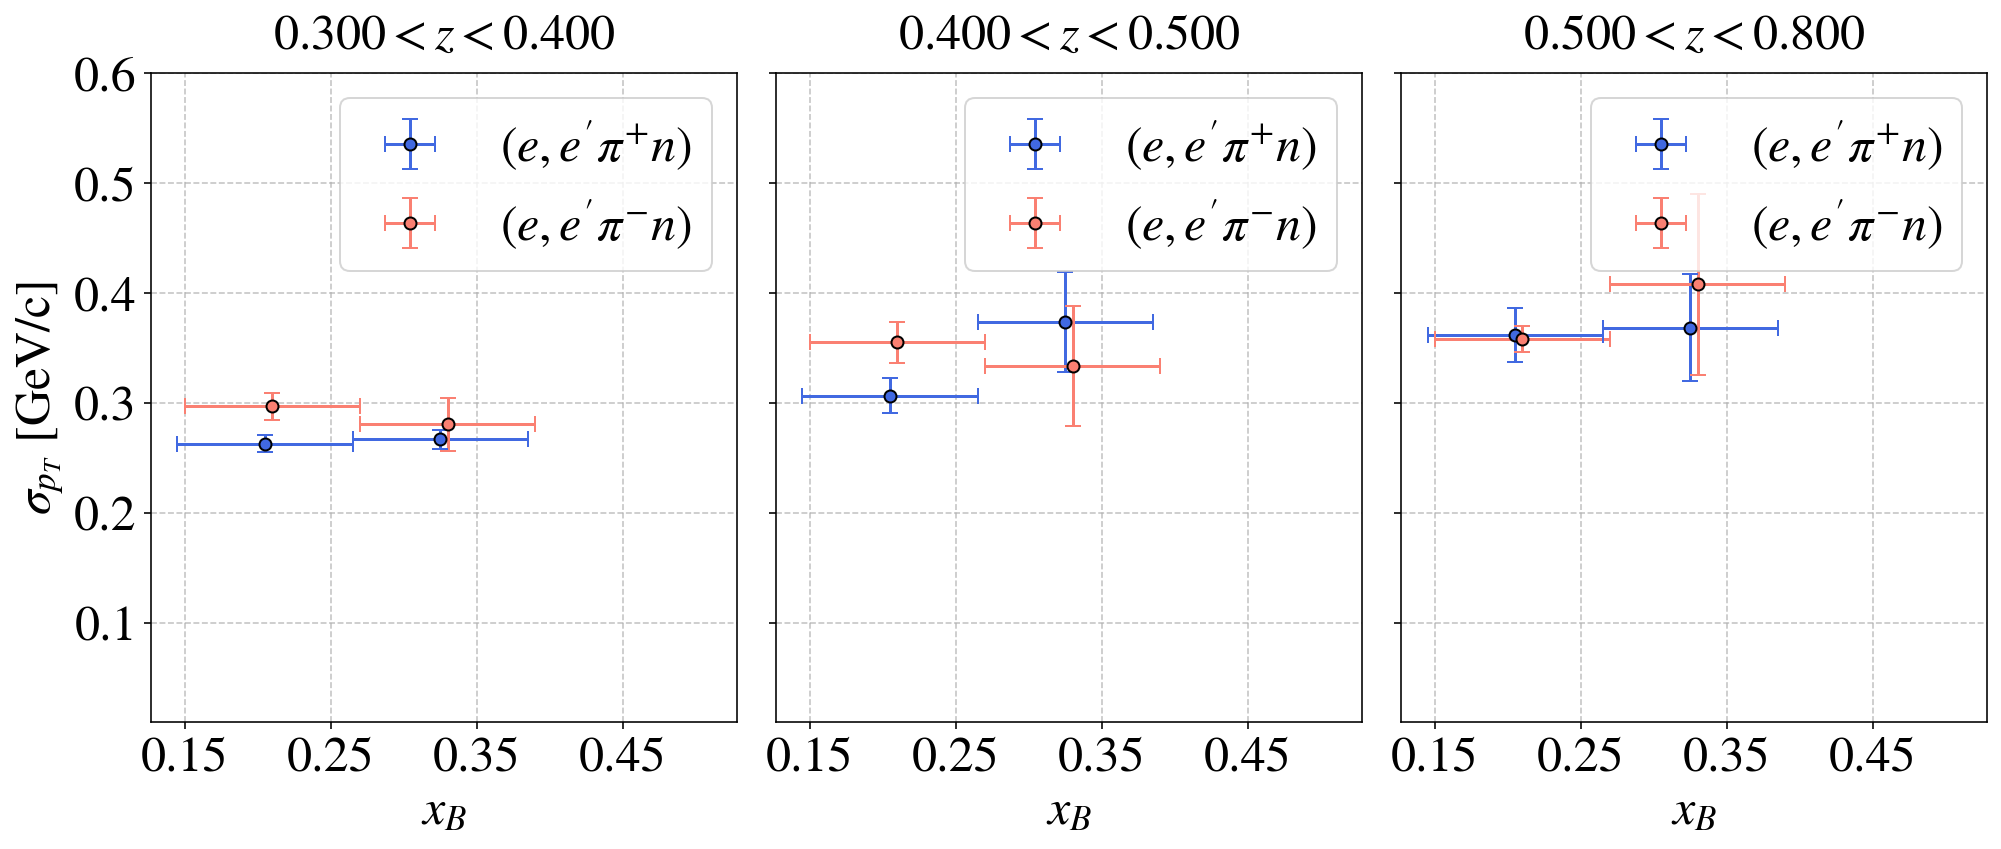

In [28]:
fig = plt.figure(figsize=(14,6),tight_layout=True)
for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(N_z)):#{
    z_min,z_max = z_bin-z_width, z_bin+z_width

    ax = fig.add_subplot( 1, 3, z_idx+1 )
    
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        sig_vs_x     = sig_in_bin[z_idx,:,pi_idx-1]
        sig_err_vs_x = sig_err_in_bin[z_idx,:,pi_idx-1]


        ax.errorbar(x=x_bins + 0.005*pi_idx*np.ones(len(x_bins)), 
                    xerr=x_widths,
                    y=sig_vs_x, 
                    yerr=sig_err_vs_x, 
                    color=pi_color,
                    capsize=4, marker='o', markeredgecolor='k', linestyle='None', 
                    label="$(e,e'"+pi_label+"n)$" )
        
    set_axes(ax,'$x_B$' ,
             '$\\sigma_{p_T}$ [GeV/c]' if z_idx==0 else '',
             remove_ticks_x=False,
             remove_ticks_y=True if z_idx>0 else False,
             title="$%.3f < z < %.3f$"%(z_min,z_max) ,
             do_add_grid=True,do_add_legend=True, 
             xticks=np.arange(0.15,0.55,0.1),
             ylim=(0.01,0.6))



### (3.8) $p_T$ in bins of $Q^2$

#### Untagged data

In [29]:
Q2_bins_untagged   = np.linspace(2.15,5.15,11)
Q2_widths_untagged = (Q2_bins_untagged[1]-Q2_bins_untagged[0])/2*np.ones(len(Q2_bins_untagged))
for Q2_bin,Q2_width,Q2_idx in zip(Q2_bins_untagged, Q2_widths_untagged ,range(len(Q2_bins_untagged))):
    Q2_min,Q2_max = Q2_bin-Q2_width, Q2_bin+Q2_width
    print('%d, %.3f < Q2 < %.3f'%(Q2_idx,Q2_min,Q2_max))
print('')    
N_Q2 = len(Q2_bins_untagged)

0, 2.000 < Q2 < 2.300
1, 2.300 < Q2 < 2.600
2, 2.600 < Q2 < 2.900
3, 2.900 < Q2 < 3.200
4, 3.200 < Q2 < 3.500
5, 3.500 < Q2 < 3.800
6, 3.800 < Q2 < 4.100
7, 4.100 < Q2 < 4.400
8, 4.400 < Q2 < 4.700
9, 4.700 < Q2 < 5.000
10, 5.000 < Q2 < 5.300



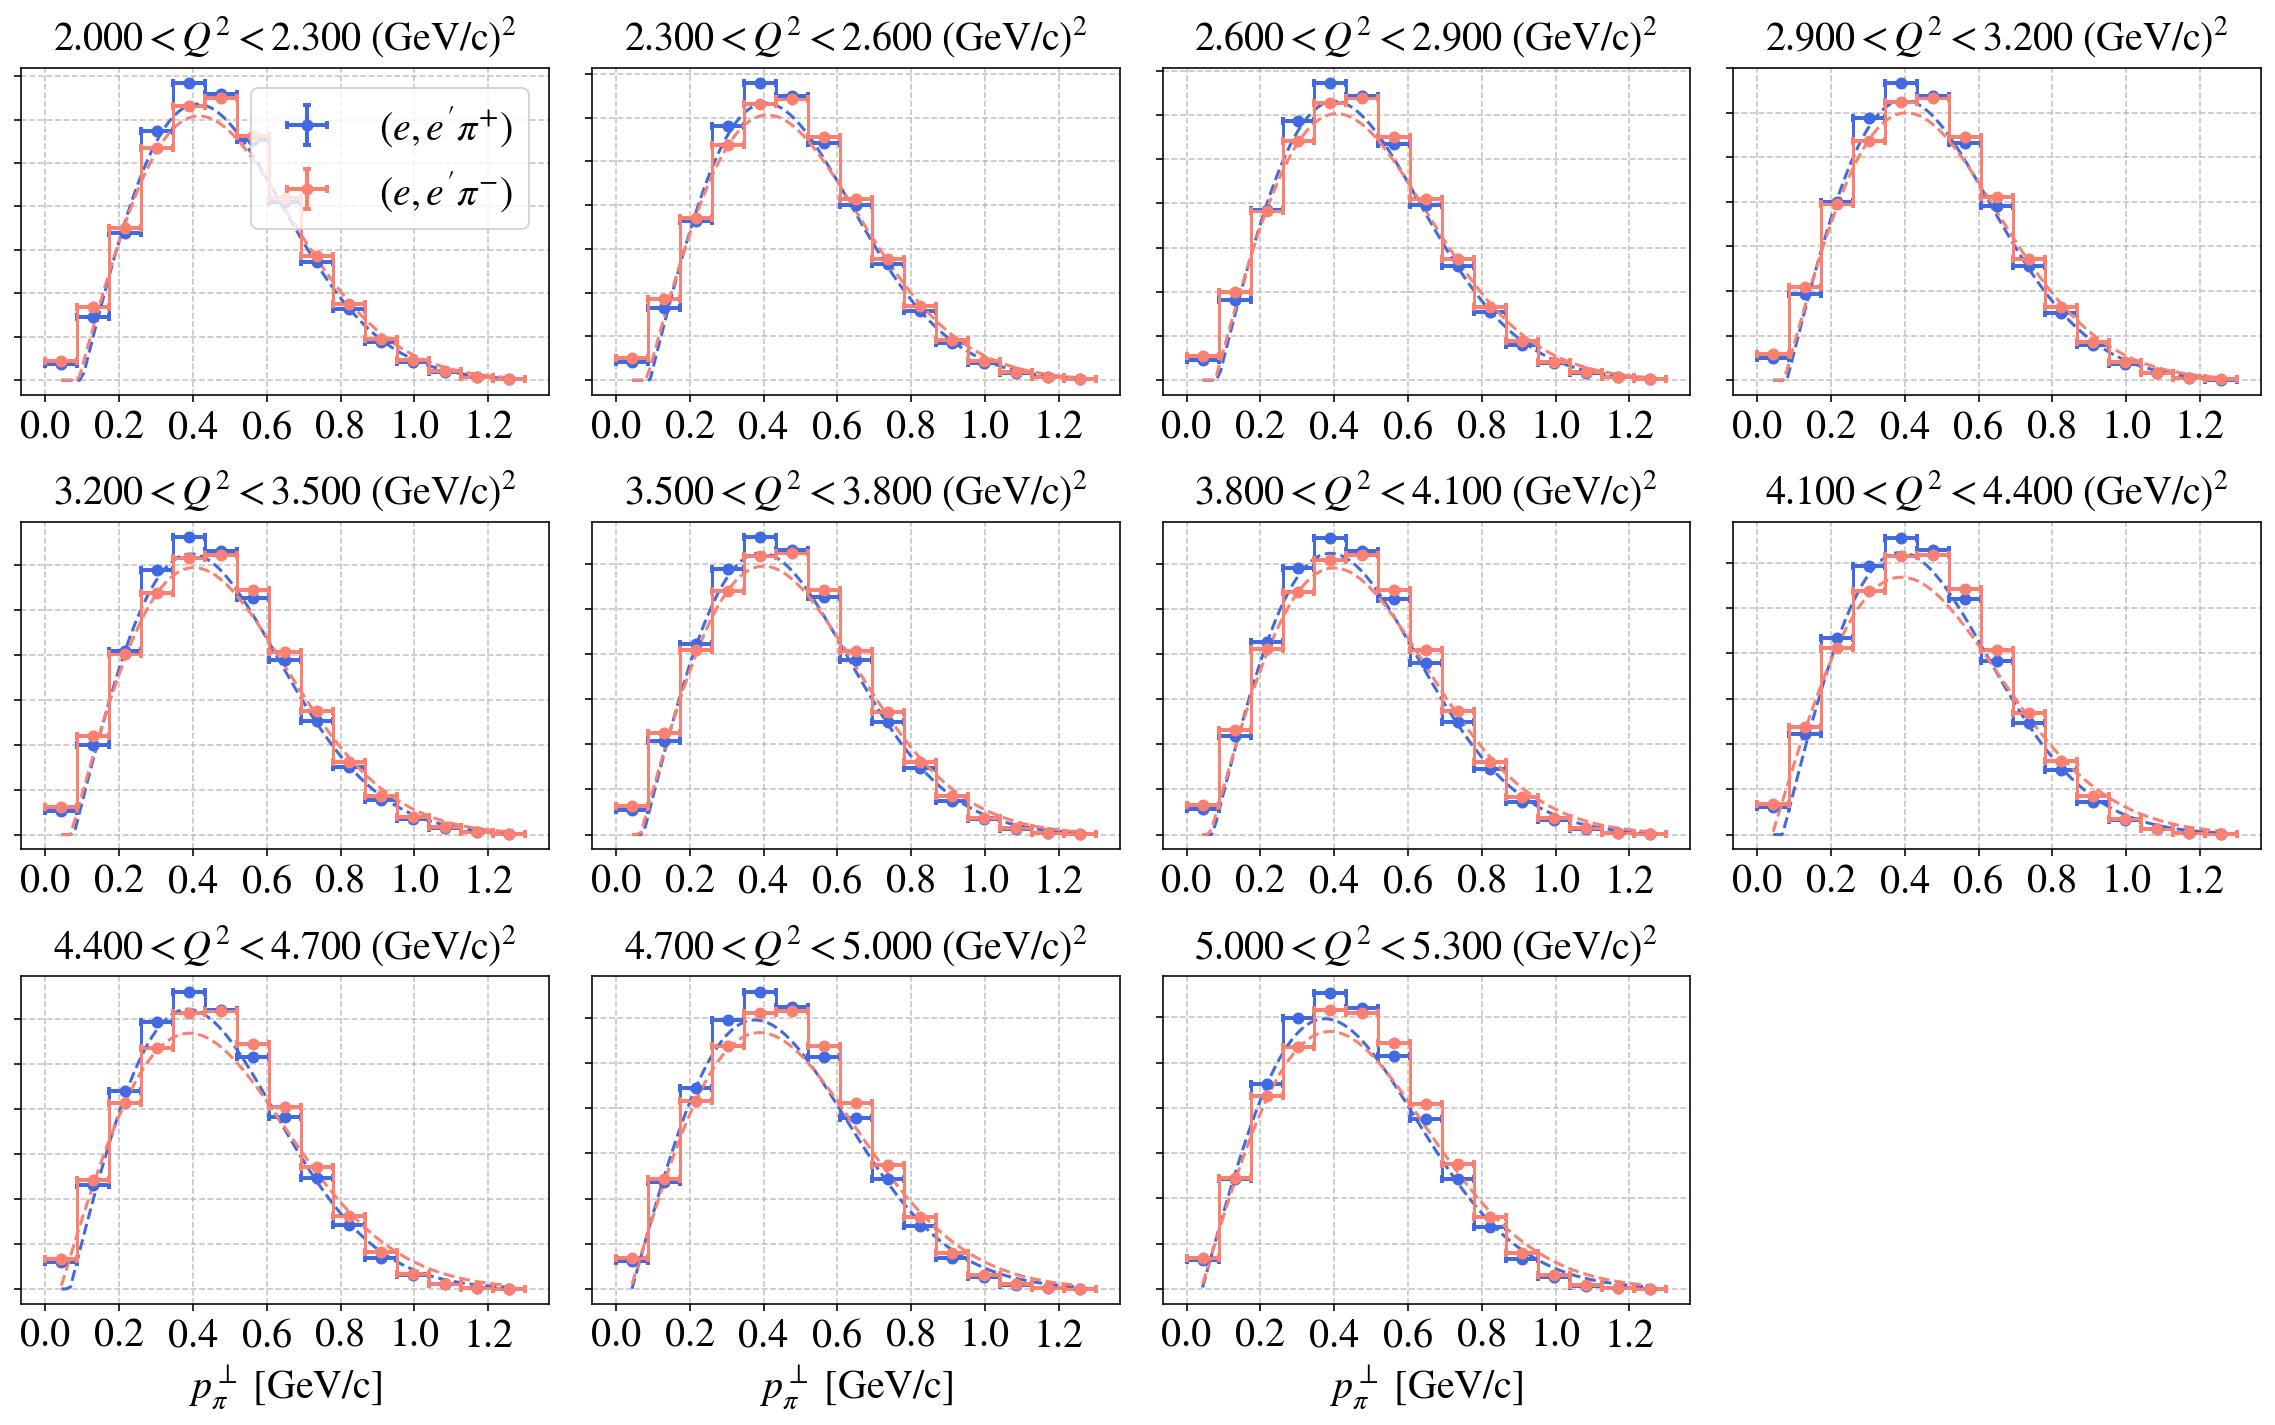

In [30]:
bins = np.linspace(0,1.3,16)
fig = plt.figure(figsize=(16,10),tight_layout=True)
sig_in_bin_untagged,sig_err_in_bin_untagged = np.zeros((N_Q2,2)),np.zeros((N_Q2,2))

for Q2_bin,Q2_width,Q2_idx in zip(Q2_bins_untagged ,Q2_widths_untagged ,range(N_Q2)):#{
    Q2_min,Q2_max = Q2_bin-Q2_width, Q2_bin+Q2_width
    ax = fig.add_subplot( ceil(N_Q2/4),4,  Q2_idx+1 )
        
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        
        # cut on Q2
        df = e_e_pi_pass_cuts[pi_ch]
        df_in_bin = df[  (Q2_min < df.Q2) & (df.Q2 < Q2_max) ]

        # plot
        x,y,x_err,y_err = plot_step_hist( df_in_bin["pi_qFrame_pT"], bins = bins, 
                       color=pi_color,
                       density=True, 
                       label= "$(e,e'"+pi_label+")$" )
        
        # fit to a chi distribution function
        fit_results = fit_pT( x, y, y_err, 0, do_plot_fit=True,color=pi_color )
        sig_in_bin_untagged[Q2_idx,pi_idx-1]    = fit_results['sig_fit']
        sig_err_in_bin_untagged[Q2_idx,pi_idx-1]= fit_results['sig_err']


    #}    
    set_axes(ax,'$p_{\pi}^{\perp}$ [GeV/c]' if Q2_idx >= 8 else '',
             'Frequency [a.u.]' if pi_idx==1 else '', 
             title= "$%.3f < Q^2 < %.3f$ (GeV/c)$^2$"%(Q2_min,Q2_max),
             fontsize=20,
             remove_ticks_x = False,
             remove_ticks_y = True,
             do_add_grid=True, 
             do_add_legend=True if Q2_idx==0 else False)
#}

#### Tagged data

In [31]:

Q2_min_arr_tagged = [2.0,2.5,3.0,3.5]
Q2_max_arr_tagged = [2.5,3.0,3.5,5.3 ]
N_Q2_tagged = len(Q2_min_arr_tagged)
for Q2_min,Q2_max,Q2_idx in zip(Q2_min_arr_tagged,Q2_max_arr_tagged,range(N_Q2_tagged)):
    print('%d, %.3f < Q2 < %.3f'%(Q2_idx,Q2_min,Q2_max))
print('')    


0, 2.000 < Q2 < 2.500
1, 2.500 < Q2 < 3.000
2, 3.000 < Q2 < 3.500
3, 3.500 < Q2 < 5.300



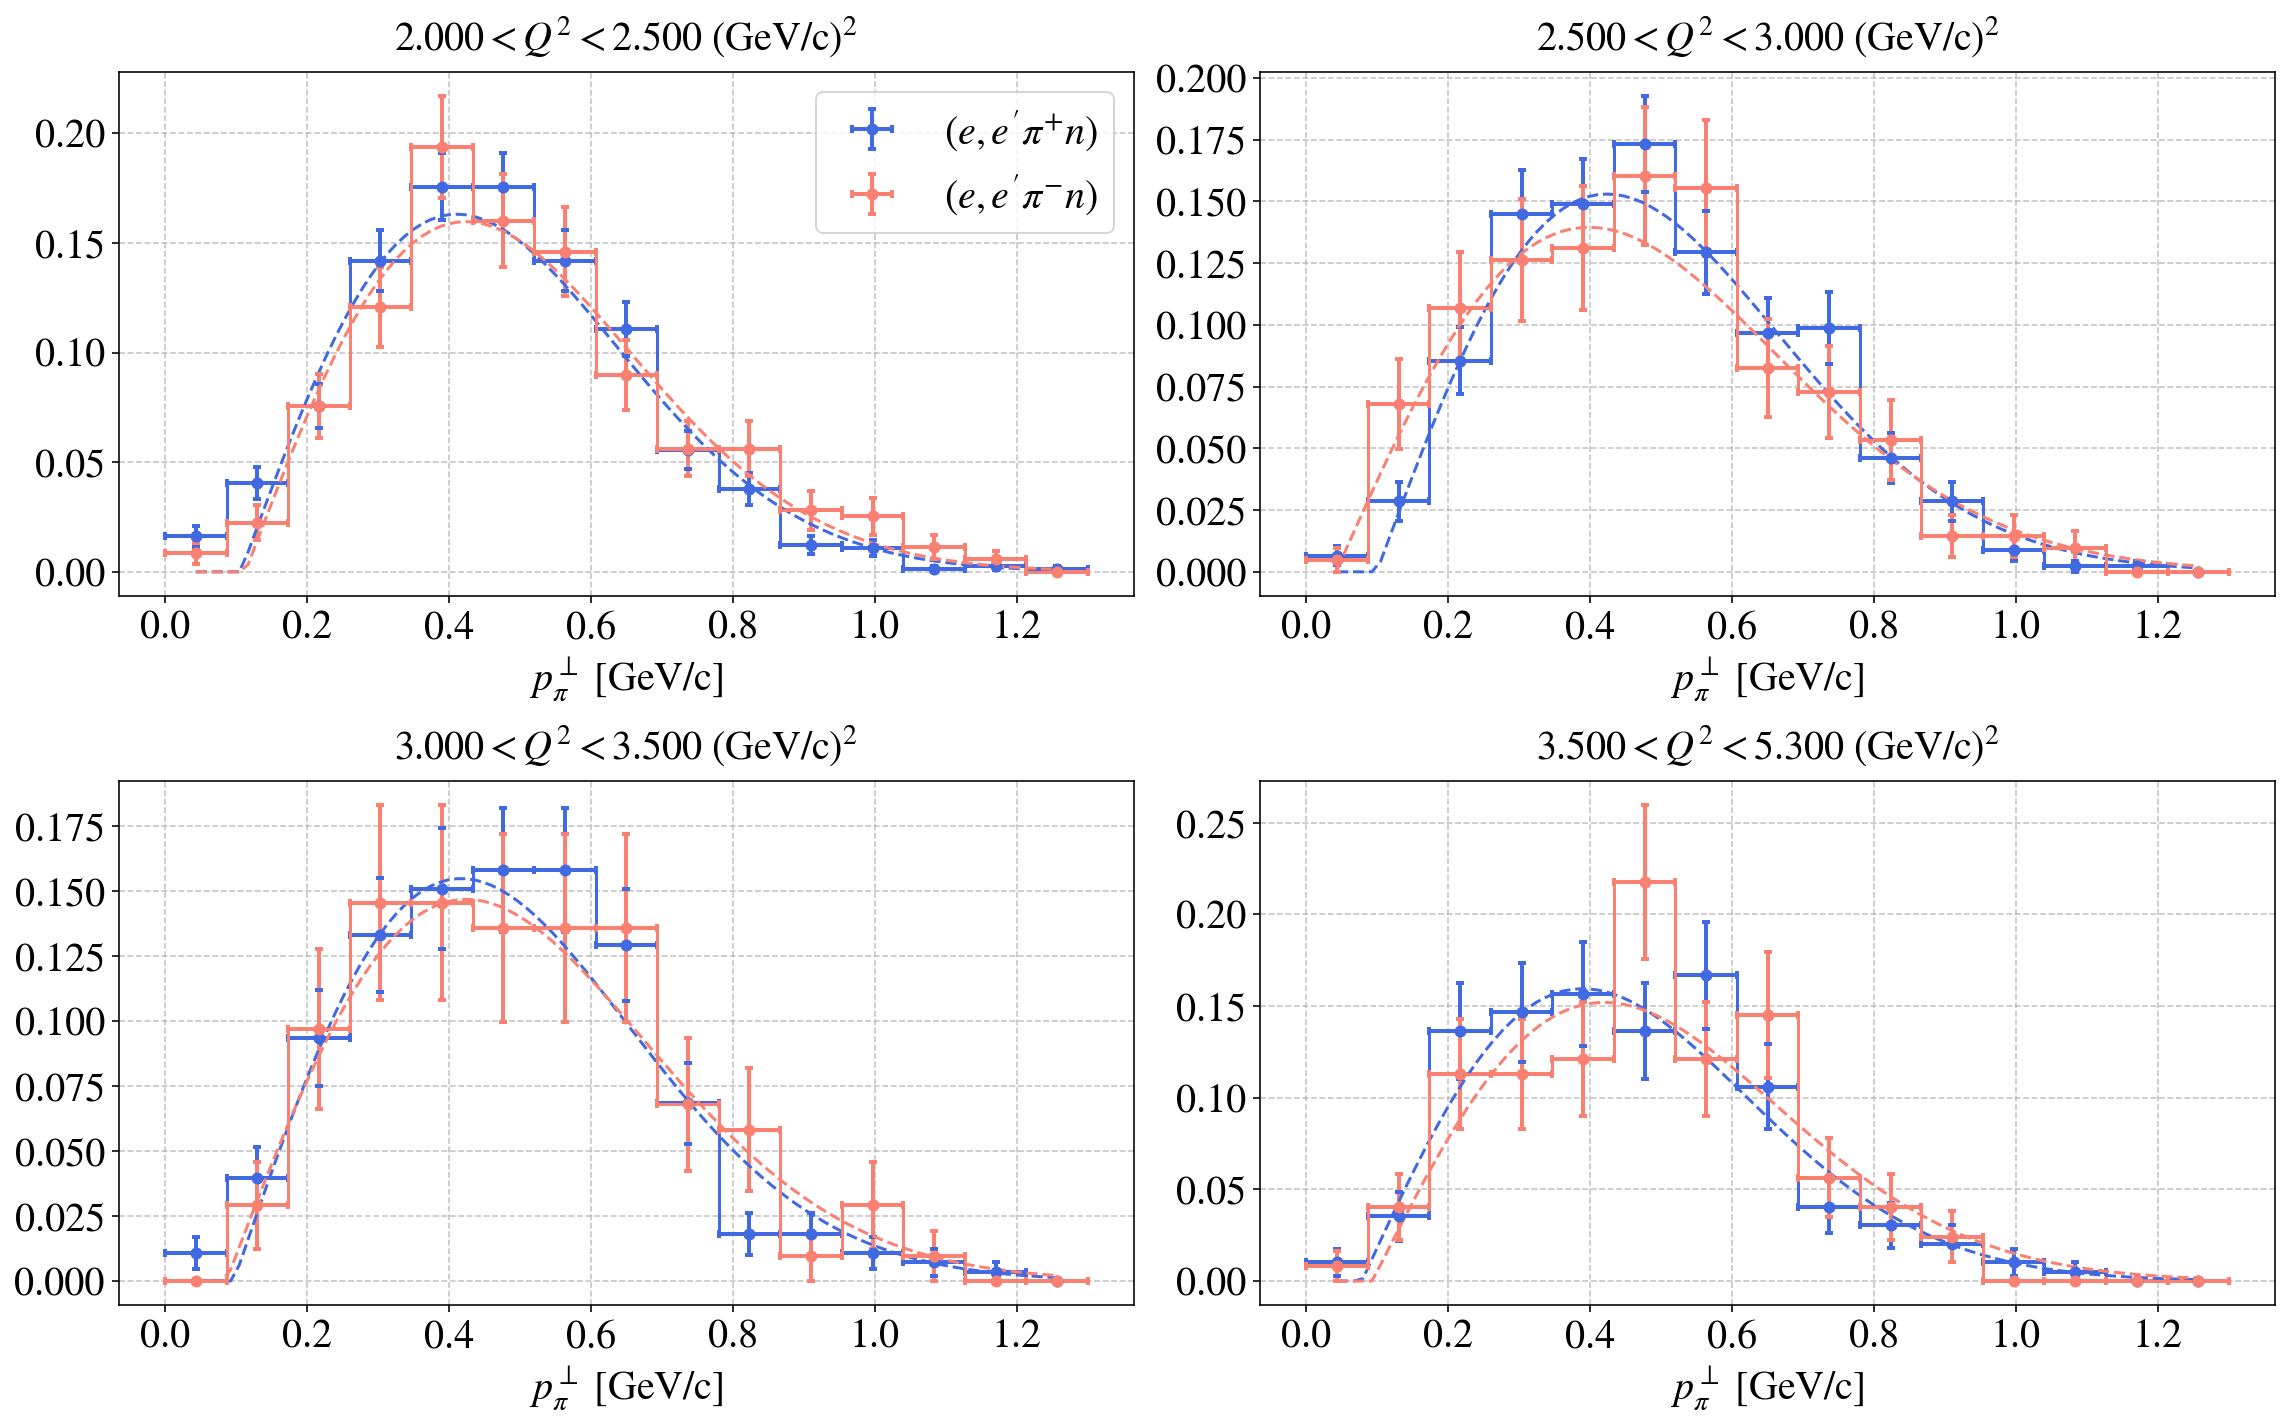

In [32]:
bins = np.linspace(0,1.3,16)
fig = plt.figure(figsize=(16,10),tight_layout=True)

sig_in_bin_tagged,sig_err_in_bin_tagged = np.zeros((N_Q2_tagged,2)),np.zeros((N_Q2_tagged,2))
Q2_avg_tagged = np.zeros((N_Q2_tagged,2))

for Q2_min,Q2_max,Q2_idx in zip(Q2_min_arr_tagged,Q2_max_arr_tagged,range(N_Q2_tagged)):
    ax = fig.add_subplot( 2, 2, Q2_idx+1 )
        
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        
        # cut on Q2
        df = e_e_pi_n_pass_cuts[pi_ch]
        df_in_bin = df[  (Q2_min < df.Q2) & (df.Q2 < Q2_max) ]
        Q2_avg_tagged[Q2_idx,pi_idx-1] =  np.mean(df_in_bin.Q2) 

        # plot
        x,y,x_err,y_err = plot_step_hist( df_in_bin["pi_qFrame_pT"], bins = bins, 
                       color=pi_color,
                       density=True, 
                       label= "$(e,e'"+pi_label+"n)$" )
        # fit to a chi distribution function
        fit_results = fit_pT( x, y, y_err, 0, do_plot_fit=True,color=pi_color )
        sig_in_bin_tagged[Q2_idx,pi_idx-1]    = fit_results['sig_fit']
        sig_err_in_bin_tagged[Q2_idx,pi_idx-1]= fit_results['sig_err']

        
    #}    
    set_axes(ax,'$p_{\pi}^{\perp}$ [GeV/c]',
             'Frequency [a.u.]' if pi_idx==1 else '', 
             title= "$%.3f < Q^2 < %.3f$ (GeV/c)$^2$"%(Q2_min,Q2_max),
             fontsize=20,
             remove_ticks_x = False,
             remove_ticks_y = False,
             do_add_grid=True, 
             do_add_legend=True if Q2_idx==0 else False)
#}

In [33]:
# fig = plt.figure(figsize=(9,6),tight_layout=True)
# ax = fig.add_subplot( 1, 1, 1 )
# for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    
#     sig_vs_Q2     = sig_in_bin_tagged[:,pi_idx-1]
#     sig_err_vs_Q2 = sig_err_in_bin_tagged[:,pi_idx-1]

#     err_dw,err_up = Q2_avg_tagged[:,pi_idx-1]-Q2_min_arr_tagged, Q2_max_arr_tagged - Q2_avg_tagged[:,pi_idx-1]
#     ax.errorbar(x = Q2_avg_tagged[:,pi_idx-1],
#                     xerr = [err_dw,err_up], #(np.array(Q2_max_arr) - np.array(Q2_min_arr))/2,
#                     y=sig_vs_Q2, 
#                     yerr=sig_err_vs_Q2, 
#                     color=pi_color,
#                     capsize=4, marker='o', markeredgecolor='k', linestyle='None', 
#                     label="$(e,e'"+pi_label+")$" )
        
#     set_axes(ax,'$Q^2$ [(GeV/c)$^2$]' ,
#              '$\\sigma_{p_T}$ [GeV/c]' ,
#              remove_ticks_x=False,
#              remove_ticks_y=False,
#              do_add_grid=True,do_add_legend=True, 
#              ylim=(0.25,0.4)
#             )

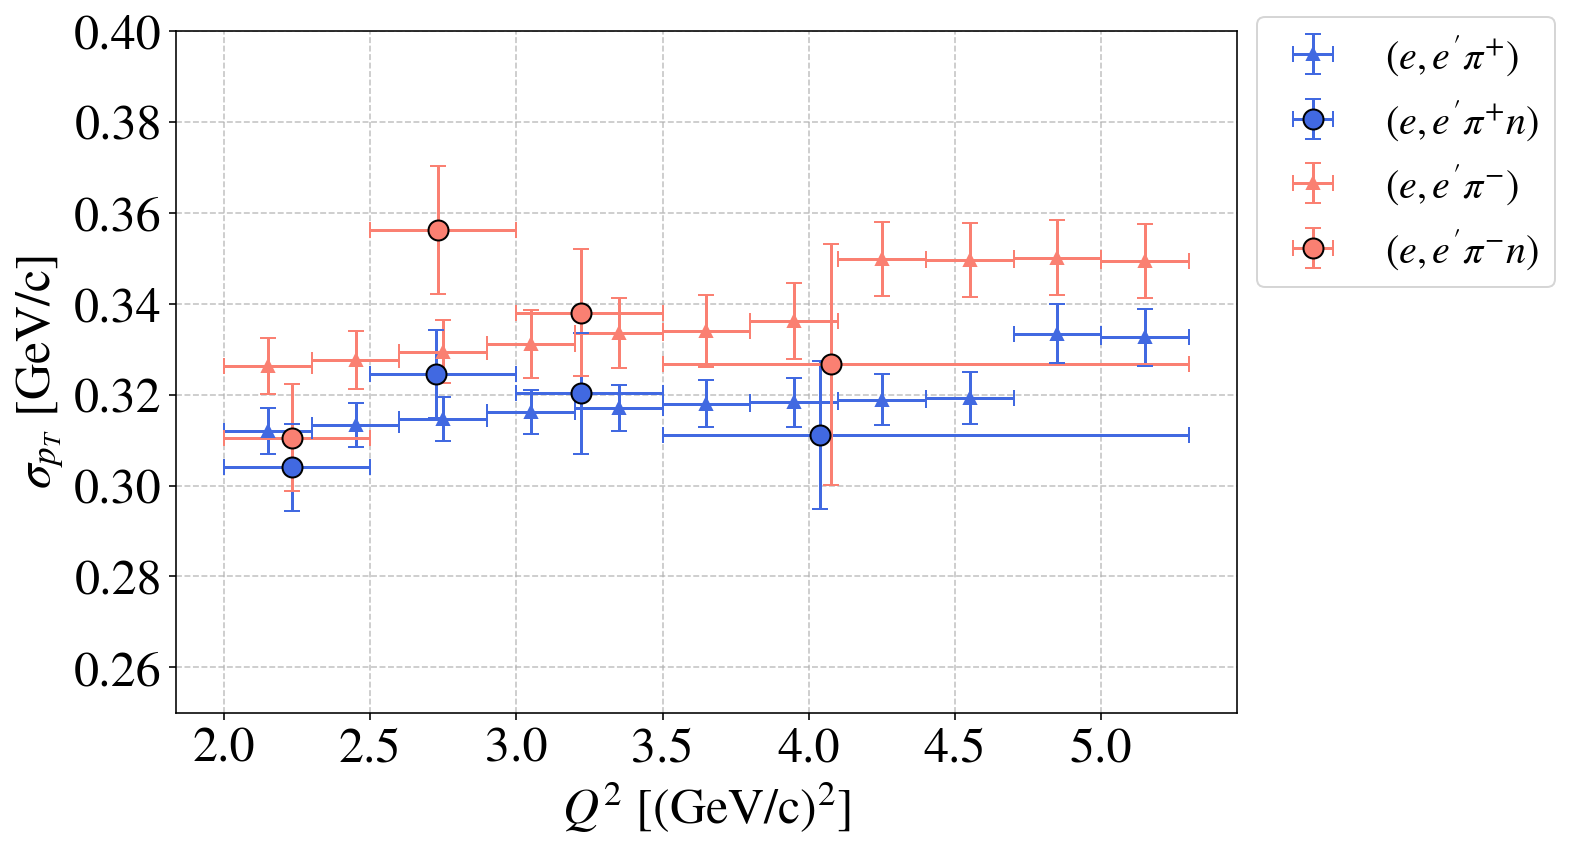

In [34]:
fig = plt.figure(figsize=(11,6),tight_layout=True)
ax = fig.add_subplot( 1, 1, 1 )
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    
    sig_vs_Q2     = sig_in_bin_untagged[:,pi_idx-1]
    sig_err_vs_Q2 = sig_err_in_bin_untagged[:,pi_idx-1]

    ax.errorbar(x=Q2_bins_untagged,
                    xerr=Q2_widths_untagged,
                    y=sig_vs_Q2, 
                    yerr=sig_err_vs_Q2, 
                    color=pi_color,
                    capsize=4, marker='^', markeredgecolor=pi_color, linestyle='None', 
                    label="$(e,e'"+pi_label+")$" )
        
        
        
    sig_vs_Q2     = sig_in_bin_tagged[:,pi_idx-1]
    sig_err_vs_Q2 = sig_err_in_bin_tagged[:,pi_idx-1]

    err_dw,err_up = Q2_avg_tagged[:,pi_idx-1]-Q2_min_arr_tagged, Q2_max_arr_tagged - Q2_avg_tagged[:,pi_idx-1]
    ax.errorbar(x = Q2_avg_tagged[:,pi_idx-1],
                    xerr = [err_dw,err_up], 
                    y=sig_vs_Q2, 
                    yerr=sig_err_vs_Q2, 
                    color=pi_color,
                    capsize=4, marker='o', markersize=10, markeredgecolor='k', linestyle='None', 
                    label="$(e,e'"+pi_label+"n)$" )

        
        
    set_axes(ax,'$Q^2$ [(GeV/c)$^2$]' ,
             '$\\sigma_{p_T}$ [GeV/c]' ,
             remove_ticks_x=False,
             remove_ticks_y=False,
             do_add_grid=True,do_add_legend=True, 
             ylim=(0.25,0.4)
            )
    ax.legend(bbox_to_anchor=(1.,1.05),loc='best',fontsize=20)

### (3.9) $M_x$ and $M'_{x}$ 

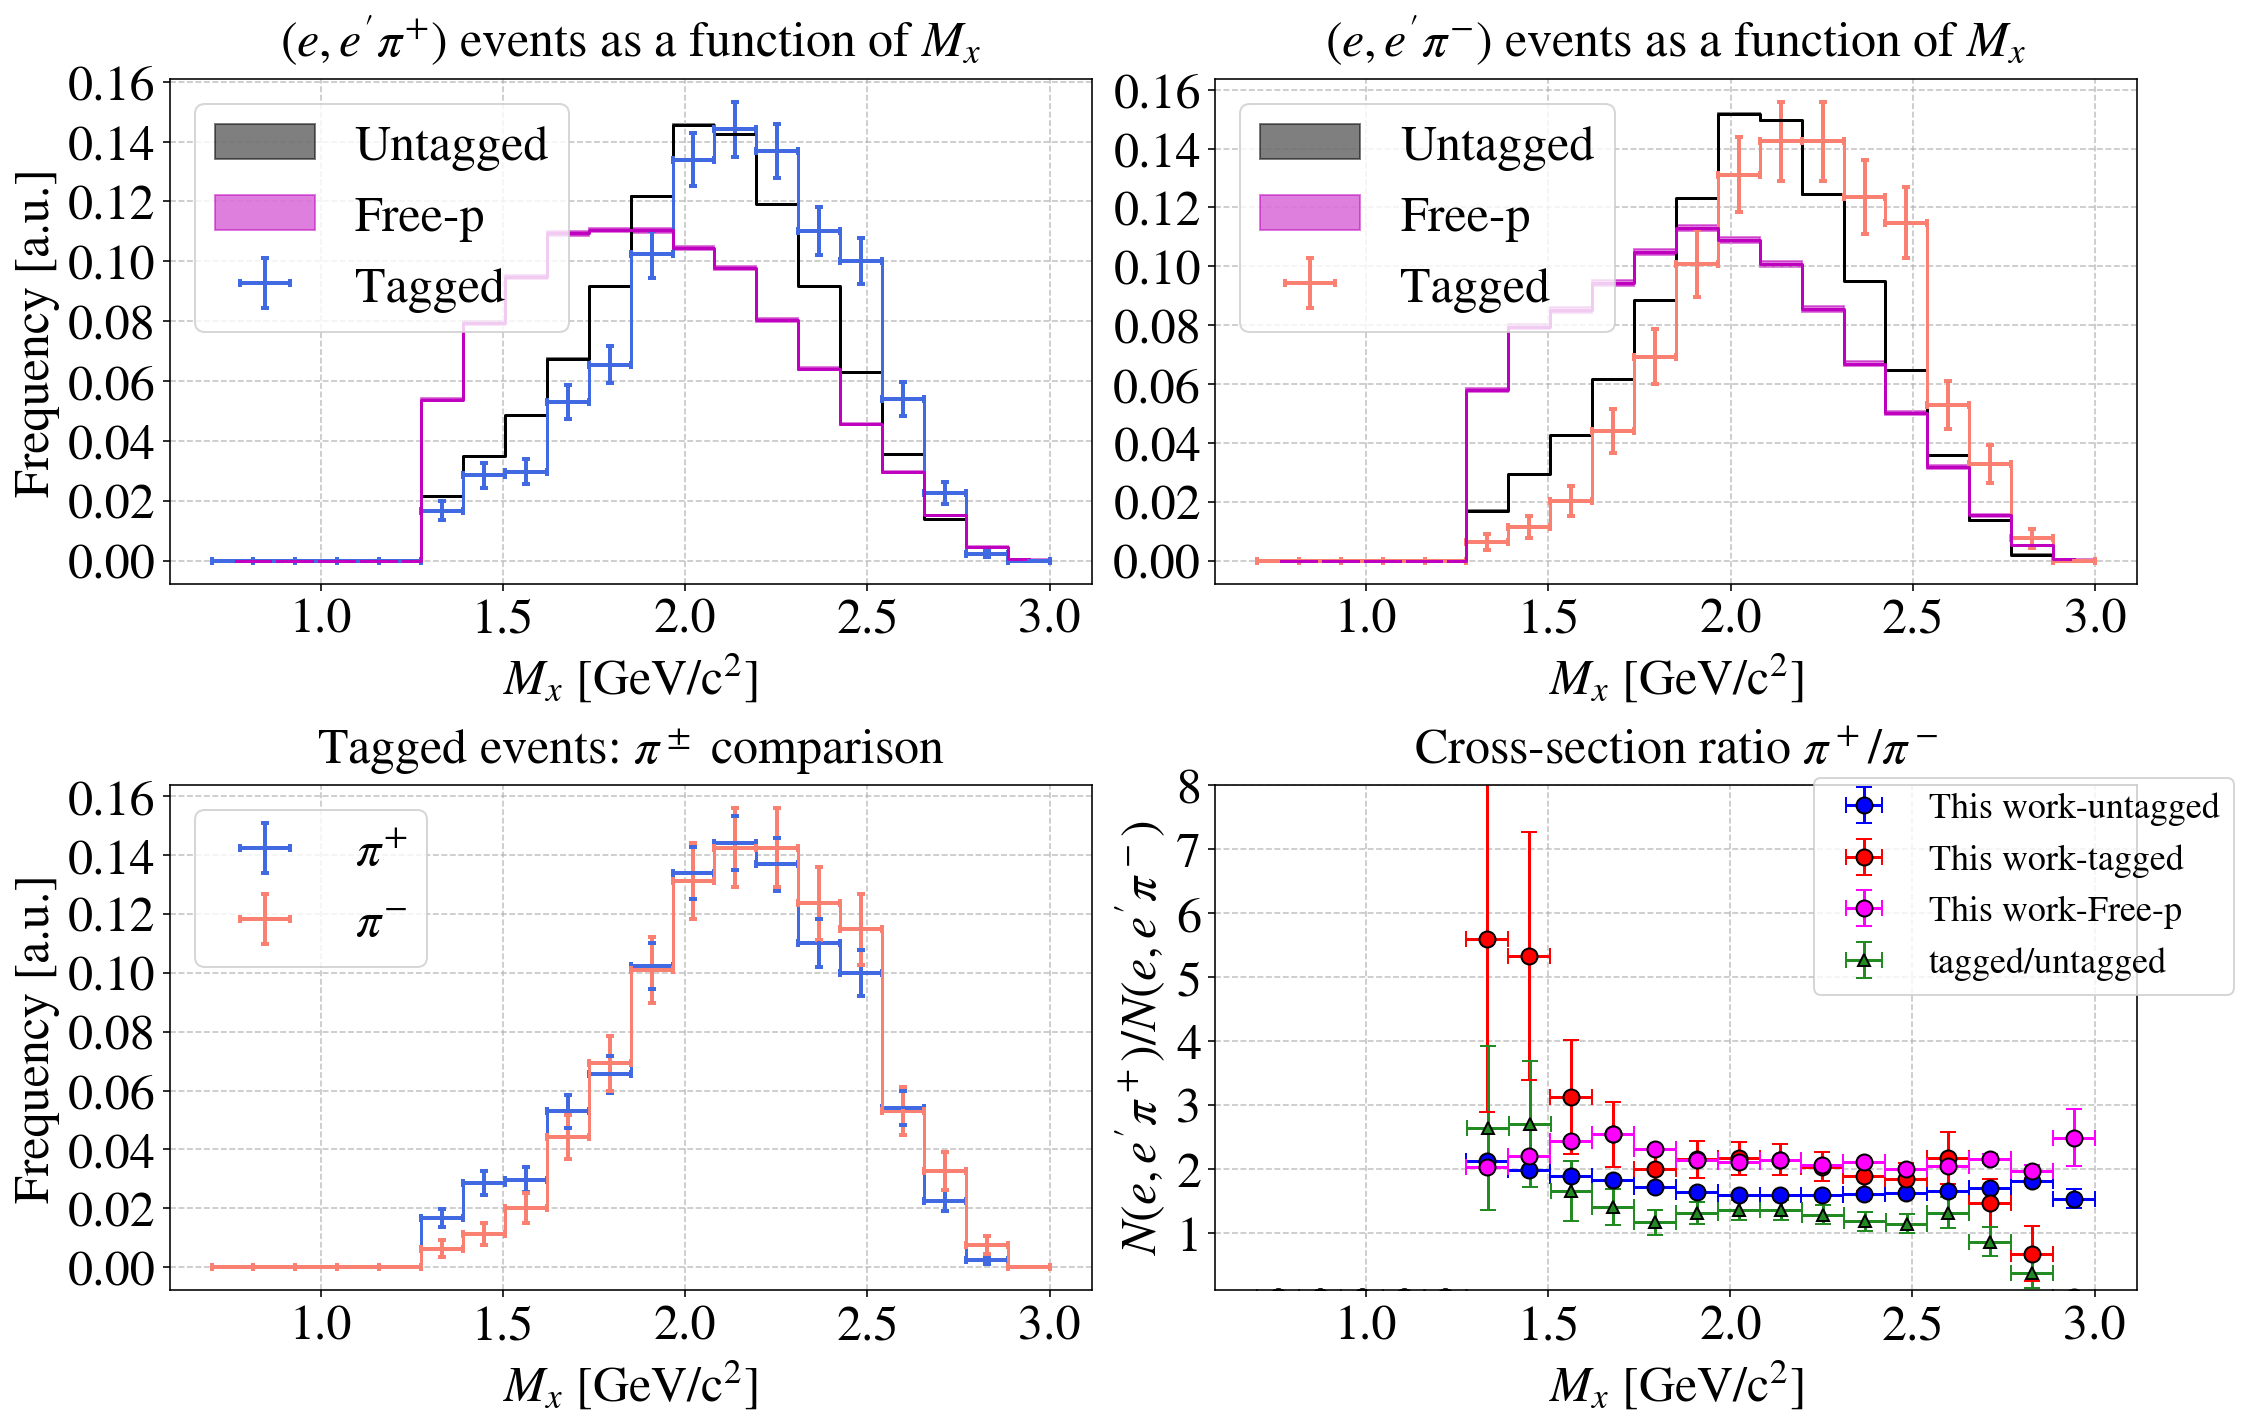

In [35]:
ax=plot_SIDIS_variable(var  = 'M_x',
                       bins = np.linspace(0.7,3.,21),
                       varlabel = '$M_x$',
                       varunits = ' [GeV/c$^2$]', ylim_ratio=(0.1,8)
                      );
# ax[4].legend(loc=(0.0,0.6),fontsize=17);

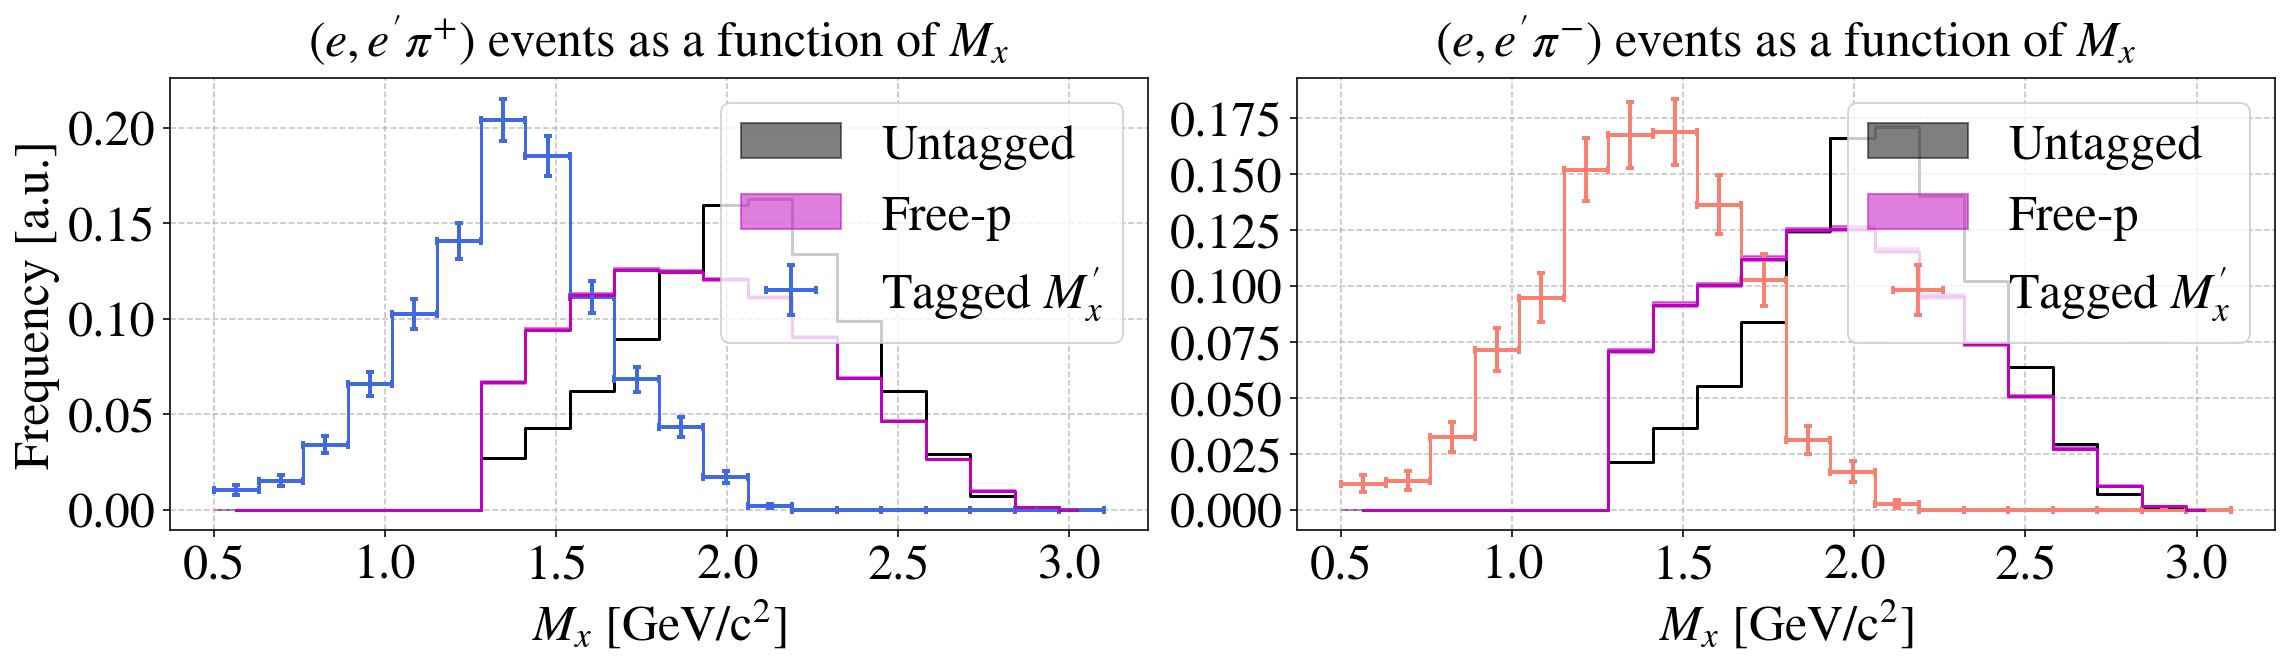

In [36]:
plot_SIDIS_variable(var  = 'M_x',                      
                    bins = np.linspace(0.5,3.1,21),                    
                    varlabel = '$M_x$',
                    varunits = ' [GeV/c$^2$]', 
                    var_tagged = 'M_x_Prime',
                    varlabel_tagged="$M_x'$",
                    do_only_top_2=True);

### (3.10) $q^*$ 

KeyError: 'qStart'

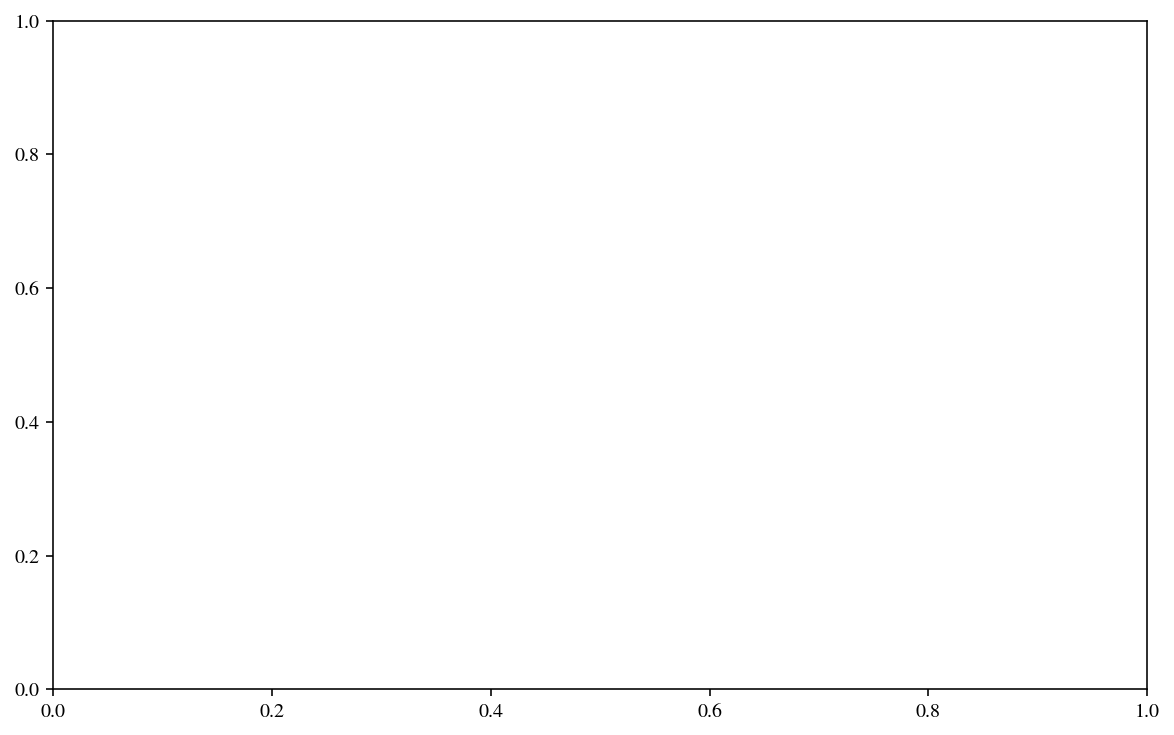

In [37]:
ax=plot_SIDIS_variable(var  = 'qStart',
                       bins = np.linspace(-7,7,50),
                       varlabel = '$q^*$',
                       varunits = ' [GeV/c]', 
                       # ylim_ratio=(0.1,8)
                      );
# ax[4].legend(loc=(0.0,0.6),fontsize=17);

# (4) Focus on tagged data - neutron characteristics 

## (4.1) neutron momentum and direction

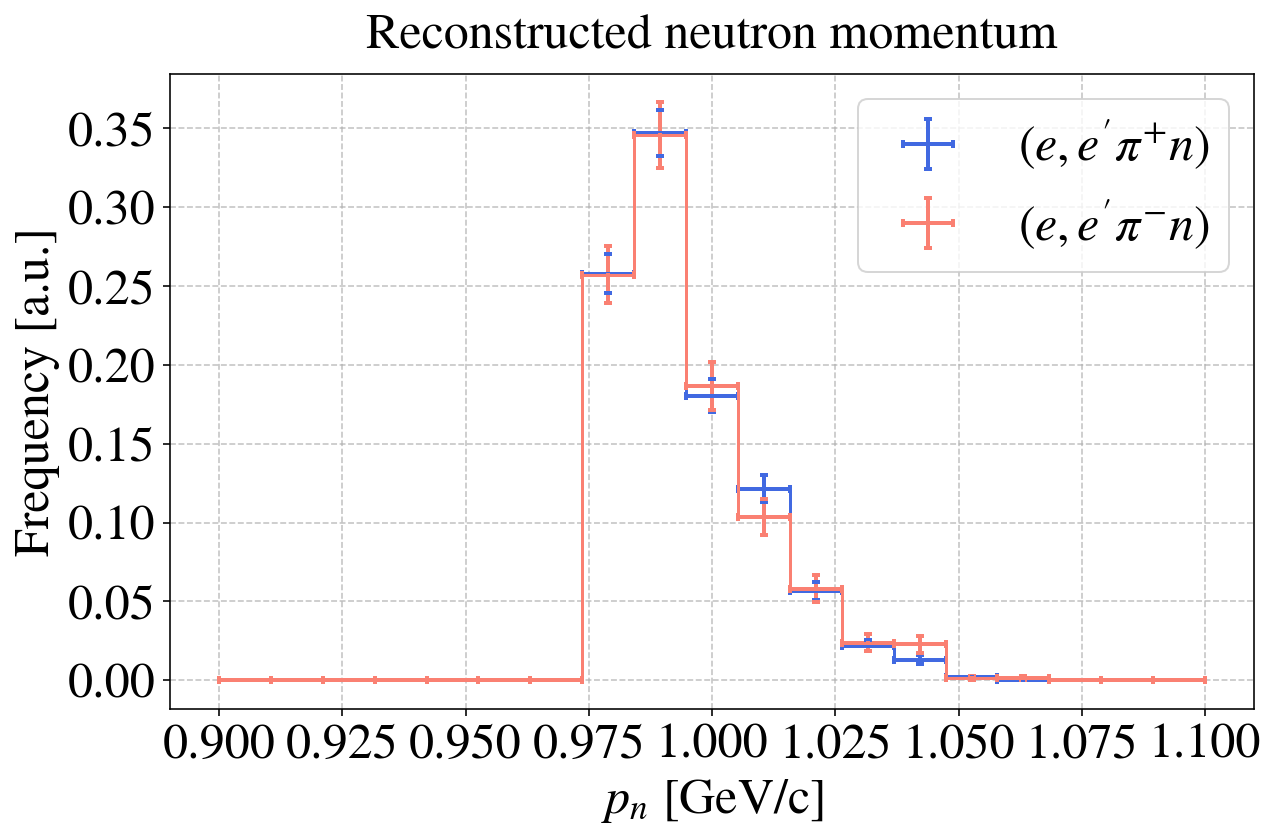

In [64]:
# m_n
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(1,1,1)
# for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

#     df = e_e_pi_n_pass_cuts[pi_ch]
#     plot_step_hist( df.n_E - m_n, bins=np.linspace(0,1.1,20), marker='s',
#                    markersize=1, color=pi_color,label="$(e,e'"+pi_label+"n)$", alpha=1, density=True)

# set_axes(ax,'$E_n^k$ [GeV/c]',
#          'Frequency [a.u.]', 
#          title="Reconstructed neutron momentum",
#          do_add_grid=True, do_add_legend=True,)
# plt.tight_layout()

0.275033838 <p(n)< 0.470045102 GeV/c
0.275129662 <p(n)< 0.505923657 GeV/c


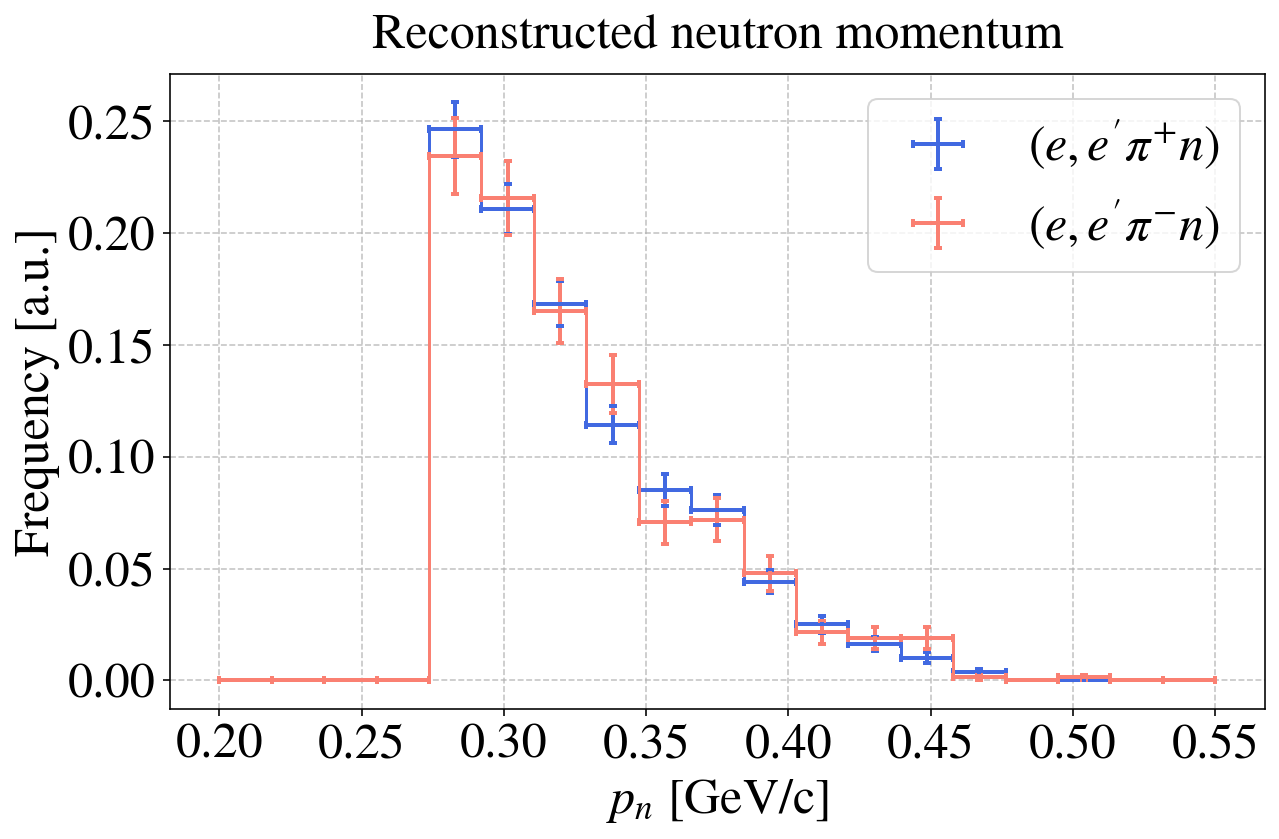

In [66]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_P, bins=np.linspace(0.2,0.55,20), marker='s',
                   markersize=1, color=pi_color,label="$(e,e'"+pi_label+"n)$", alpha=1, density=True)
    print(np.min(df.n_P),'<p(n)<',np.max(df.n_P),'GeV/c')
set_axes(ax,'$p_n$ [GeV/c]',
         'Frequency [a.u.]', 
         title="Reconstructed neutron momentum",
         do_add_grid=True, do_add_legend=True,)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,6),tight_layout=True)
ax = fig.add_subplot(1,2,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_Theta*r2d, bins=np.linspace(155,170,20), marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)

set_axes(ax,'$\\theta_n$ [deg.]',
         'Frequency [a.u.]', 
         title="neutron scattering angle",
         do_add_grid=True, do_add_legend=True,)

ax = fig.add_subplot(1,2,2)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_Phi*r2d, bins=np.linspace(-180,180,20), marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)

set_axes(ax,'$\phi_n$ [deg.]',
         '', 
         title="neutron azimuthal angle",
         do_add_grid=True, do_add_legend=True,)

## (4.2) neutron transverse momentum to $\vec{q}$ and parallel to $\vec{q}$

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df["n_pT_qFrame"], bins=np.linspace(-0.01,0.25,21), marker='s',
                   markersize=1, color=pi_color,label="$(e,e'"+pi_label+"n)$", alpha=1, density=True)

set_axes(ax,'$p_n^{\perp} $ [GeV/c]',
         'Frequency [a.u.]', 
         title="neutron momentum tranverse to $\\vec{q}$",
         do_add_grid=True, do_add_legend=True,)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df["n_pL_qFrame"], bins=np.linspace(-0.5,-0.1,21), marker='s',
                   markersize=1, color=pi_color,label="$(e,e'"+pi_label+"n)$", alpha=1, density=True)

set_axes(ax,'$\\vec{p}_n \cdot \hat{q} $ [GeV/c]',
         'Frequency [a.u.]', 
         title="neutron momentum parallel to $\\vec{q}$",
         do_add_grid=True, do_add_legend=True,
         xticks=[-0.5,-0.4,-0.3,-0.2,-0.1])
plt.tight_layout()

## (4.3) neutron light-cone fraction

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df["alpha_n"], bins=np.linspace(1.2,1.6,21), marker='s',
                   markersize=1, color=pi_color,label="$(e,e'"+pi_label+"n)$", alpha=1, density=True)

set_axes(ax,'$\\alpha_n = (E_{n} - \\vec{p}_n\cdot\\hat{q})/m_n$',
         'Frequency [a.u.]', 
         title="neutron light-cone fraction",
         do_add_grid=True, do_add_legend=True,
         xticks=np.arange(1.2,1.6,0.1))
plt.tight_layout()

## (4.4) neutron hit position in BAND

In [ ]:
fig = plt.figure(figsize=(16,10),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(2,2,pi_idx)

    df = e_e_pi_n_pass_cuts[pi_ch]
    # scatter_plot_with_kernel(x=df.n_HitPos_X , y = df.n_HitPos_Y, s=100,do_add_colorbar=False,cmap='jet')
    plt.scatter(x=df.n_HitPos_X , y = df.n_HitPos_Y, s=100,cmap='jet', edgecolor='k')    
    set_axes(ax,
             "$x_{n-Hit}$ [cm]", 
             "$y_{n-Hit}$ [cm]", 
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=18)    
    
    ax = fig.add_subplot(2,2,2+pi_idx)
    plt.scatter(x=df.n_HitPos_X , y = df.n_HitPos_Z, s=100,cmap='jet', edgecolor='k')        
    set_axes(ax,
             "$x_{n-Hit}$ [cm]", 
             "$z_{n-Hit}$ [cm]", 
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=18)

## (4.4) $\theta_n$ and $\phi_n$ distributions in bins of $x_B$ and $z$

### (4.4.1) angles in lab frame in bins of $x_B$ and $z$

In [ ]:
z_bins   = np.array([0.35,0.45,0.65])
z_widths = np.array([0.05,0.05,0.15])
x_bins   = np.array([0.2, 0.32, 0.44, 0.56 ])
x        = (x_bins[1:] + x_bins[:-1])/2
x_err    = (x_bins[1:] - x_bins[:-1])/2
print('x bins:',x_bins)
print('z bins:',z_bins)
for z_bin,z_width in zip(z_bins,z_widths):
    z_min,z_max = z_bin-z_width, z_bin+z_width
    print('%.3f < z < %.3f:'%(z_min,z_max))

In [ ]:
N_x = len(x)
N_z = len(z_bins)

In [ ]:
fig = plt.figure(figsize=(18,10),tight_layout=True)

for z_bin,z_width,z_idx in zip(z_bins,z_widths,range(N_z)):#{
    z_min,z_max = z_bin-z_width, z_bin+z_width

    for x_min,x_max,x_idx in zip(x_bins[:-1],x_bins[1:],range(N_x)):#{
        ax = fig.add_subplot( N_x,  N_z, z_idx + N_z*x_idx + 1 )
        for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

            df = e_e_pi_n_pass_cuts[pi_ch]
            # cut on xB and z
            df = df[  (z_min < df.Zpi) & (df.Zpi < z_max) 
                    & (x_min < df.xB ) & (df.xB  < x_max) ]
            
            plt.scatter( df.n_Theta*r2d, df.n_Phi*r2d, 
                        marker='o', s=50, color=pi_color,
                        label='$'+pi_label+'$', alpha=1, edgecolor='k')

        set_axes(ax,'$\\theta_n$ [deg.]' if x_idx > 1 else '',
                 '$\phi_n$ [deg.]' if z_idx==0 else '', 
                 title= "$%.1f < z < %.1f$"%(z_min,z_max) + ", " + "$%.2f < x_B < %.2f$"%(x_min,x_max) ,
                 xlim = (155, 170) ,xticks=(155,160,165,170),
                 remove_ticks_x = False if x_idx > 1 else  True,
                 ylim = (-180, 180),yticks=(-180,-60,60,180),
                 remove_ticks_y = False if z_idx%N_z==0 else  True,
                 do_add_grid=True, 
                 do_add_legend=False if z_idx==0 and x_idx==1 else False)
    #}    
#}

### (4.4.2) angles in $q$-Frame

In [ ]:
Nbins = 31
fig = plt.figure(figsize=(16,6),tight_layout=True)
for var,varlabel,vartitle,var_bins,var_idx in zip(['n_Theta_qFrame','n_Phi_qFrame'],
                                                  ['$\\theta_n^q$ [deg.]','$\phi_n^q$ [deg.]'],
                                                  ['$\\theta_n$ in $q$-frame','$\phi_n$ in $q$-frame'],
                                                  [np.linspace(130,180,Nbins),np.linspace(-180,180,Nbins)],
                                                  [1,2]):

    ax = fig.add_subplot(1,2,var_idx)
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

        df = e_e_pi_n_pass_cuts[pi_ch]
        plot_step_hist( df[var]*r2d, bins=var_bins, color=pi_color, label='$'+pi_print+'$', density=True)

    set_axes(ax,varlabel,
                 'Frequency [a.u.]' if var_idx==1 else '', 
                 title= vartitle,
                 # xlim = (155, 170) ,xticks=(155,160,165,170),
                 # ylim = (-180, 180),yticks=(-180,-60,60,180),
                 # remove_ticks_y = False if z_idx%N_z==0 else  True,
                 do_add_grid=True, 
                 do_add_legend=False if var_idx==1 else True)
    #}    
#}

## (4.5) Further 2-D correlations for the tagged data
$M_x$ vs. W, $M_x'$ and $W'$, $x_F$ etc.

In [ ]:
e_e_pi_pass_cuts,e_e_pi_n_pass_cuts,_ = apply_further_selection_cuts_to_data(doApply_Mx_cut=False, 
                                                                             fdebug=2, 
                                                                             NeventsMax=-1);

### (4.5.1) $W$ vs. $W'$ 

In [ ]:
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)

    df = e_e_pi_n_pass_cuts[pi_ch]
    scatter_plot_with_kernel(x=df.W , y = df.W_Prime, s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$W = \sqrt{|p_{rest} + q|^2}$ [GeV/c$^2$]", 
             "$W' = \sqrt{||p_{init} + q|^2}$ [GeV/c$^2$]",
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=22,
             ylim=(1.7,2.8))

### (4.5.2) $W$ vs. $M_x$ for un-tagged and $W'$ vs. $M_x'$ for tagged

In [ ]:
Mx_label = "$M_x = \sqrt{|p+q-\pi|^2}$ [GeV/c$^2$]"
ylim=(0.5,3.)

fig = plt.figure(figsize=(16,12),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_pass_cuts[pi_ch]
    
    ax = fig.add_subplot(2,2,pi_idx)
    ax.hist2d( x=df.W , y = df.M_x, cmap='hot_r', bins=100 )
    set_axes(ax,
             "$W = \sqrt{|p_{rest} + q|^2}$ [GeV/c$^2$]", 
             Mx_label if pi_idx==1 else '',
             title="$(e,e'"+pi_label+")$",
             do_add_grid=True, do_add_legend=False,fontsize=22,
             remove_ticks_y=True if pi_idx==2 else False,
             ylim=ylim)    

xlim=(1.7,2.7)
ylim=(0.5,2.3)


# fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_n_pass_cuts[pi_ch]

    ax = fig.add_subplot(2,2,2+pi_idx)
    scatter_plot_with_kernel(x=df.W_Prime , y = df.M_x_Prime, s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$W' = \sqrt{|p_{init} + q|^2}$ [GeV/c$^2$]",
             "$M_x' = \sqrt{|q+p_{init}-\pi|^2}$ [GeV/c$^2$]" if pi_idx==1 else '',
             title="$(e,e'"+pi_label+" n)$",
             xlim=xlim,
             do_add_grid=True, do_add_legend=False,fontsize=22,
             remove_ticks_y=True if pi_idx==2 else False,
             ylim=ylim)    

### (4.5.3) $M_x$ vs. $M_x'$

In [ ]:
xlim=(0.9,3)
ylim=(0.5,2.3)

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_n_pass_cuts[pi_ch]

    ax = fig.add_subplot(1,2,pi_idx)
    scatter_plot_with_kernel(x=df["M_x"] , y = df["M_x_Prime"], 
                             s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$M_x = \sqrt{|q+p_{rest}-\pi|^2}$ [GeV/c$^2$]",
             "$M_x' = \sqrt{|q+p_{init}-\pi|^2}$ [GeV/c$^2$]" if pi_idx==1 else '',
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=22,
             remove_ticks_y=True if pi_idx==2 else False,
             xlim=xlim,
             ylim=ylim)    

### (4.5.4) $M_x$ vs. $W$

In [ ]:
xlim=(2.4,3.6)
ylim=(0.9,3.)

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_n_pass_cuts[pi_ch]

    ax = fig.add_subplot(1,2,pi_idx)
    scatter_plot_with_kernel(x=df["W"] , y = df["M_x"], 
                             s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$W = \sqrt{|q+p_{rest}|^2}$ [GeV/c$^2$]",
             "$M_x = \sqrt{|q+p_{rest}-\pi|^2}$ [GeV/c$^2$]" if pi_idx==1 else '',
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=22,
             remove_ticks_y=True if pi_idx==2 else False,
             xlim=xlim,ylim=ylim)    

### (4.5.5) $x_F$ vs. $x_F'$

In [ ]:
ylim=(1.3,5.3)

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_n_pass_cuts[pi_ch]

    ax = fig.add_subplot(1,2,pi_idx)
    scatter_plot_with_kernel(x=df["xF"] , y = df["xF_Prime"], 
                             s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$x_F = 2\\vec{p}\cdot \hat{q}/W$",
             "$x_F' = 2\\vec{p}\cdot \hat{q}/W'$" if pi_idx==1 else '',
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=22,
             remove_ticks_y=True if pi_idx==2 else False,
             ylim=ylim)  

## (6) 2D scatter plots with projections using Seaborn

In [ ]:
import seaborn as sns
sns.set(font_scale=2,rc={'figure.facecolor':'white','axes.facecolor':'white','axes.edgecolor':'black'})

In [ ]:
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    df = e_e_pi_n_pass_cuts[pi_ch]
    df.index=df.evnum*df.pi_P
    g = sns.jointplot(x="n_HitPos_X",  #sns.jointplot(x="n_HitPos_X", 
                  y="n_HitPos_Y",
                 edgecolor="black",
                      height=8,
                      ratio=6,
                 data=df, 
                  dropna=True,
                  # marginal_kws=dict(bins=np.linspace(-100,100,100)),
                  xlim=(-100,100),
                  ylim=(-30,100) );
    g.ax_joint.set_xlabel("$x_{n-Hit}$ [cm]")
    g.ax_joint.set_ylabel("$y_{n-Hit}$ [cm]")
    
    g = sns.jointplot(x="n_HitPos_X",  #sns.jointplot(x="n_HitPos_X", 
                  y="n_HitPos_Z",
                 edgecolor="black",
                      height=8,
                      ratio=6,
                 data=df, 
                  dropna=True,
                  # marginal_kws=dict(bins=np.linspace(-300,300,100)), 
                  xlim=(-100,100),
                  ylim=(-300,-260) );
    g.ax_joint.set_xlabel("$x_{n-Hit}$ [cm]")
    g.ax_joint.set_ylabel("$z_{n-Hit}$ [cm]")    


# arxiv

## Correction for $W$

In [ ]:
wrong_W = pd.read_csv('/Users/erezcohen/Desktop/data/BAND/SIDIS_skimming/skimmed_SIDIS_sidisdvcs_006421_e_piplus_selected_eepi_kinematics.csv')
corrected_W = pd.read_csv('/Users/erezcohen/Desktop/data/BAND/SIDIS_skimming/skimmed_SIDIS_sidisdvcs_006421_e_piplus_selected_eepi_kinematics_corrected_W.csv')

In [ ]:
fig,ax = plt.subplots(figsize=(9,6))
for df, label,color in zip([wrong_W,corrected_W],['wrong W','corrected W'],['k','b']):
    plot_step_hist( df.W, bins=np.linspace(2,6,100),color=color, label=label, density=True)
    
set_axes(ax,'$W$','counts',do_add_grid=True,do_add_legend=True);    

In [ ]:
e_e_pi_pass_cuts,e_e_pi_n_pass_cuts,_ = apply_further_selection_cuts_to_data(doApply_minPn_cut=False, 
                                                                             fdebug=2, 
                                                                             NeventsMax=-1);

## (3.2) now choose binning and plot $p_n$ distribution in each bin 

In [ ]:
x_bins   = np.linspace(0.2,0.5,6)
x        = (x_bins[1:] + x_bins[:-1])/2
x_err    = (x_bins[1:] - x_bins[:-1])/2
Nbins    = len(x_bins)
x_bins

In [ ]:
var_label = "standing proton x"
var    = 'xB'
xlabel = "Bjorken $x$"

In [ ]:
fig = plt.figure(figsize=(12,8))
pi_ch = 'piplus'
for bin_idx in range(Nbins):
    x_min, x_max  = x_bins[bin_idx] - x_err[1], x_bins[bin_idx] + x_err[1]
    # df = e_e_pi_pass_cuts[pi_ch];
    # eepi_in_bin   = df[ (x_min < df.xB ) & (df.xB < x_max )]

    df = e_e_pi_n_pass_cuts[pi_ch];
    eepi_n_in_bin = df[ (x_min < df.xB ) & (df.xB < x_max )]

    ax  = fig.add_subplot(2,Nbins/2,bin_idx+1)
    ax.hist( eepi_n_in_bin.n_P, bins=np.linspace(0.2,0.6,20) )
    set_axes(ax,'$p_n$ [GeV]','counts', title='$%.2f < x_B < %.2f$'%(x_min,x_max), xlim=(0.2,0.6),fontsize=16);

plt.tight_layout()

# Add two lines indicating the cut boundaries
# estimate background from distribution outside the cut region

## Other kinematical variables like $Q^2$ and $W$

In [ ]:
np.min(df.xB)

In [ ]:
var  = 'W'
bins = np.linspace(1.5,4,21)
varlabel = '$W^2$'
varunits = '[GeV/c$^2$]'

fig = plt.figure(figsize=(14,6))

for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    
    df = e_e_pi_pass_cuts[pi_ch]
    x,h,_,_ = plot_step_hist( df[var], bins=bins, marker='o', 
                             linewidth=0.5, color=pi_color,label=None, alpha=1, density=True)
    ax.step(x,h,'-k',where='mid',label='untagged', )

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df[var], bins=bins, marker='s', markersize=10, color=pi_color,label='tagged', alpha=1, density=True)

    set_axes(ax,varlabel+varunits,'Frequency [a.u.]', 
             title="$(e,e'"+pi_label+")$ events as a function of "+varlabel,
             do_add_grid=True, do_add_legend=True)
plt.tight_layout()

###

In [ ]:
main_data_path = '/Users/erezcohen/Desktop/data/BAND/'
results_data_path = main_data_path + '/' + 'Results' + '/'
for z_bin,z_width in zip(z_bins,z_widths):
    y    = Rpips2pims[z_bin]
    y_err_up = Rpips2pims_errup[z_bin]
    y_err_dw = Rpips2pims_errdw[z_bin]
    df_to_save = pd.DataFrame({"$x_B$":x,"$\Delta x_B$":x_err,
                               '$R$':y,
                               '$\Delta R_{+}$':y_err_up,'$\Delta R_{-}$':y_err_dw})
    print('$z=%.2f\pm%.2f$'%(z_bin,z_width))
    filelabel = 'z_%.2f-%.2f'%(z_bin-z_width,z_bin+z_width)
    filename  =  results_data_path + 'Untagged_SIDIS_ratio_' + filelabel + '.csv'
    print(filename)
    
    display(df_to_save)
    # df_to_save.to_csv(filename)
    # print('saved',filename)